In [2]:
cd /home/six6ix6ix/OneDrive_brooksc99@ku.edu/Deconvolution/

/home/six6ix6ix/OneDrive_brooksc99@ku.edu/Deconvolution


In [3]:
import glob
import time
import pandas as pd
import numpy as np
import os
import platform
from pathlib import Path
import matplotlib.pyplot as plt
#astropy imports
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
import ast
from astropy.nddata import StdDevUncertainty

from astropy.table import Table, Column
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from photutils.detection import find_peaks
from astropy.nddata.utils import Cutout2D
from photutils.background import MMMBackground
from photutils.psf import extract_stars
# photutils imports
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, SourceGrouper, IntegratedGaussianPRF, extract_stars, EPSFBuilder, EPSFStar
# my modules
from cat_match import create_skycoord
from psf_gen import return_filtered_table, build_psf_from_catalog, save_psf_to_fits
from photutils.psf.matching import resize_psf
from scipy.ndimage import shift


os_check = platform.platform(terse=True)[:5]
if os_check == 'macOS':
    preamble = '/path/to/mac/'
    root2 = f'{preamble}Deconvolution/'
    root1 = f'{root2}Data/PHOTOMETRY/PHOTOM_CATS/'
else:
    preamble = '/path/to/linux/'
    root2 = f'{preamble}Deconvolution/'
    root1 = f'{root2}Data/PHOTOMETRY/PHOTOM_CATS/'
#final_files_bands = f'{root2}final_file_merge.csv'
final_files_bands = f'{root2}psfm_final_merge.csv'

psf_dir = f'{root2}PSFs/'    
test_dir = f'{root2}test_dir'

In [5]:
#cluster_images = pd.read_csv('merged_images_ids.csv') 
#cluster_images.iloc[18:20]['Band']
cluster_df_2 = pd.read_csv(final_files_bands)
clusters = cluster_df_2['Cluster'].unique()
remove_clust = [ 'SpARCS0034', 'SpARCS0036','SpARCS0215', 'SpARCS1047', 'SpARCS1613', 'SpARCS1051']
clusters = [x for x in clusters if x not in remove_clust]
plot_dir = f'{root2}Plots'
star_cut_cats_dir = f'{root2}star_cut_catalogs'
#cluster_df_2 = pd.read_csv('final_merge.csv')
#cluster_df_2 = pd.read_csv(final_files_bands)
clusters

['SPT0205',
 'SPT0546',
 'SPT2106',
 'SpARCS0035',
 'SpARCS0219',
 'SpARCS0335',
 'SpARCS1034',
 'SpARCS1616',
 'SpARCS1634',
 'SpARCS1638']

# Functions 

In [12]:
def return_filtered_table(cluster, band, data_df, star_list):
    """
    Filters the input data frame by excluding rows where 'cPHOTID' is in the given star_list.

    Parameters:
    - cluster: Name of the cluster
    - band: The band of the image
    - data_df: DataFrame containing data for the cluster and band
    - star_list: A string or list of star IDs to filter

    Returns:
    - new_df: Filtered DataFrame
    """
    # If star_list is a string, try converting it to a list of integers
    if isinstance(star_list, str):
        try:
            list_of_strings = ast.literal_eval(star_list)
            if not isinstance(list_of_strings, list):
                raise ValueError("Input is not a list")
        except (ValueError, SyntaxError) as e:
            print(f"{cluster} {band} - Invalid star_list format: {star_list}")
            return data_df
    else:
        # If already a list, assign directly
        list_of_strings = star_list

    # Handle empty or invalid star list
    if not list_of_strings or list_of_strings == ["None"]:
        print(f"{cluster} {band} - No stars to filter")
        return data_df

    # Convert list of strings to integers, filtering out any non-integer values
    try:
        list_of_numbers = [int(num) for num in list_of_strings if str(num).isdigit()]
    except ValueError as e:
        print(f"{cluster} {band} - Error converting to integers: {e}")
        return data_df

    print(f"{cluster} {band} - Filtering out stars: {list_of_numbers}")
    
    # Filter the DataFrame
    new_df = data_df[~data_df['cPHOTID'].isin(list_of_numbers)]
    
    return new_df

def save_psf_to_fits(psf, output_filename):
	"""
	Save the PSF data to a FITS file.
	
	Parameters:
	- psf: The effective PSF object (epsf) returned by EPSFBuilder.
	- output_filename: The desired output path for the FITS file.
	"""
	# Create a new FITS HDU (Header/Data Unit) for the PSF data
	hdu = fits.PrimaryHDU(psf[0].data)
	
	# Create a HDU list to store in the FITS file
	hdul = fits.HDUList([hdu])
	
	# Write the HDU list to a new FITS file
	hdul.writeto(output_filename, overwrite=True)
	
	print(f"PSF saved to {output_filename}")

def build_psf_from_catalog(cluster, band, star_list, data_file, noise_file, catalog_file, ra_col='ra_x', dec_col='dec_x', size=39, threshold=500.0):
    # Load the image data
    with fits.open(data_file) as hdul:
        image_data = hdul[0].data
        wcs = WCS(hdul[0].header)

    # Load the noise data
    with fits.open(noise_file) as hdu_n:
        noise_data = hdu_n[0].data

    # Create uncertainty using the noise data
    uncertainty = StdDevUncertainty(noise_data)
    
    # Load the catalog data
    catalog_unfiltered = pd.read_csv(catalog_file)
    catalog = return_filtered_table(cluster, band, catalog_unfiltered, star_list)
    
    # Extract RA and Dec from the catalog
    ra, dec = catalog[ra_col], catalog[dec_col]
    sky_coords = create_skycoord(list(ra), list(dec))
    
    # Convert the RA/Dec into pixel coordinates using WCS
    pixel_x, pixel_y = wcs.world_to_pixel(sky_coords)
    
    # Create a table for star positions in pixel coordinates
    stars_tbl = Table()
    stars_tbl['x'] = pixel_x
    stars_tbl['y'] = pixel_y

    # Perform sigma-clipping to remove background
    mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=3.0)
    image_data -= median_val
    
    # Create NDData object for image data
    nddata = NDData(data=image_data)
    
    # Extract stars from the image using the pixel coordinates and a cutout size
    stars = extract_stars(nddata, stars_tbl, size=size)

    # Build the PSF using EPSFBuilder
    #epsf_builder = EPSFBuilder(oversampling=1, maxiters=20, smoothing_kernel='quadratic', progress_bar=False, center_accuracy=1)
    epsf_builder = EPSFBuilder(oversampling=1, maxiters=20, progress_bar=False, center_accuracy=1)

    epsf, fitted_stars = epsf_builder(stars)
    psf = resize_psf(epsf.data, 0.1593, 0.05)
    psf = shift(psf, .5, mode='nearest')
    return epsf, image_data, pixel_x, pixel_y

In [7]:
def plot_psfs_per_cluster(clusters, root2):
    for cluster in clusters:
        filtered_df = cluster_df_2[cluster_df_2['Cluster'] == cluster]
        bands = list(filtered_df['Band'])
        num_plots = len(bands)  # Only PSFs are plotted now

        cols = 4  # Number of PSFs per row
        rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
        axes = axes.flatten()

        img_idx = 0
        for i in filtered_df.index:
            band = filtered_df['Band'][i]
            star_list = filtered_df['cPHOTID'][i]
            data_file = f'{root2}{cluster}/GOGREEN_IMAGES/native/images/mos_{band}_3.fits'
            noise_file = f'{root2}{cluster}/GOGREEN_IMAGES/native/weights/mos_{band}_3.weight.fits'
            catalog_file = f'{root2}star_cut_catalogs/{cluster}_{band}_psf_stars.csv'

            try:
                # Build PSF
                psf, _, _, _ = build_psf_from_catalog(cluster, band, star_list, data_file, noise_file, catalog_file)
            except Exception as e:
                print(f"Error processing {cluster}, {band}: {e}")
                continue

            # Plot the corresponding PSF
            ax_psf = axes[img_idx]
            norm_psf = simple_norm(psf.data, 'log', percent=99.0)
            #ax_psf.imshow(psf.data, norm=norm_psf, origin='lower', cmap='viridis')
            ax_psf.imshow(psf.data, origin='lower', cmap='viridis')
            ax_psf.set_title(f"PSF - {band}")
            ax_psf.axis('off')

            img_idx += 1

        # Turn off any unused axes
        for ax in axes[img_idx:]:
            ax.axis('off')

        plt.tight_layout()
        
        # Adjust spacing to ensure space between the suptitle and subplots
        plt.subplots_adjust(top=0.9)  # Adjust this value to control the space
        plt.suptitle(f'PSFs for Cluster: {cluster}', fontsize=16)

        # Save the plot if needed
        # plt.savefig(f'{cluster}_psfs.png', dpi=300)
        plt.show()

In [7]:
def print_input_image_catalog(directory,cluster, band, star_list, data_file, noise_file, catalog_file, ra_col='ra_x', dec_col='dec_x', size=33, threshold=500.0):
    # Load the image data
    with fits.open(data_file) as hdul:
        image_data = hdul[0].data
        wcs = WCS(hdul[0].header)

    # Load the noise data
    with fits.open(noise_file) as hdu_n:
        noise_data = hdu_n[0].data

    # Create uncertainty using the noise data
    uncertainty = StdDevUncertainty(noise_data)
    
    # Load the catalog data
    catalog_unfiltered = pd.read_csv(catalog_file)
    catalog = return_filtered_table(cluster, band, catalog_unfiltered, star_list)
    
    # Extract RA and Dec from the catalog
    ra, dec = catalog[ra_col], catalog[dec_col]
    sky_coords = create_skycoord(list(ra), list(dec))
    
    # Convert the RA/Dec into pixel coordinates using WCS
    pixel_x, pixel_y = wcs.world_to_pixel(sky_coords)
    
    # Create a table for star positions in pixel coordinates
    stars_tbl = Table()
    stars_tbl['x'] = pixel_x
    stars_tbl['y'] = pixel_y

    # Visualize the input image with detected stars (this will be saved individually)
    plt.figure(figsize=(15, 10))
    norm = simple_norm(image_data, 'sqrt', percent=99.0)
    plt.imshow(image_data, norm=norm, origin='lower', cmap='viridis')
    plt.scatter(pixel_x, pixel_y, s=40, edgecolor='red', facecolor='none', label='Stars')
    plt.title(f"Detected Stars - {cluster}: {band}")
    plt.legend()
    plt.colorbar()
    plt.savefig(f'{directory}detected_stars/{cluster}_{band}_star_detections.png')
    plt.show()
    plt.close()

In [ ]:
clusters = ['SpARCS0335']
clusters_df_3 = cluster_df_2[(cluster_df_2['Cluster'] == clusters[0]) & (cluster_df_2['Band'] == 'FOURSTARJ')]
clusters_df_3

In [14]:
for cluster in clusters:
    filtered_df = cluster_df_2[cluster_df_2['Cluster'] == cluster]
    for i in filtered_df.index:
        band = filtered_df['Band'][i]
        #data_file = filtered_df['Data File'][i]
        #noise_file = filtered_df['Noise File'][i]
        psf_file = [filtered_df['PSF File'][i]]
        psf_data = np.array([fits.getdata(file, header=False) for file in psf_file])
        print(band, psf_data.shape)

FOURSTARJ (1, 41, 41)
FOURSTARKs (1, 128, 128)
HAWKIY (1, 128, 128)
VIMOSB (1, 128, 128)
VIMOSI (1, 128, 128)
VIMOSR (1, 128, 128)
VIMOSU (1, 128, 128)
VIMOSV (1, 128, 128)
VIMOSz (1, 128, 128)


#### Print the input image with star selections

SpARCS0335 FOURSTARJ - No stars to filter


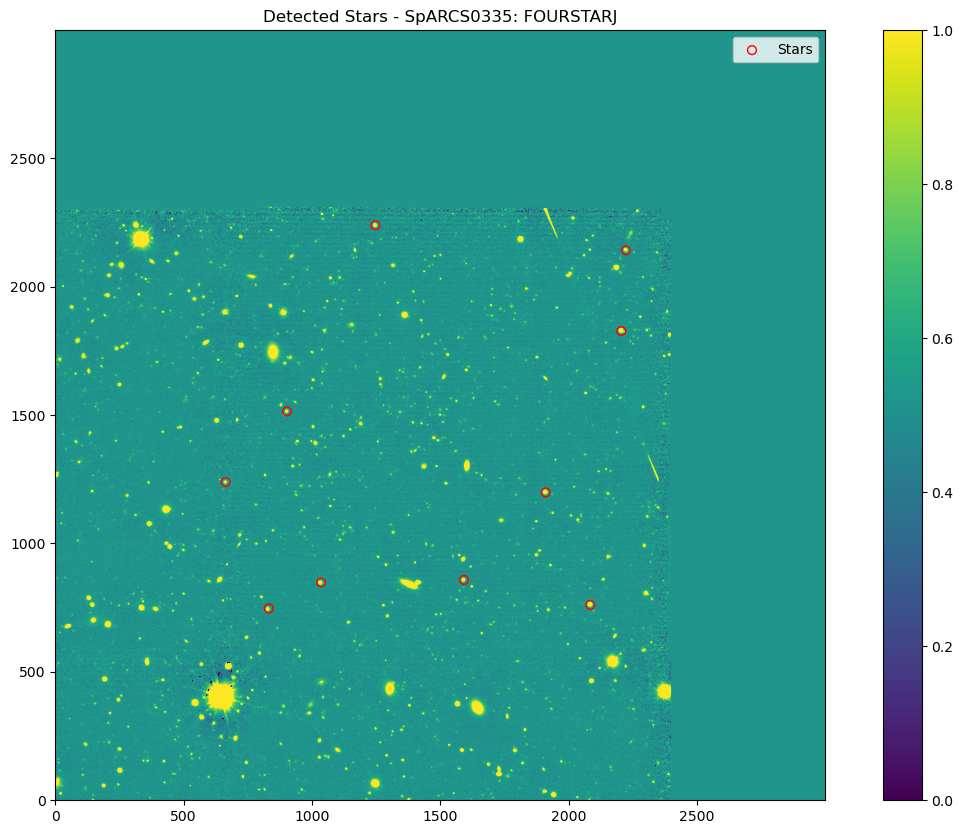

SpARCS0335 FOURSTARJ - No stars to filter
PSF saved to /home/six6ix6ix/OneDrive_brooksc99@ku.edu/Deconvolution/PSFs/SpARCS0335_FOURSTARJ_psf.fits


In [13]:
psf_filename_list = []
for cluster in clusters:
    filtered_df = clusters_df_3[clusters_df_3['Cluster'] == cluster]
    for i in filtered_df.index:
        band = filtered_df['Band'][i]
        data_file = filtered_df['Data File'][i]
        noise_file = filtered_df['Noise File'][i]
        star_list = filtered_df['cPHOTID'][i]
        catalog_file = f'{root2}star_cut_catalogs/{cluster}_{band}_psf_stars.csv'
        print_input_image_catalog(root2,cluster, band, star_list, data_file, noise_file, catalog_file)
        psf = build_psf_from_catalog(cluster, band, star_list,data_file, noise_file,catalog_file)
        psf_filename = f'{psf_dir}{cluster}_{band}_psf.fits'
        #psf_filename_list.append(psf_filename)
        save_psf_to_fits(psf, psf_filename)
        
        #print(data_file)

In [17]:
psf[0].shape

(41, 41)

In [ ]:
#### Plot the PSFs. Use save_to_fits function to save the PSFs to disk. 

SPT0205 FOURSTARJ - No stars to filter


SPT0205 FOURSTARJ1 - No stars to filter


SPT0205 FOURSTARKs - Filtering out stars: [101001571]
SPT0205 IRAC1 - No stars to filter
SPT0205 IRAC2 - No stars to filter


SPT0205 VIMOSB - Filtering out stars: [101001930, 101001473]


SPT0205 VIMOSI - Filtering out stars: [101001662, 101002234]


SPT0205 VIMOSR - Filtering out stars: [101001571, 101000435]


SPT0205 VIMOSU - No stars to filter


SPT0205 VIMOSV - No stars to filter


SPT0205 VIMOSz - Filtering out stars: [101001571, 101001950, 101001998]


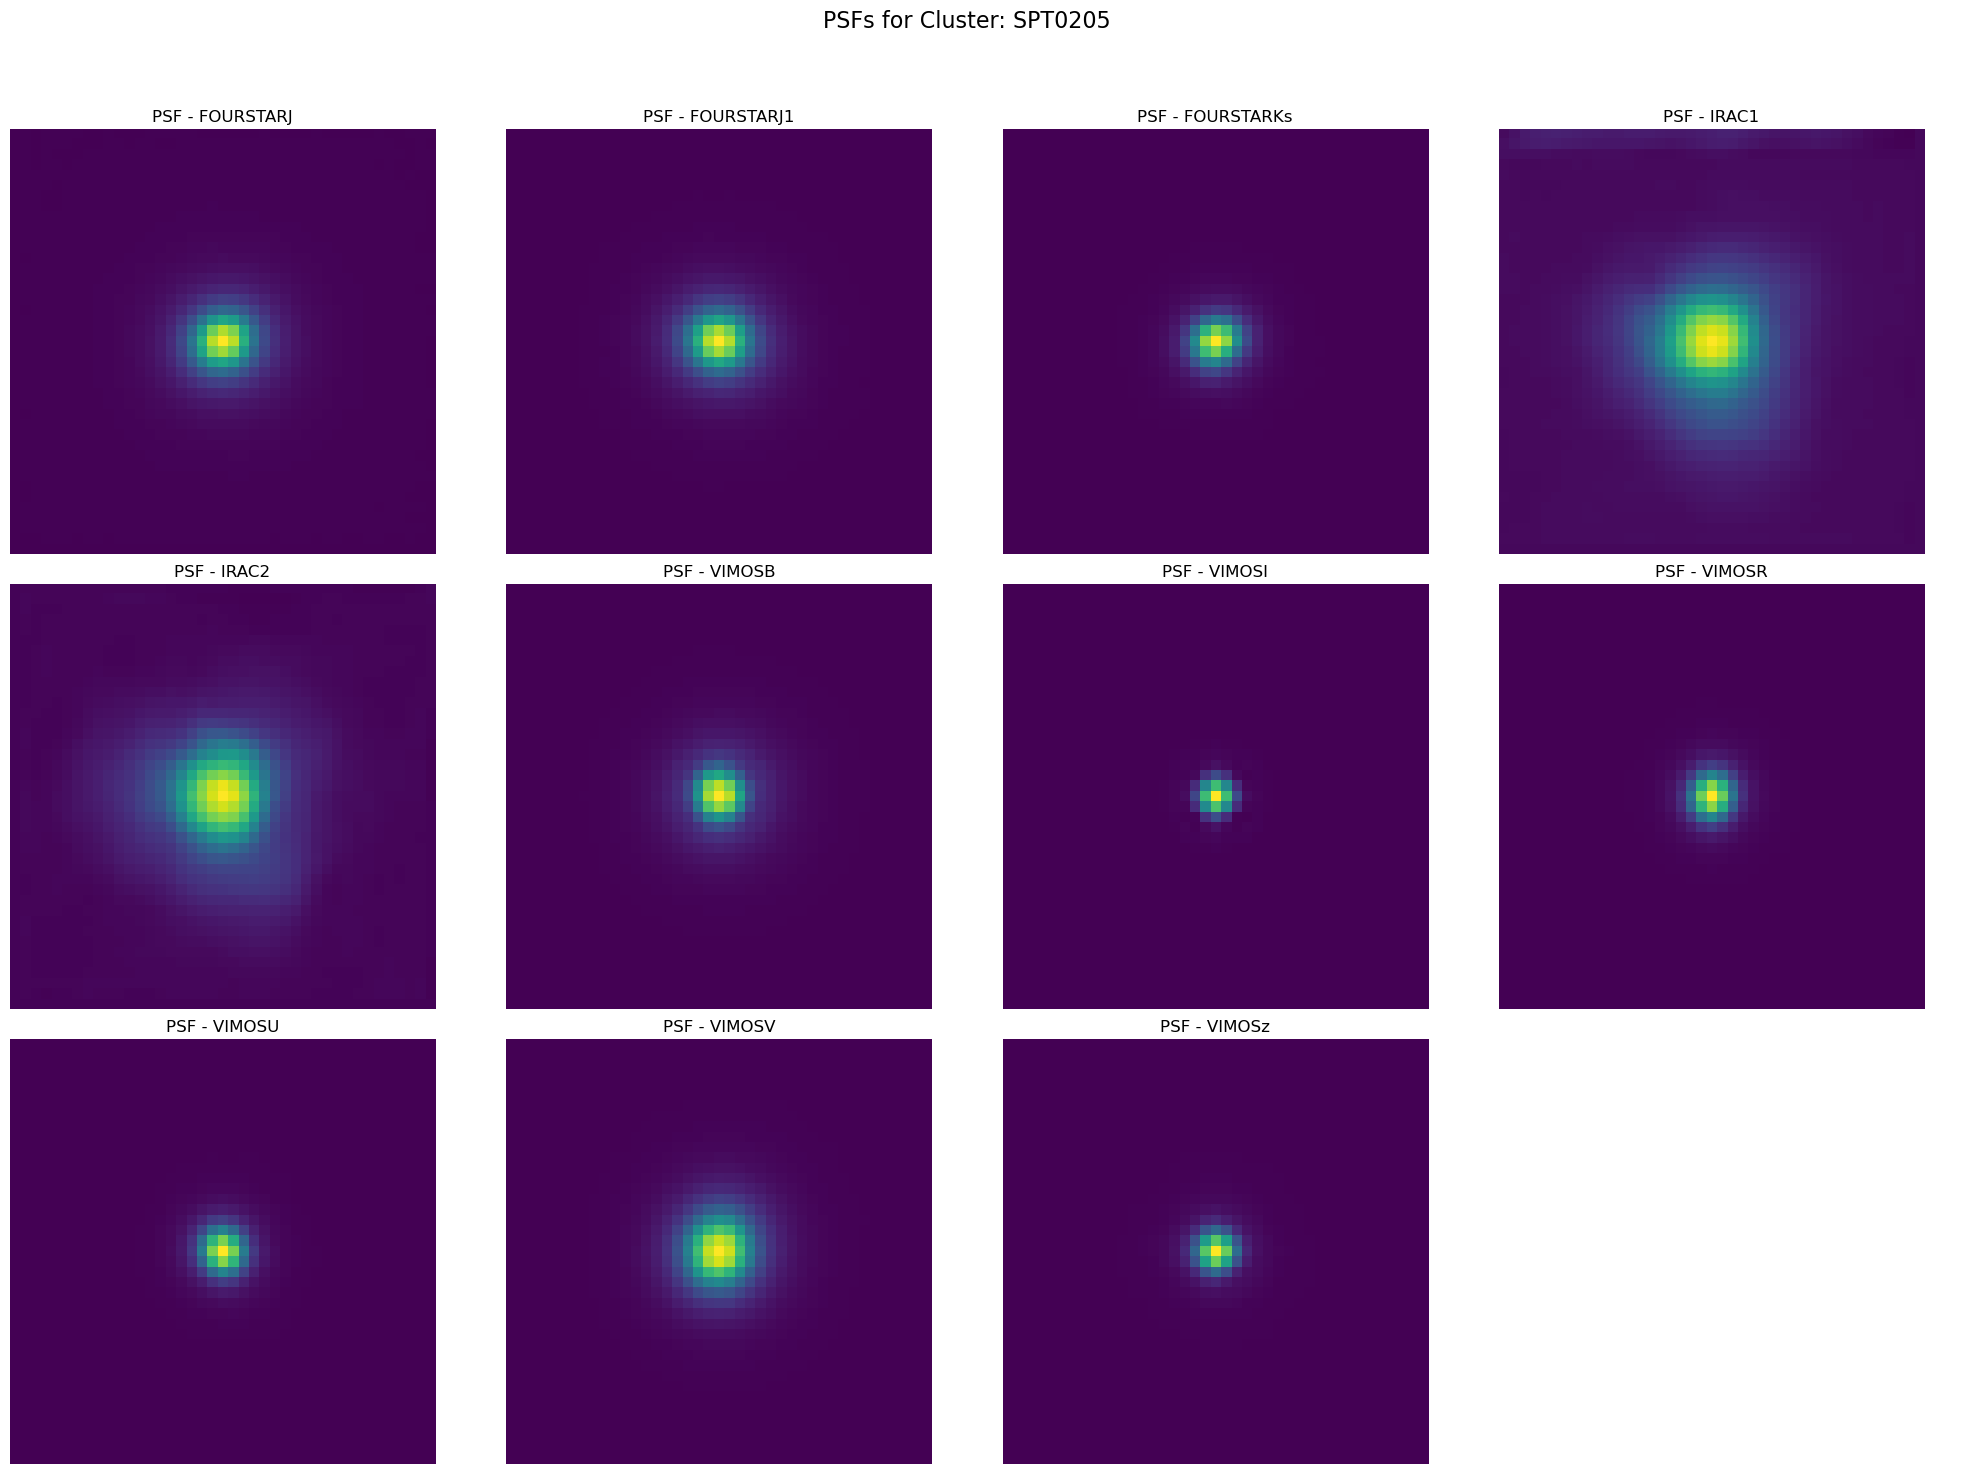

SPT0546 FOURSTARJ - No stars to filter


SPT0546 FOURSTARJ1 - No stars to filter


SPT0546 FOURSTARKs - No stars to filter
SPT0546 IRAC1 - No stars to filter
SPT0546 IRAC2 - No stars to filter


SPT0546 VIMOSB - No stars to filter


SPT0546 VIMOSI - Filtering out stars: [102000633, 102000682, 102000732, 102000850, 102001054, 102001167, 102001404, 102001598, 102001846, 102001961, 102001975, 102001982, 102001996, 102002060, 102002393, 102002453, 102002466, 102002474, 102002545, 102002703, 102002734, 102003074, 102003223, 102003234]


SPT0546 VIMOSR - Invalid star_list format: ['102000633','102000682','102001846','102001961','102001964','102002393','102002466',102003065','102003143','102002474','102002703','102003223','102003234']


SPT0546 VIMOSU - Filtering out stars: [102003074]


SPT0546 VIMOSV - Filtering out stars: [102001167, 102002393, 102002474, 102002734, 102003074, 102003223]


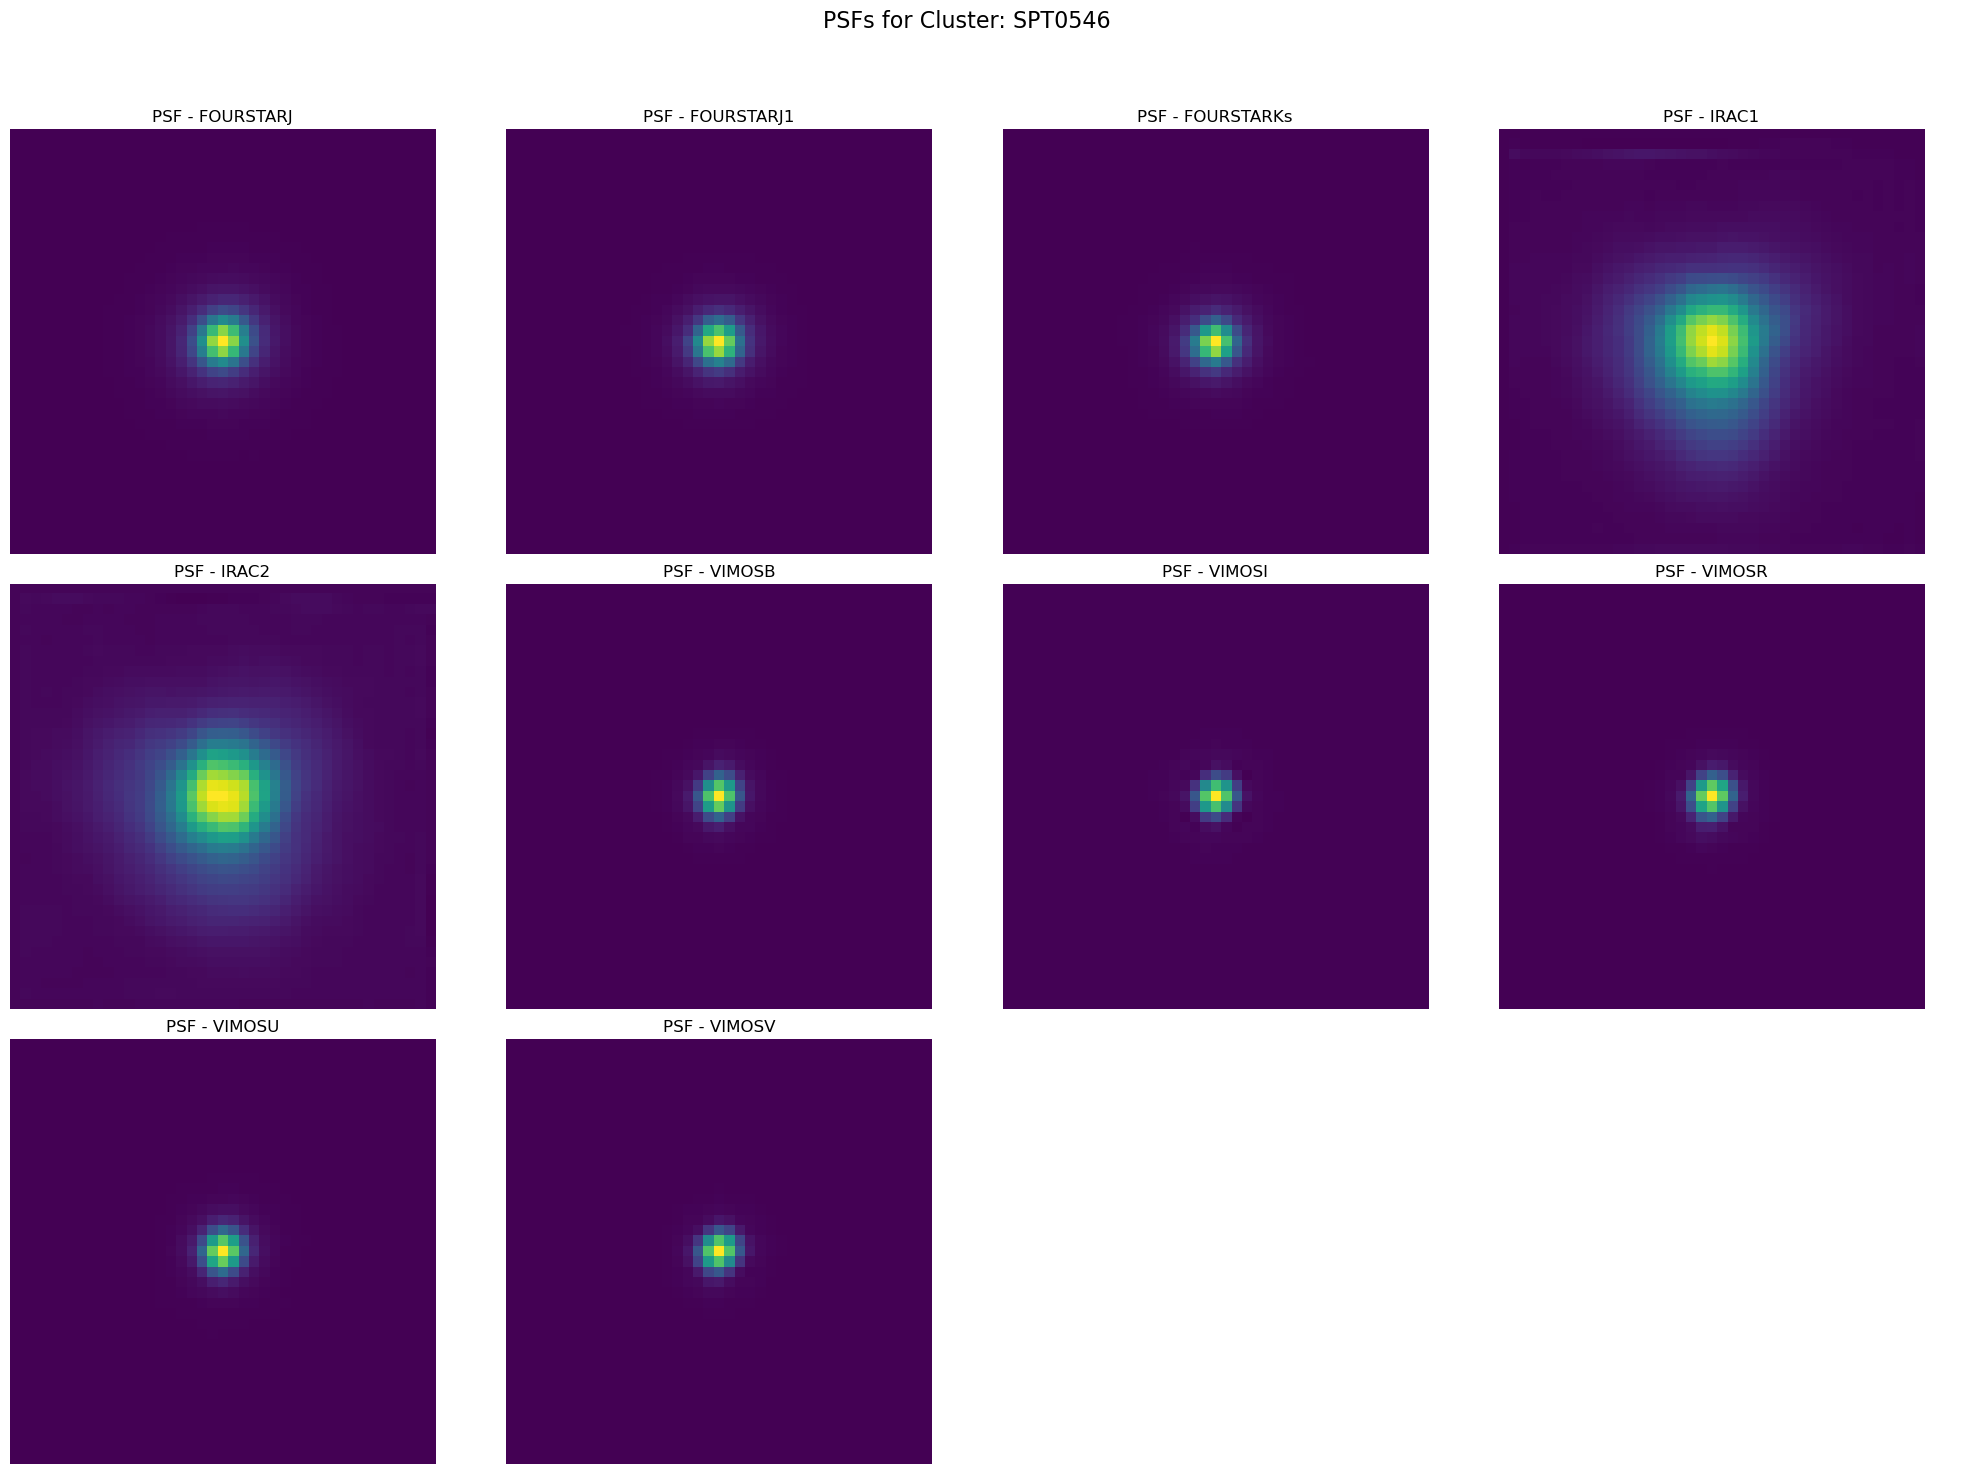

SPT2106 FOURSTARJ - Filtering out stars: [103002444]


SPT2106 FOURSTARJ1 - Filtering out stars: [103001263]


SPT2106 HAWKIKs - Filtering out stars: [103000669, 103000672, 103001263, 103002444, 1003002665, 103002816]
SPT2106 IRAC1 - No stars to filter


SPT2106 IRAC2 - No stars to filter


Error processing SPT2106, IRAC2: All elements of input 'data' must be finite.
SPT2106 VIMOSB - No stars to filter


SPT2106 VIMOSI - Filtering out stars: [103000843, 103001049, 103001095, 103000843, 103001263, 103001322, 103002087, 103002104, 103002533, 103002665, 103002668]


SPT2106 VIMOSR - Filtering out stars: [103001049, 103001801, 103002087, 103002104, 103002764, 103002816]


SPT2106 VIMOSU - No stars to filter


SPT2106 VIMOSV - Filtering out stars: [103000674, 103001946, 103002018, 103002336, 103002678, 103002790]


SPT2106 VIMOSz - Filtering out stars: [103002665]


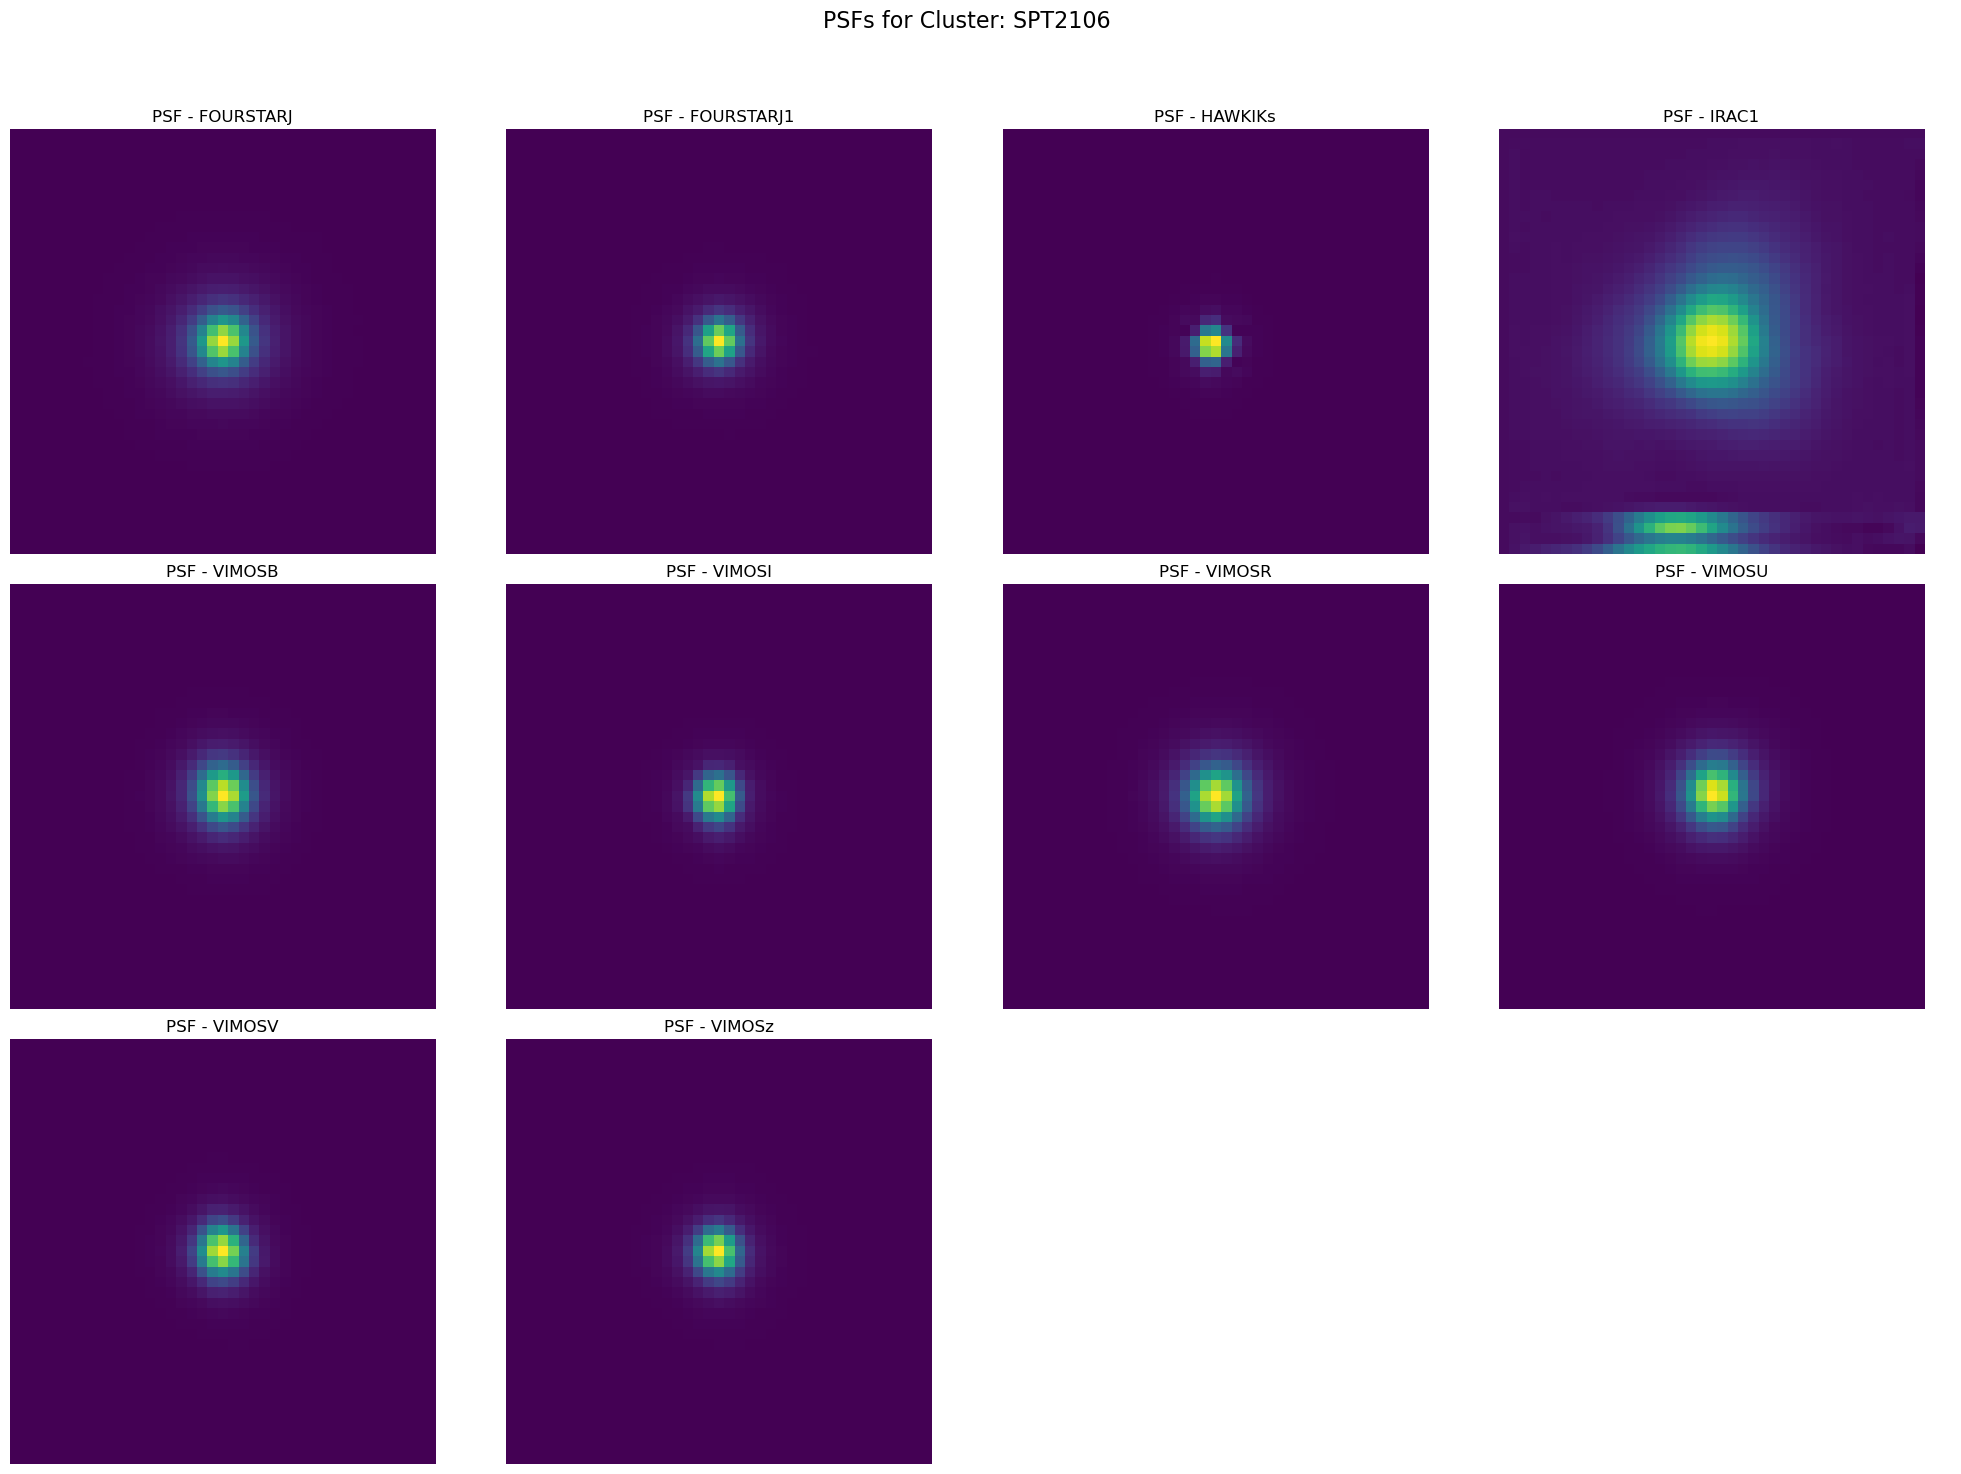

SpARCS0035 DECamz - No stars to filter


SpARCS0035 FOURSTARJ1 - No stars to filter
SpARCS0035 HAWKIJ - No stars to filter
SpARCS0035 HAWKIKs - Filtering out stars: [104002572]
SpARCS0035 IRAC1 - No stars to filter
SpARCS0035 IRAC2 - No stars to filter
SpARCS0035 IRAC3 - No stars to filter


SpARCS0035 IRAC4 - No stars to filter


SpARCS0035 VIMOSB - No stars to filter


SpARCS0035 VIMOSI - No stars to filter


SpARCS0035 VIMOSR - No stars to filter


SpARCS0035 VIMOSU - No stars to filter


SpARCS0035 VIMOSV - No stars to filter


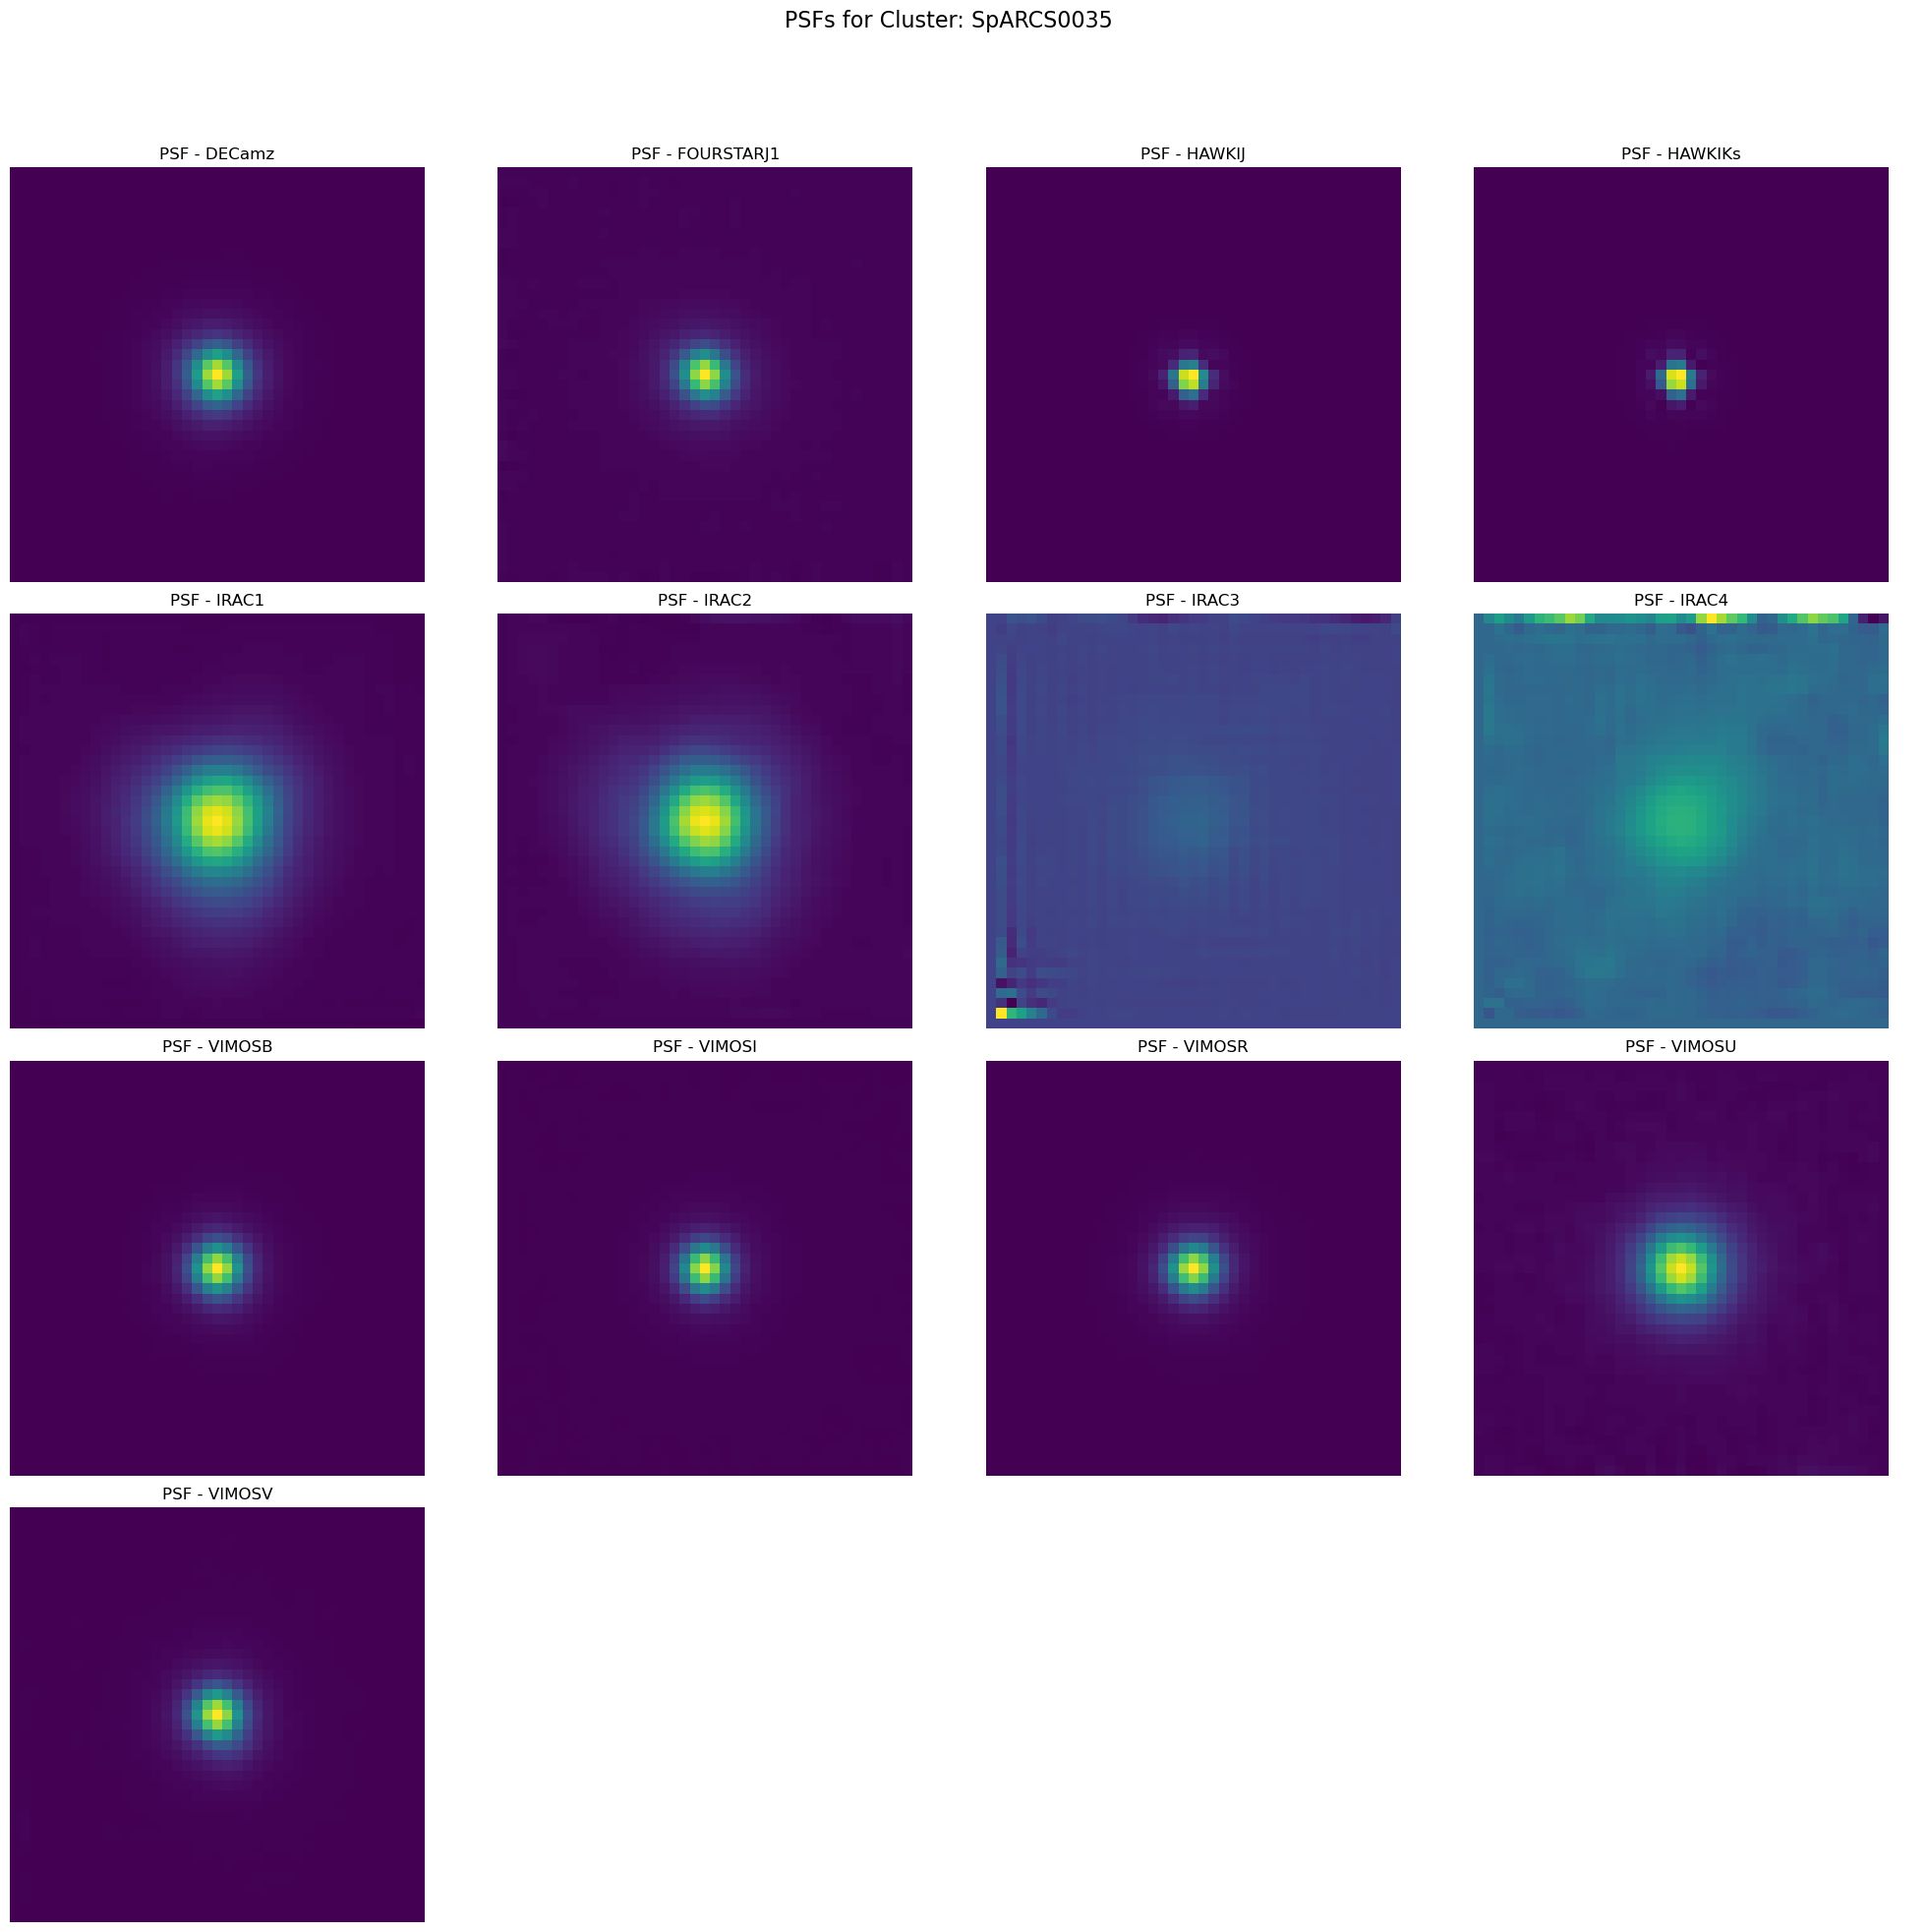

SpARCS0219 FOURSTARJ - Filtering out stars: [105000222, 105001747]


SpARCS0219 FOURSTARJ1 - Filtering out stars: [105001747]


SpARCS0219 FOURSTARKs - Filtering out stars: [105000800, 105001509, 105001747]
SpARCS0219 IRAC1 - No stars to filter
SpARCS0219 IRAC2 - No stars to filter
SpARCS0219 IRAC3 - No stars to filter


SpARCS0219 IRAC4 - No stars to filter


SpARCS0219 VIMOSB - Filtering out stars: [105001747]


SpARCS0219 VIMOSI - Filtering out stars: [105000222]


SpARCS0219 VIMOSR - No stars to filter


SpARCS0219 VIMOSU - Filtering out stars: [105001747]


SpARCS0219 VIMOSV - Filtering out stars: [105001747]


SpARCS0219 VIMOSz - Filtering out stars: [105000222, 105001747]


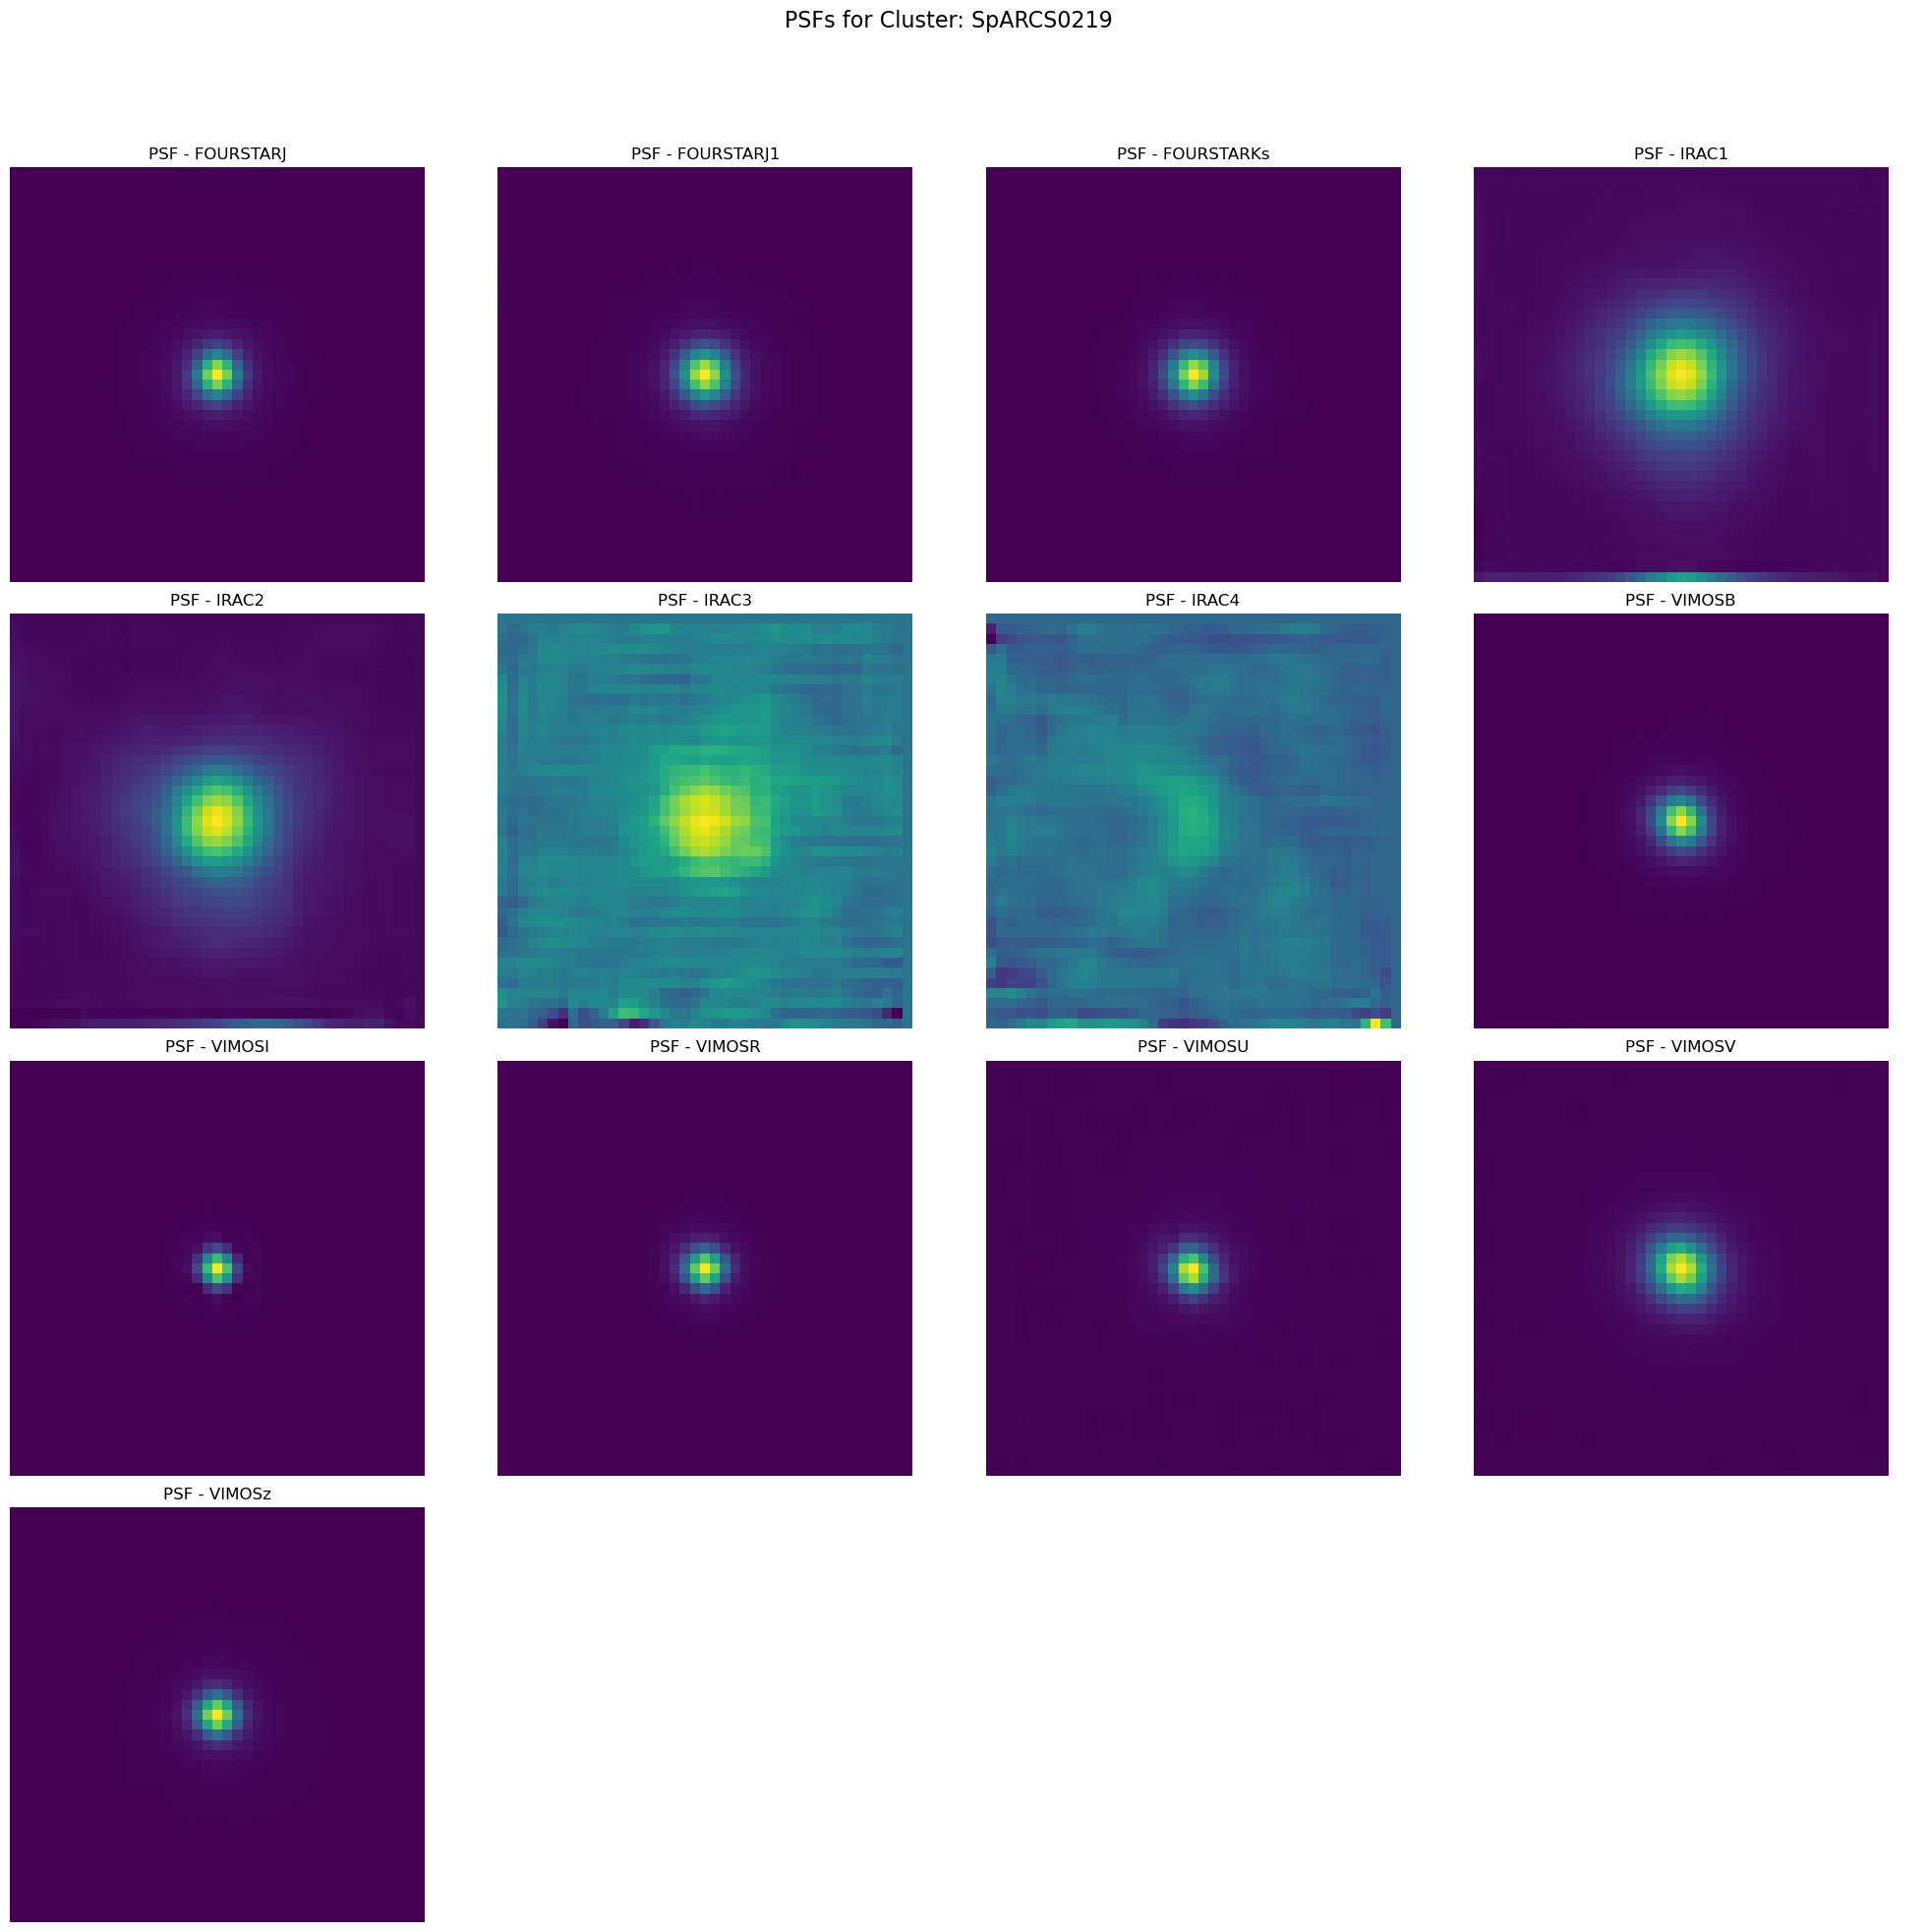

SpARCS0335 FOURSTARKs - No stars to filter
SpARCS0335 HAWKIY - No stars to filter
SpARCS0335 IRAC1 - No stars to filter
SpARCS0335 IRAC2 - No stars to filter
SpARCS0335 IRAC3 - No stars to filter


SpARCS0335 IRAC4 - No stars to filter


SpARCS0335 VIMOSB - No stars to filter


SpARCS0335 VIMOSI - Filtering out stars: [106000822]


SpARCS0335 VIMOSR - No stars to filter


SpARCS0335 VIMOSU - No stars to filter


SpARCS0335 VIMOSV - No stars to filter


SpARCS0335 VIMOSz - No stars to filter


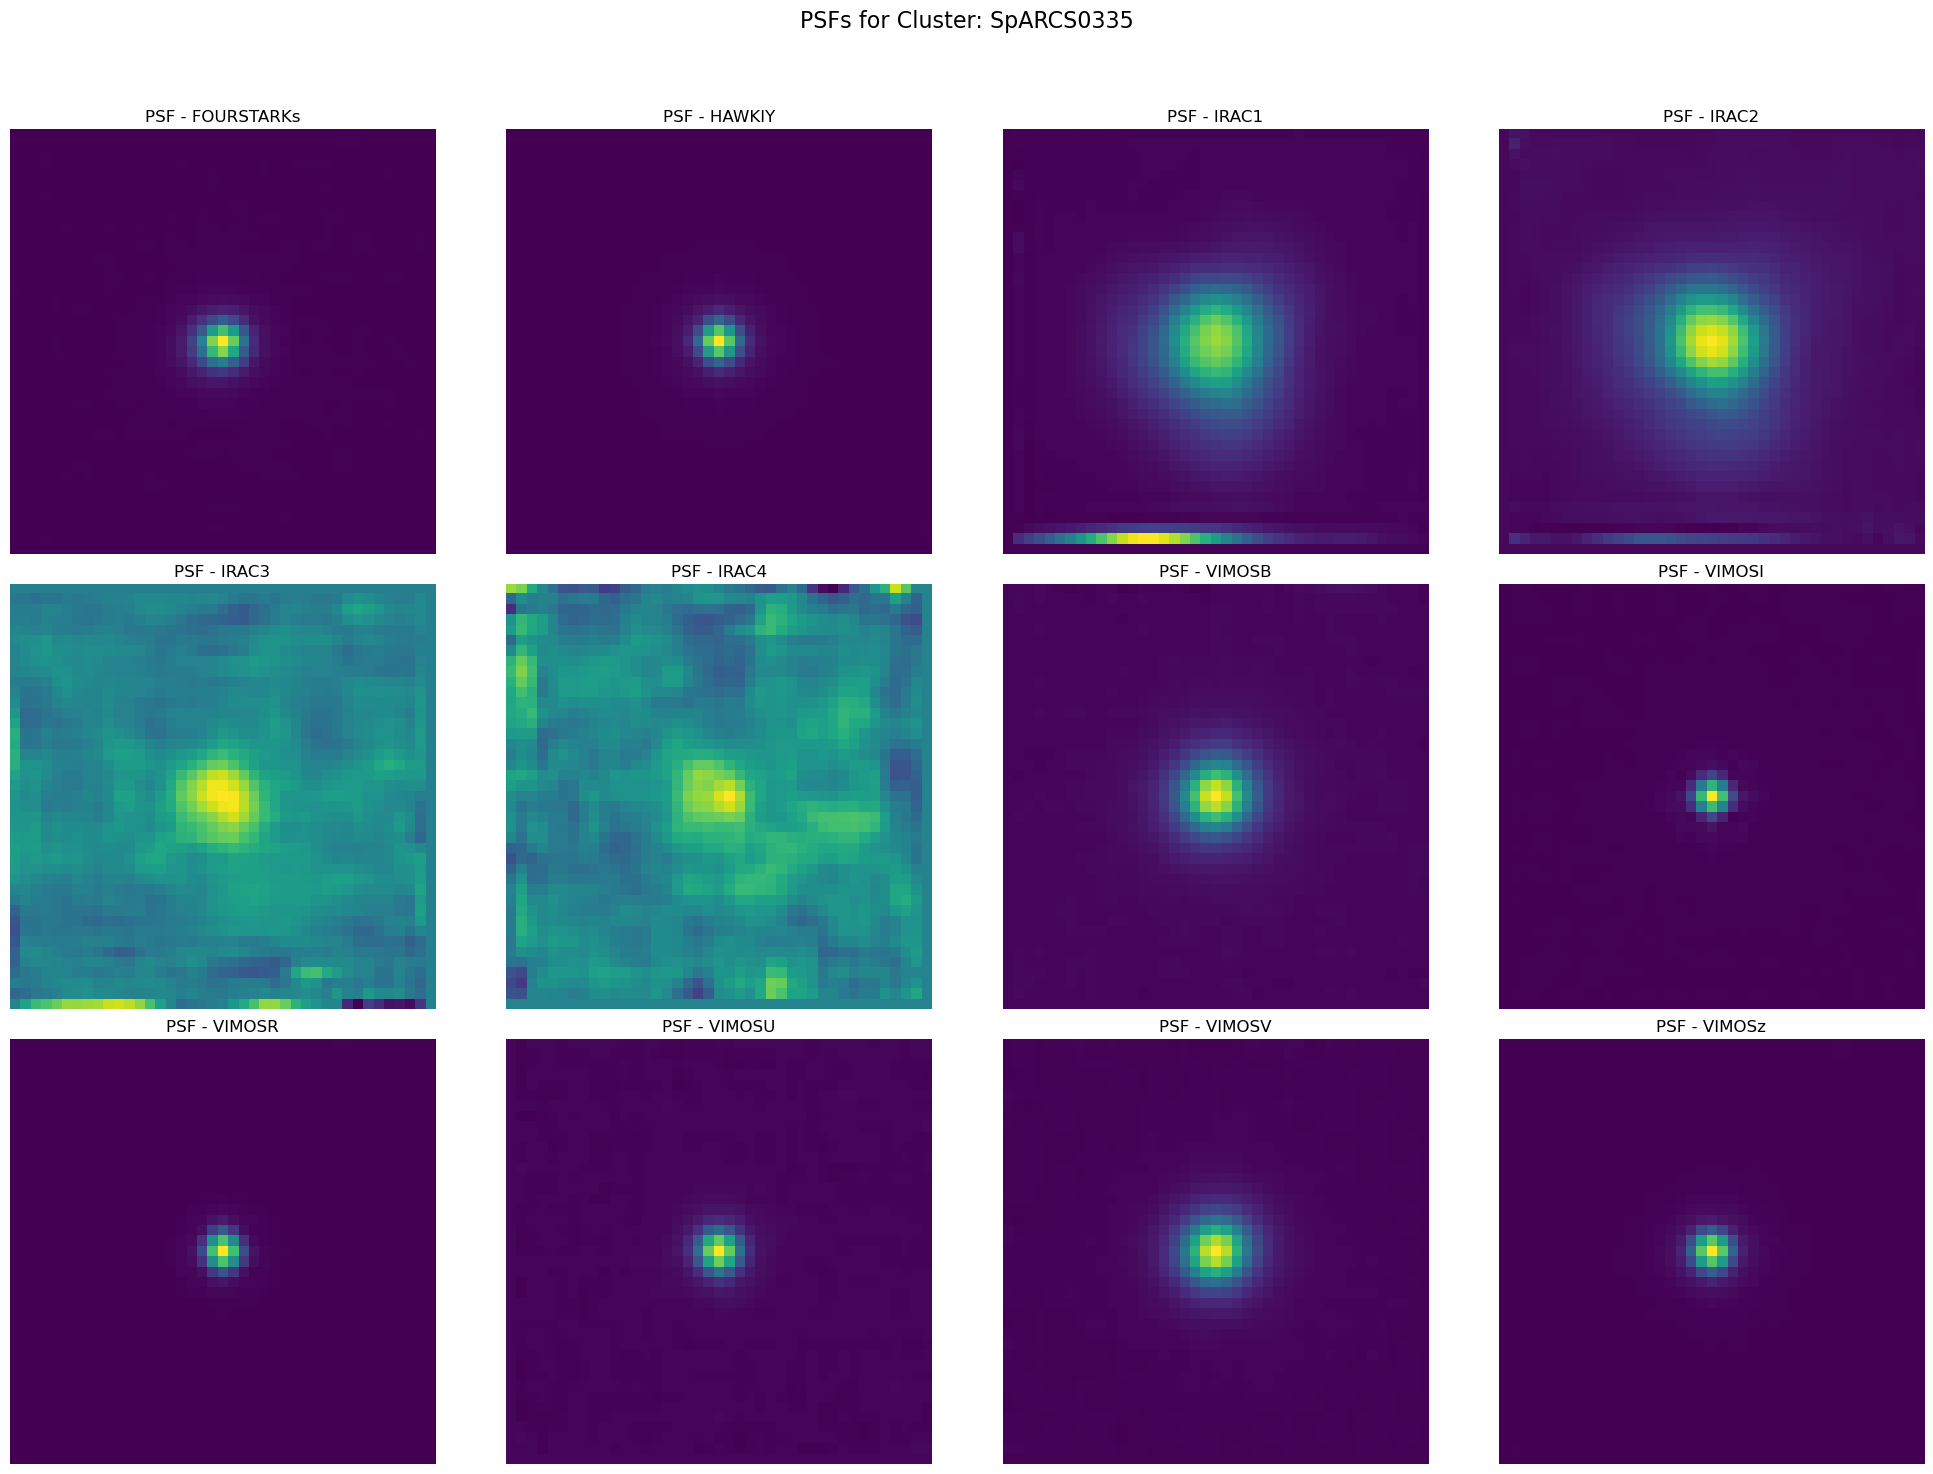

SpARCS1034 HSCy - Filtering out stars: [108003171, 108004662]
SpARCS1034 HSCz - Filtering out stars: [108004662]
SpARCS1034 IRAC1 - No stars to filter
SpARCS1034 IRAC2 - No stars to filter
SpARCS1034 IRAC3 - No stars to filter


SpARCS1034 IRAC4 - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1034 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1034 Suprimei - Filtering out stars: [108004065]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1034 Suprimer - No stars to filter


SpARCS1034 WIRCamJ - Filtering out stars: [108004662]


SpARCS1034 WIRCamK - Filtering out stars: [108001350, 108004064, 108004662, 108008541]


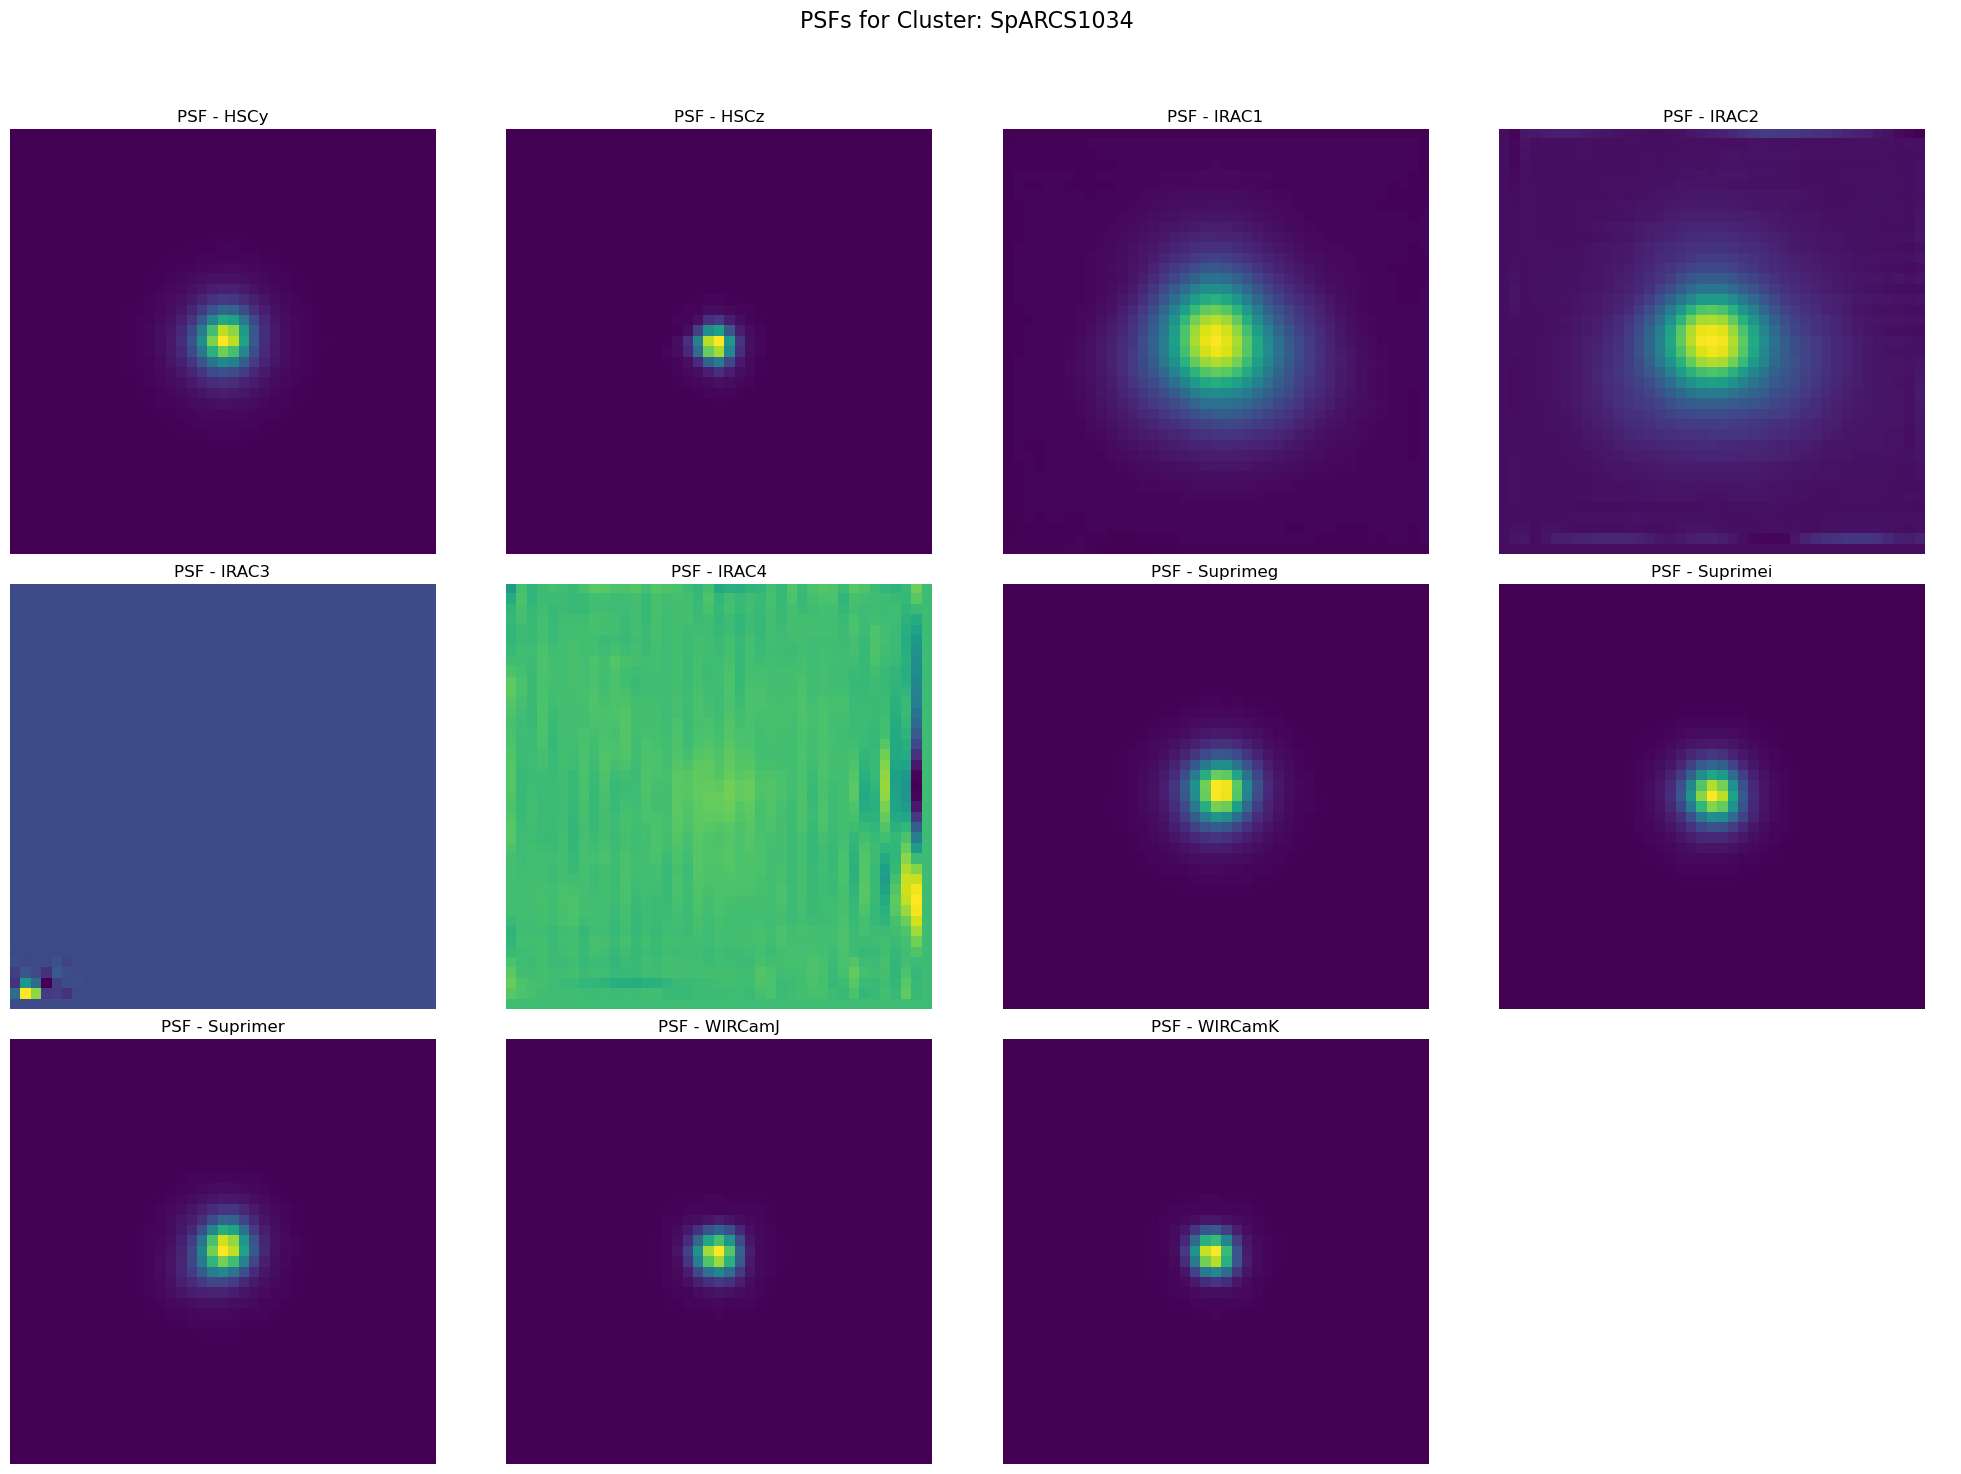

SpARCS1616 HSCy - No stars to filter


SpARCS1616 HSCz - No stars to filter
SpARCS1616 IRAC1 - No stars to filter
SpARCS1616 IRAC2 - No stars to filter
SpARCS1616 IRAC3 - No stars to filter
SpARCS1616 IRAC4 - No stars to filter


Error processing SpARCS1616, IRAC4: No points given
SpARCS1616 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1616 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1616 Suprimei - Filtering out stars: [110008997, 110009550]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1616 Suprimer - Filtering out stars: [110008997]
SpARCS1616 WIRCamJ - Filtering out stars: [110008997, 110009550]
SpARCS1616 WIRCamK - Filtering out stars: [110007491, 110008997, 110009550]


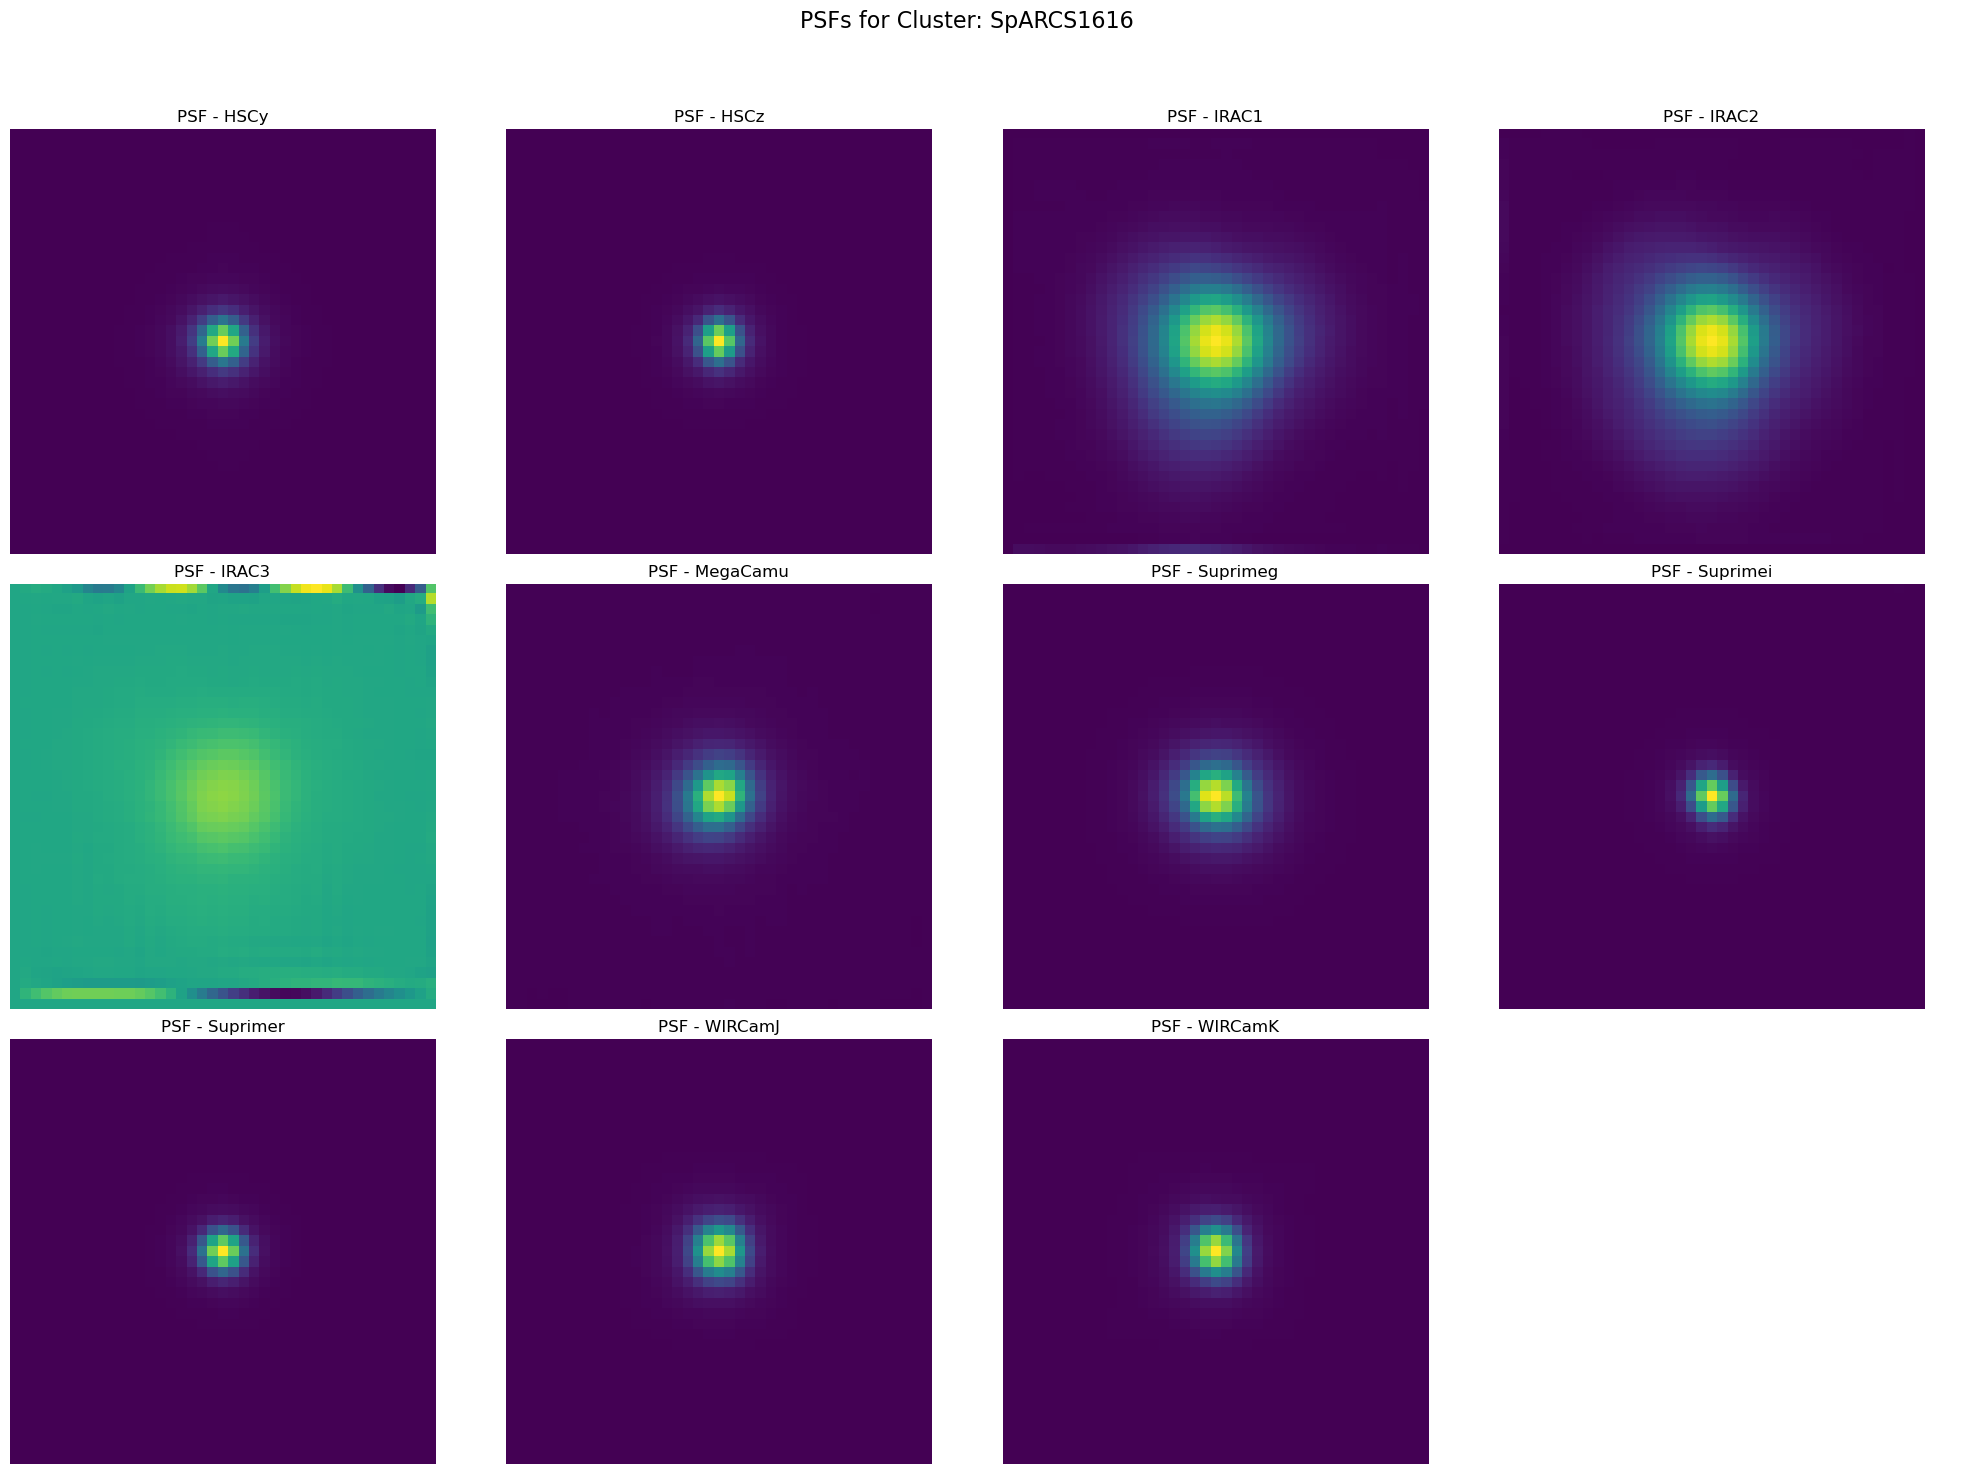

SpARCS1634 GMOSz - No stars to filter
SpARCS1634 IRAC1 - No stars to filter
SpARCS1634 IRAC2 - No stars to filter
SpARCS1634 IRAC3 - No stars to filter


SpARCS1634 IRAC4 - No stars to filter


SpARCS1634 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1634 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1634 Suprimei - Filtering out stars: [111003969, 111004522, 111005881, 111006317]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1634 Suprimer - Filtering out stars: [111004201, 111006317]


SpARCS1634 WIRCamJ - No stars to filter


SpARCS1634 WIRCamK - Filtering out stars: [111007767]


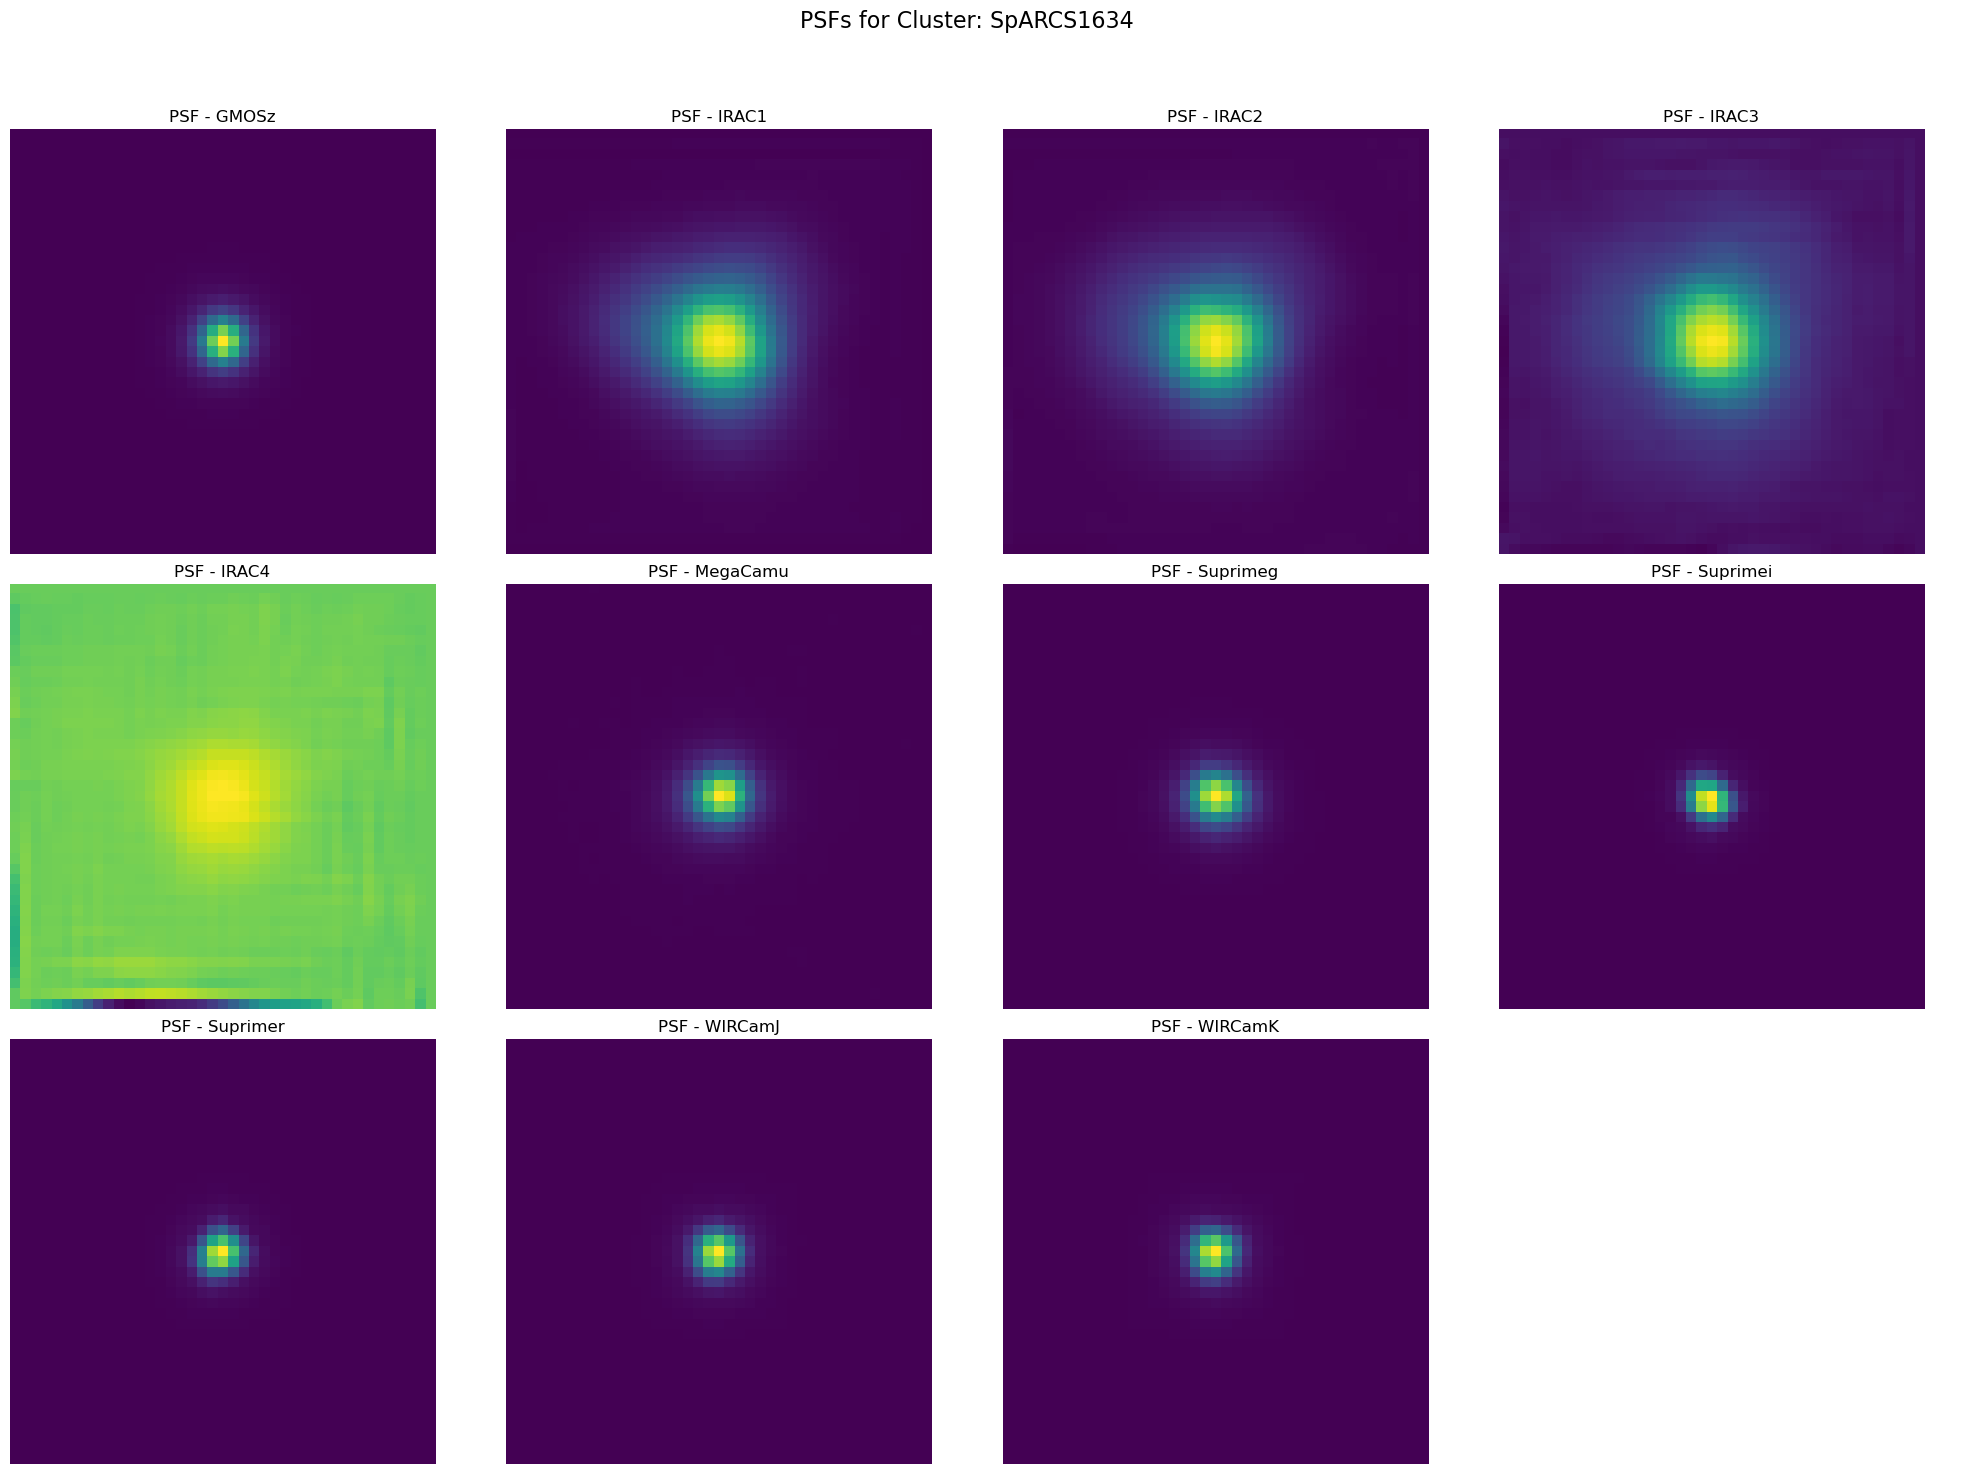

SpARCS1638 GMOSz - No stars to filter
SpARCS1638 IRAC1 - No stars to filter
SpARCS1638 IRAC2 - No stars to filter
SpARCS1638 IRAC3 - No stars to filter
SpARCS1638 IRAC4 - No stars to filter


SpARCS1638 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimei - Filtering out stars: [112008857]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimer - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimey - No stars to filter
SpARCS1638 WIRCamJ - No stars to filter
SpARCS1638 WIRCamK - No stars to filter


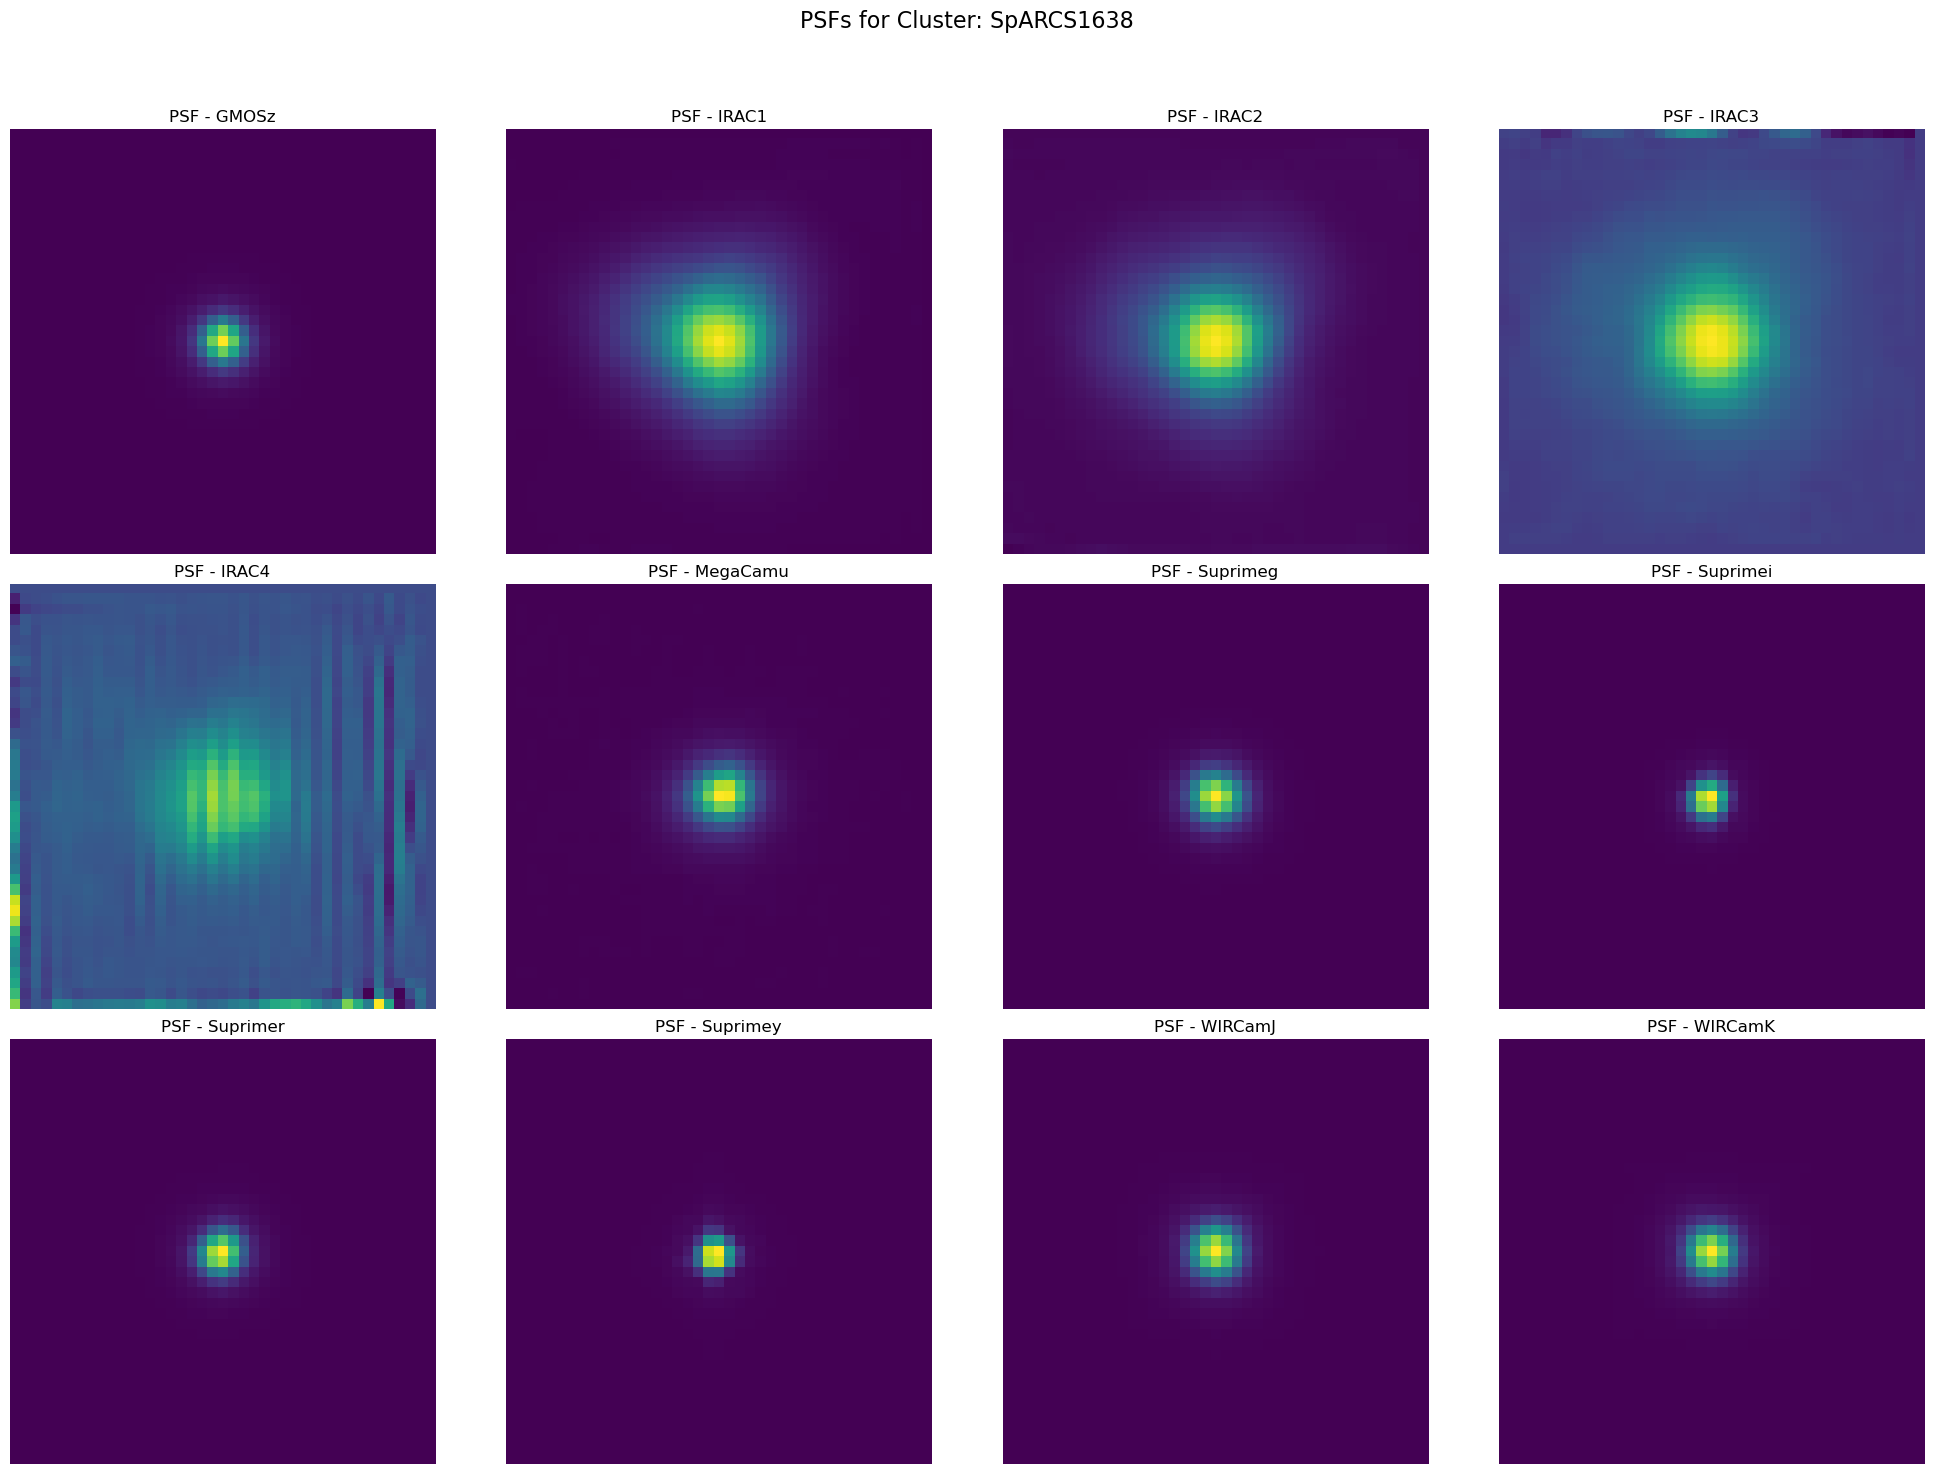

In [8]:
# Call function for all clusters
plot_psfs_per_cluster(clusters, root2)

SPT0205 FOURSTARJ - No stars to filter


SPT0205 FOURSTARJ1 - No stars to filter


SPT0205 FOURSTARKs - Filtering out stars: [101001571]
SPT0205 IRAC1 - No stars to filter
SPT0205 IRAC2 - No stars to filter


SPT0205 VIMOSB - Filtering out stars: [101001930, 101001473]


SPT0205 VIMOSI - Filtering out stars: [101001662, 101002234]


SPT0205 VIMOSR - Filtering out stars: [101001571, 101000435]


SPT0205 VIMOSU - No stars to filter


SPT0205 VIMOSV - No stars to filter


SPT0205 VIMOSz - Filtering out stars: [101001571, 101001950, 101001998]


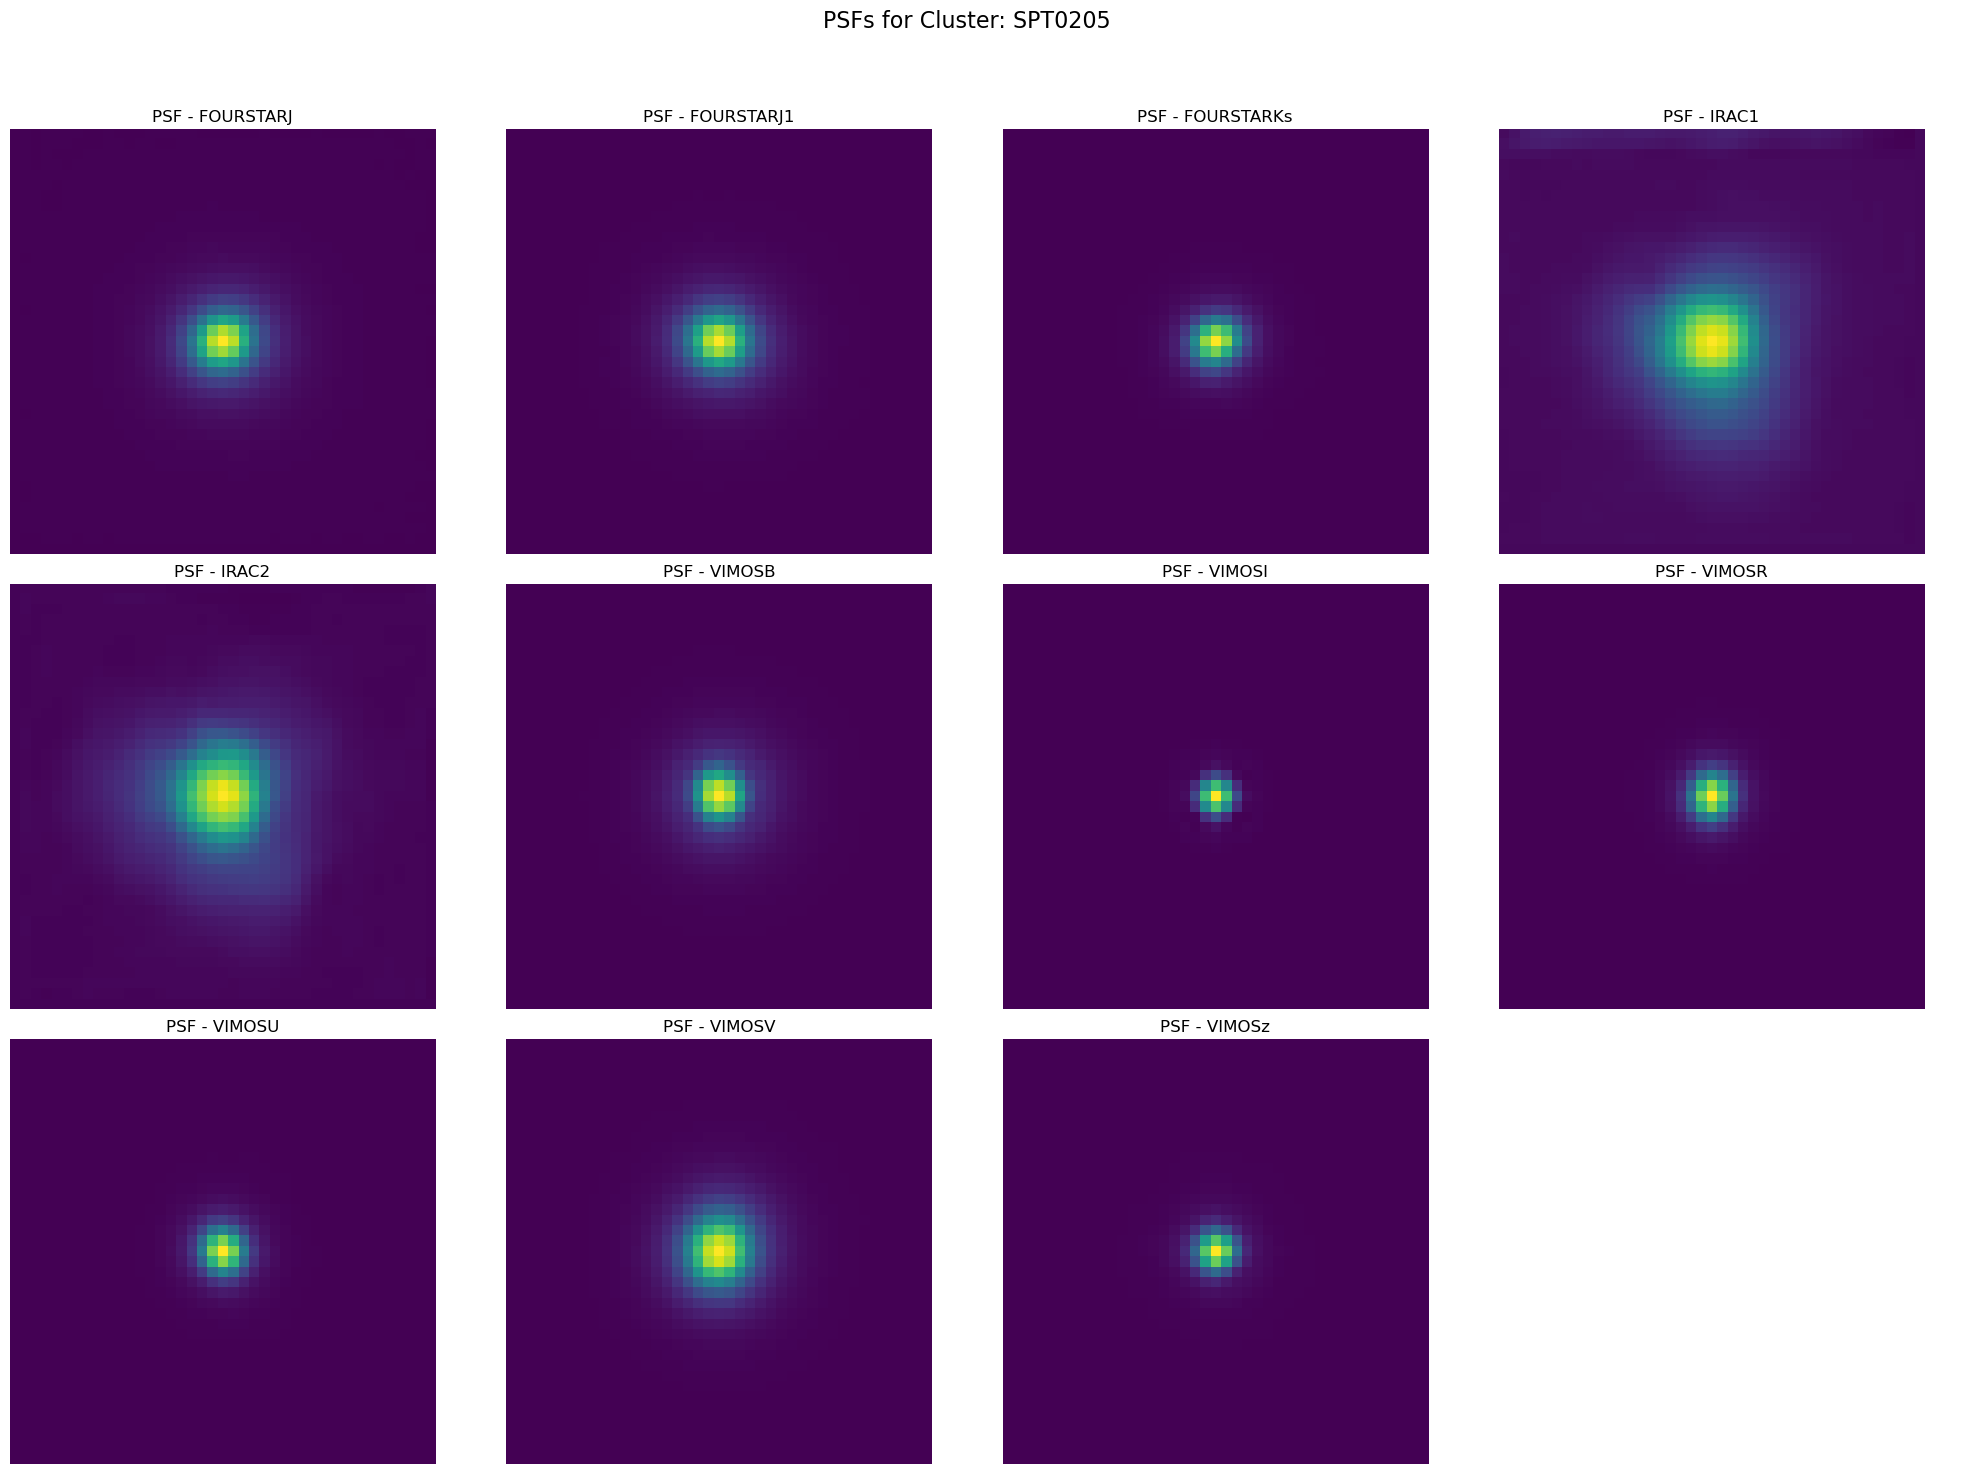

SPT0546 FOURSTARJ - No stars to filter


SPT0546 FOURSTARJ1 - No stars to filter


SPT0546 FOURSTARKs - No stars to filter
SPT0546 IRAC1 - No stars to filter
SPT0546 IRAC2 - No stars to filter


SPT0546 VIMOSB - No stars to filter


SPT0546 VIMOSI - Filtering out stars: [102000633, 102000682, 102000732, 102000850, 102001054, 102001167, 102001404, 102001598, 102001846, 102001961, 102001975, 102001982, 102001996, 102002060, 102002393, 102002453, 102002466, 102002474, 102002545, 102002703, 102002734, 102003074, 102003223, 102003234]


SPT0546 VIMOSR - Invalid star_list format: ['102000633','102000682','102001846','102001961','102001964','102002393','102002466',102003065','102003143','102002474','102002703','102003223','102003234']


SPT0546 VIMOSU - Filtering out stars: [102003074]


SPT0546 VIMOSV - Filtering out stars: [102001167, 102002393, 102002474, 102002734, 102003074, 102003223]


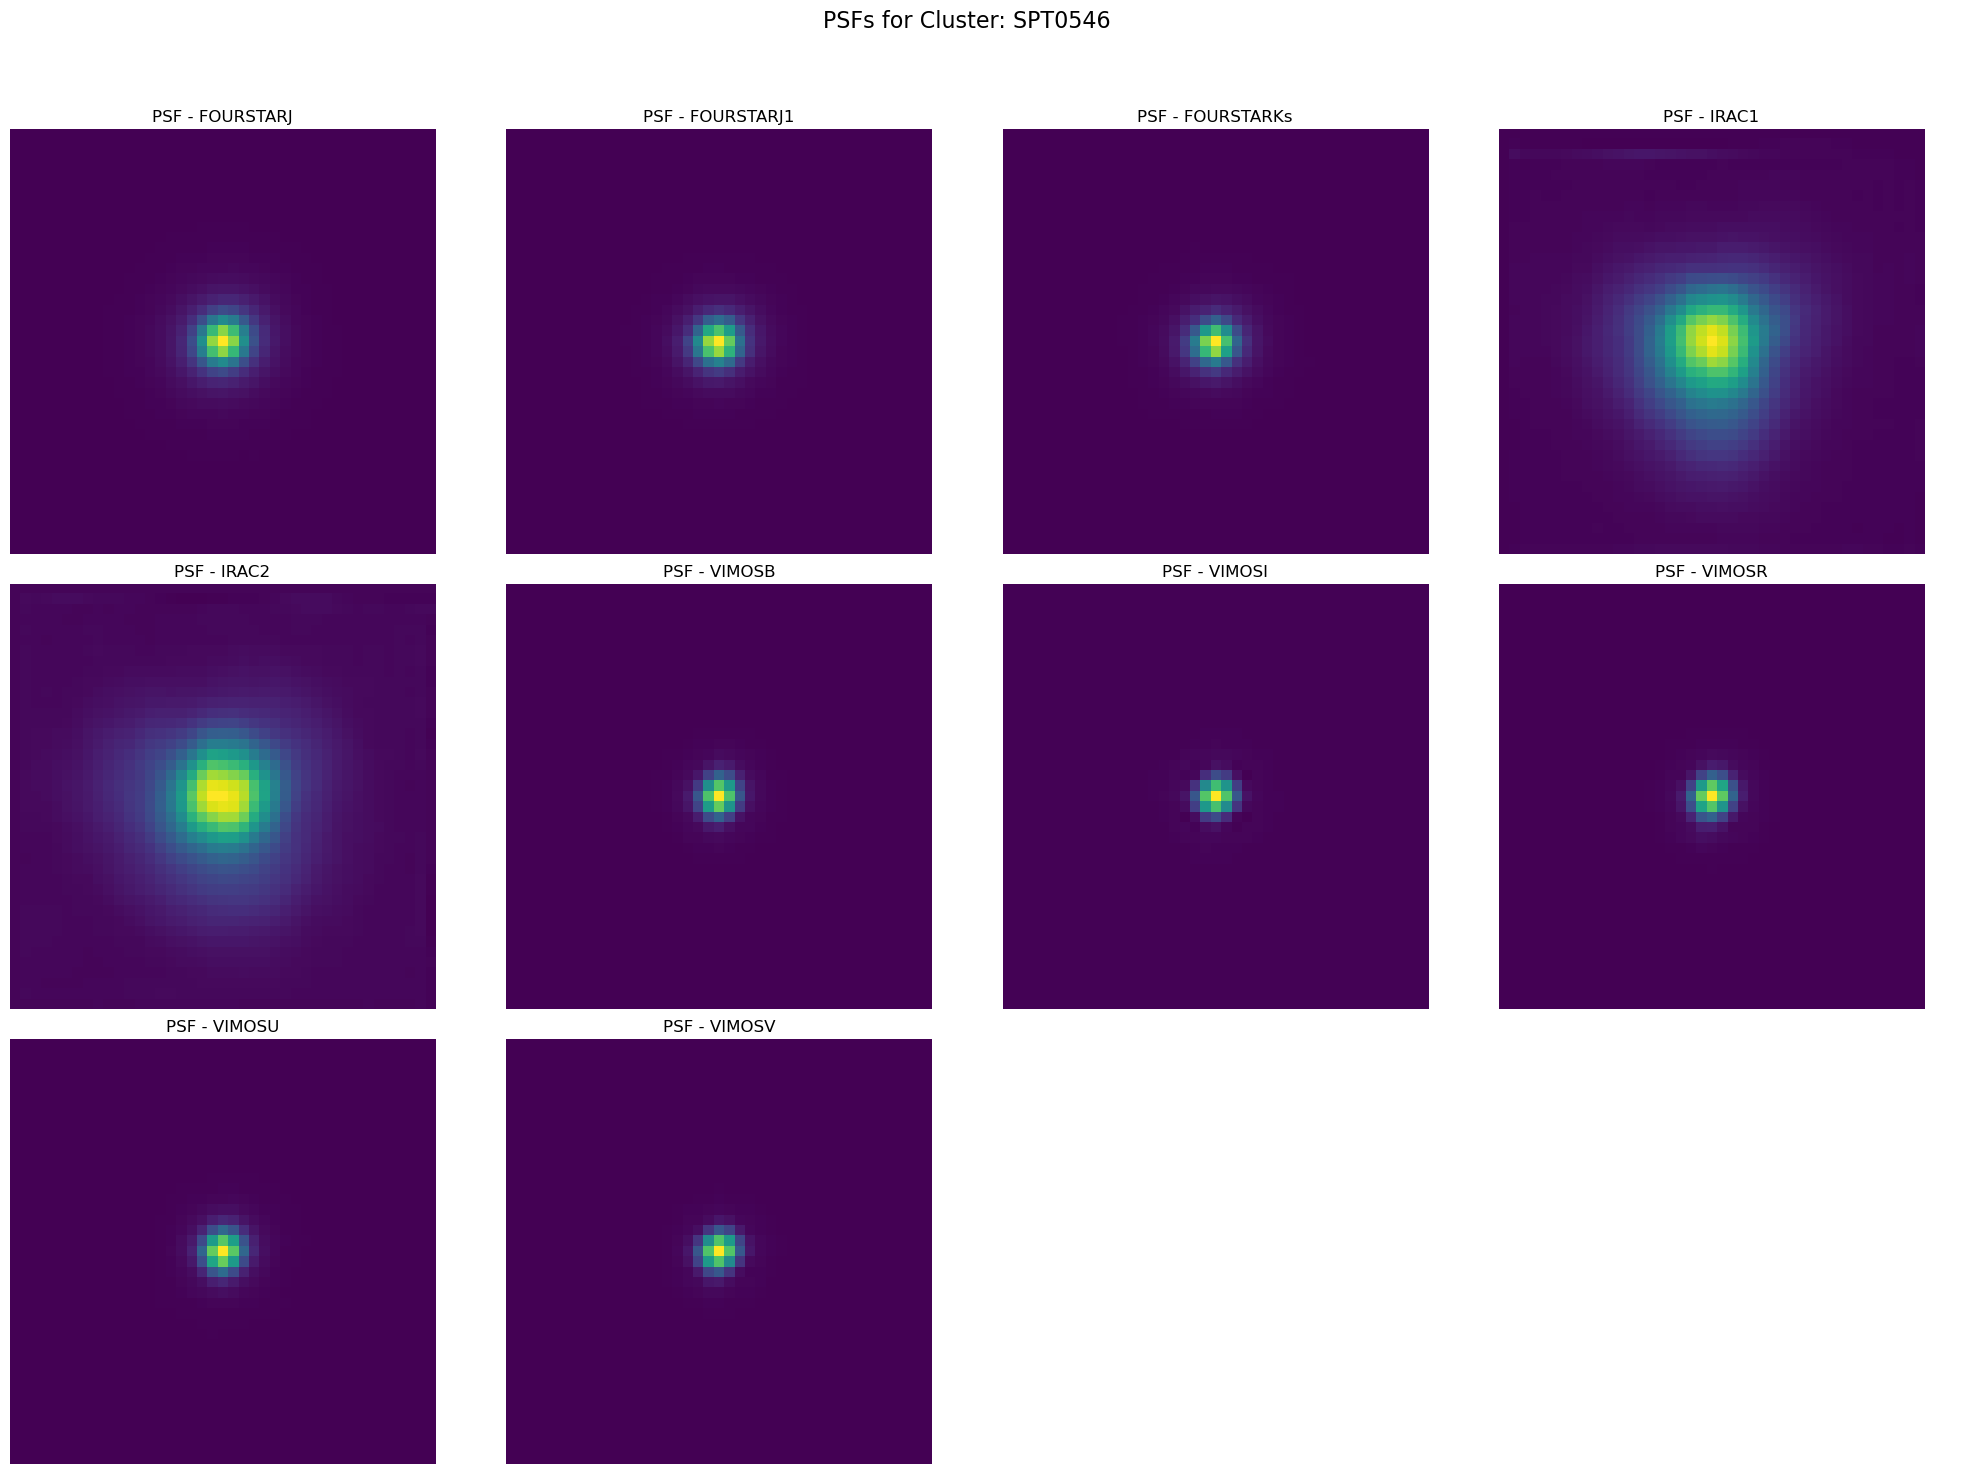

SPT2106 FOURSTARJ - Filtering out stars: [103002444]


SPT2106 FOURSTARJ1 - Filtering out stars: [103001263]


SPT2106 HAWKIKs - Filtering out stars: [103000669, 103000672, 103001263, 103002444, 1003002665, 103002816]
SPT2106 IRAC1 - No stars to filter


SPT2106 IRAC2 - No stars to filter


Error processing SPT2106, IRAC2: All elements of input 'data' must be finite.
SPT2106 VIMOSB - No stars to filter


SPT2106 VIMOSI - Filtering out stars: [103000843, 103001049, 103001095, 103000843, 103001263, 103001322, 103002087, 103002104, 103002533, 103002665, 103002668]


SPT2106 VIMOSR - Filtering out stars: [103001049, 103001801, 103002087, 103002104, 103002764, 103002816]


SPT2106 VIMOSU - No stars to filter


SPT2106 VIMOSV - Filtering out stars: [103000674, 103001946, 103002018, 103002336, 103002678, 103002790]


SPT2106 VIMOSz - Filtering out stars: [103002665]


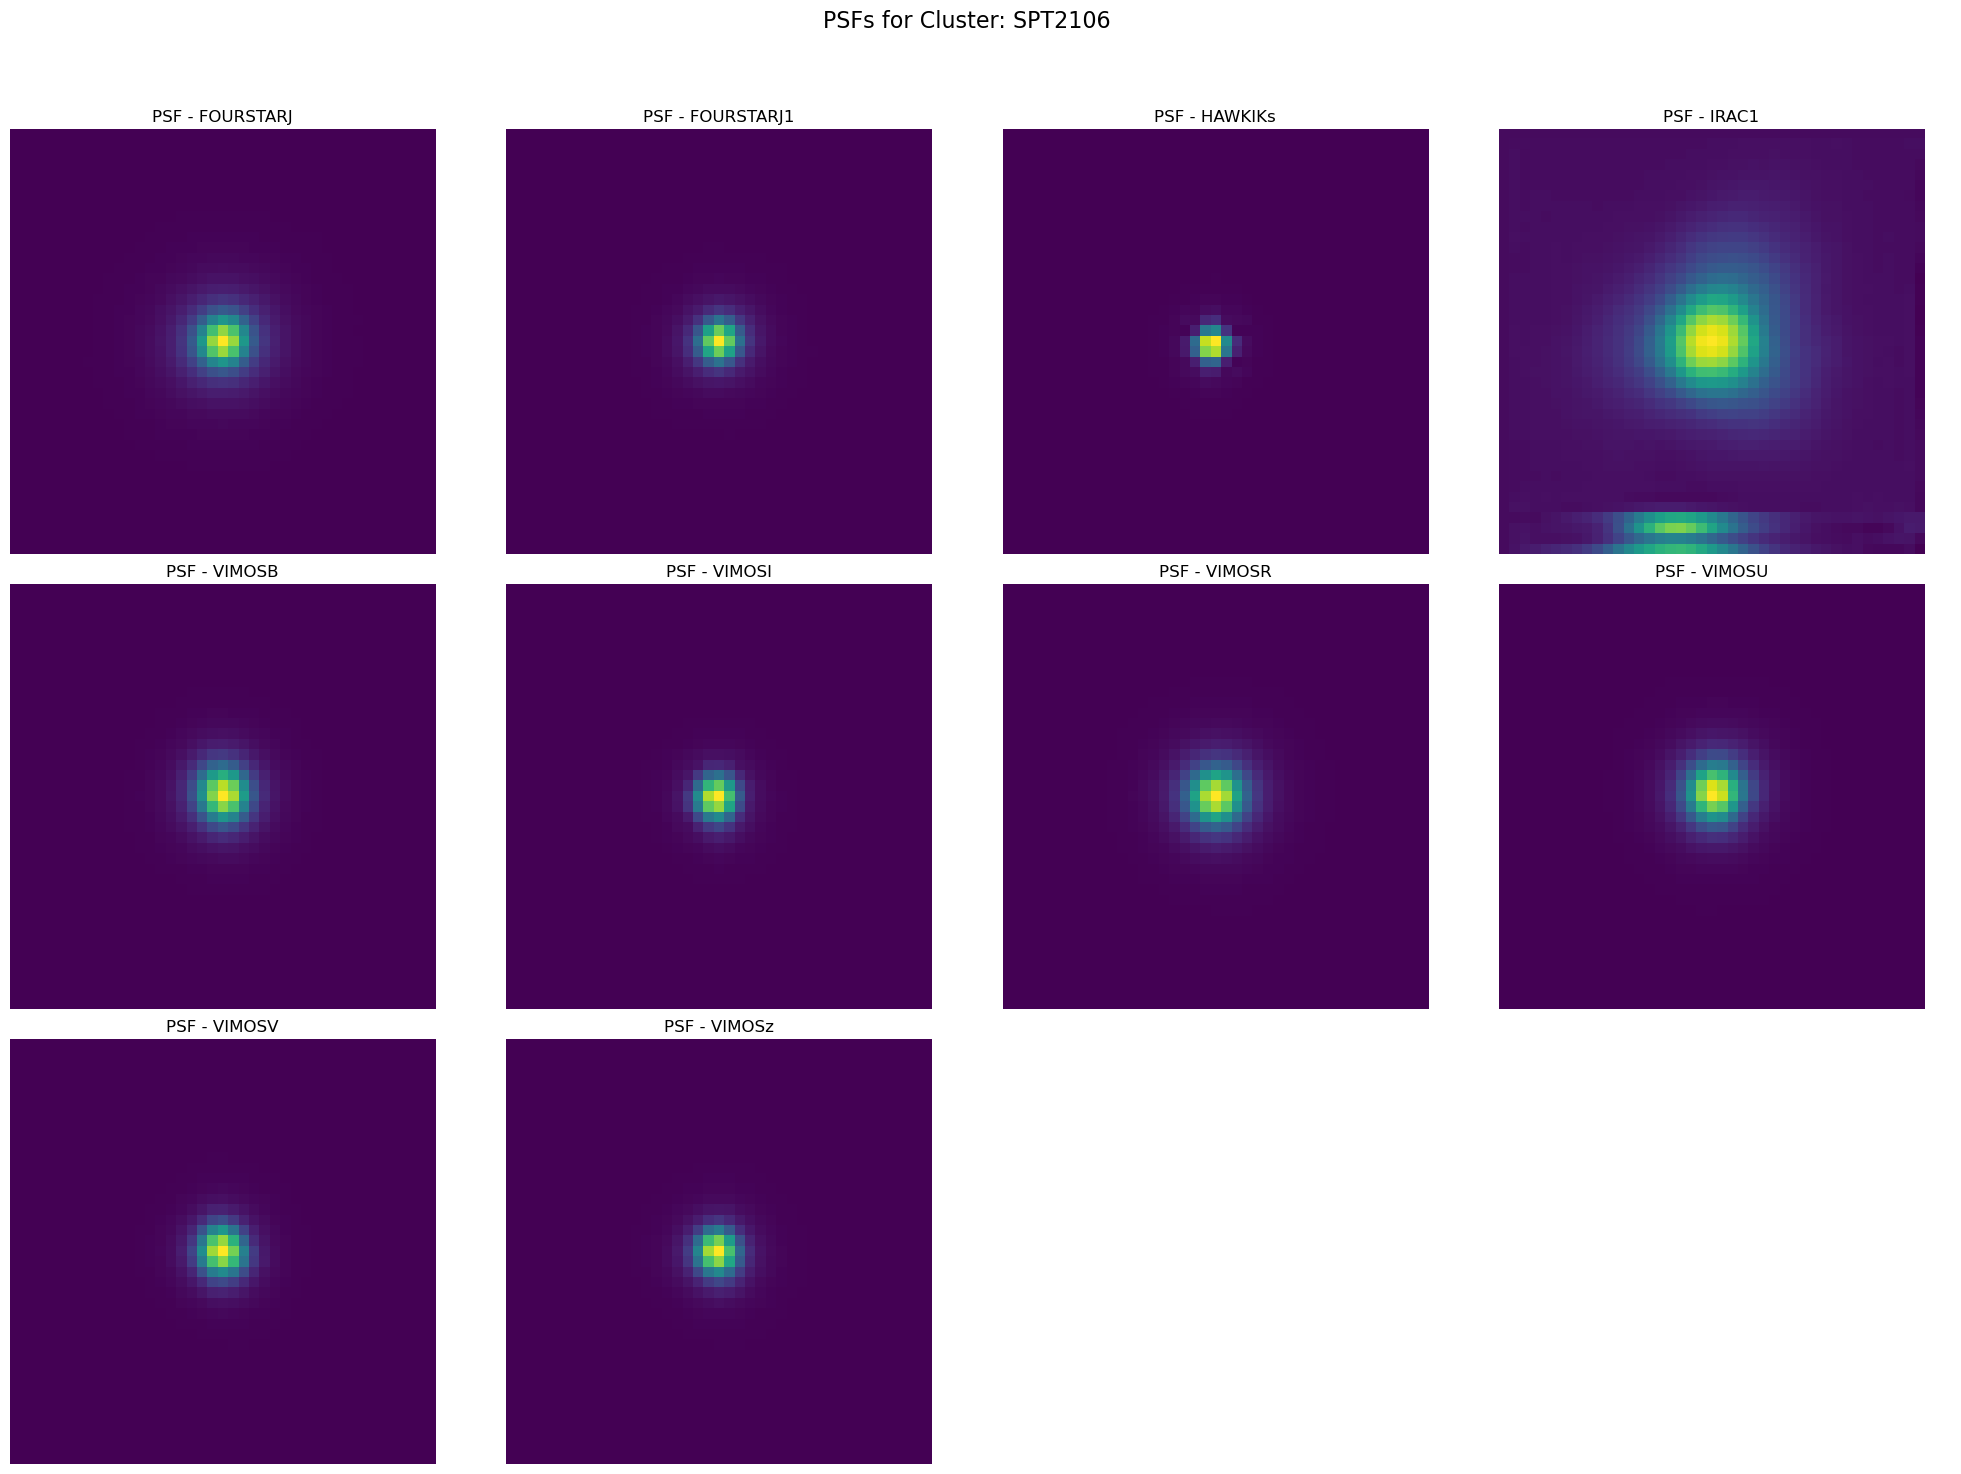

SpARCS0035 DECamz - No stars to filter


SpARCS0035 FOURSTARJ1 - No stars to filter
SpARCS0035 HAWKIJ - No stars to filter
SpARCS0035 HAWKIKs - Filtering out stars: [104002572]
SpARCS0035 IRAC1 - No stars to filter
SpARCS0035 IRAC2 - No stars to filter
SpARCS0035 IRAC3 - No stars to filter


SpARCS0035 IRAC4 - No stars to filter


SpARCS0035 VIMOSB - No stars to filter


SpARCS0035 VIMOSI - No stars to filter


SpARCS0035 VIMOSR - No stars to filter


SpARCS0035 VIMOSU - No stars to filter


SpARCS0035 VIMOSV - No stars to filter


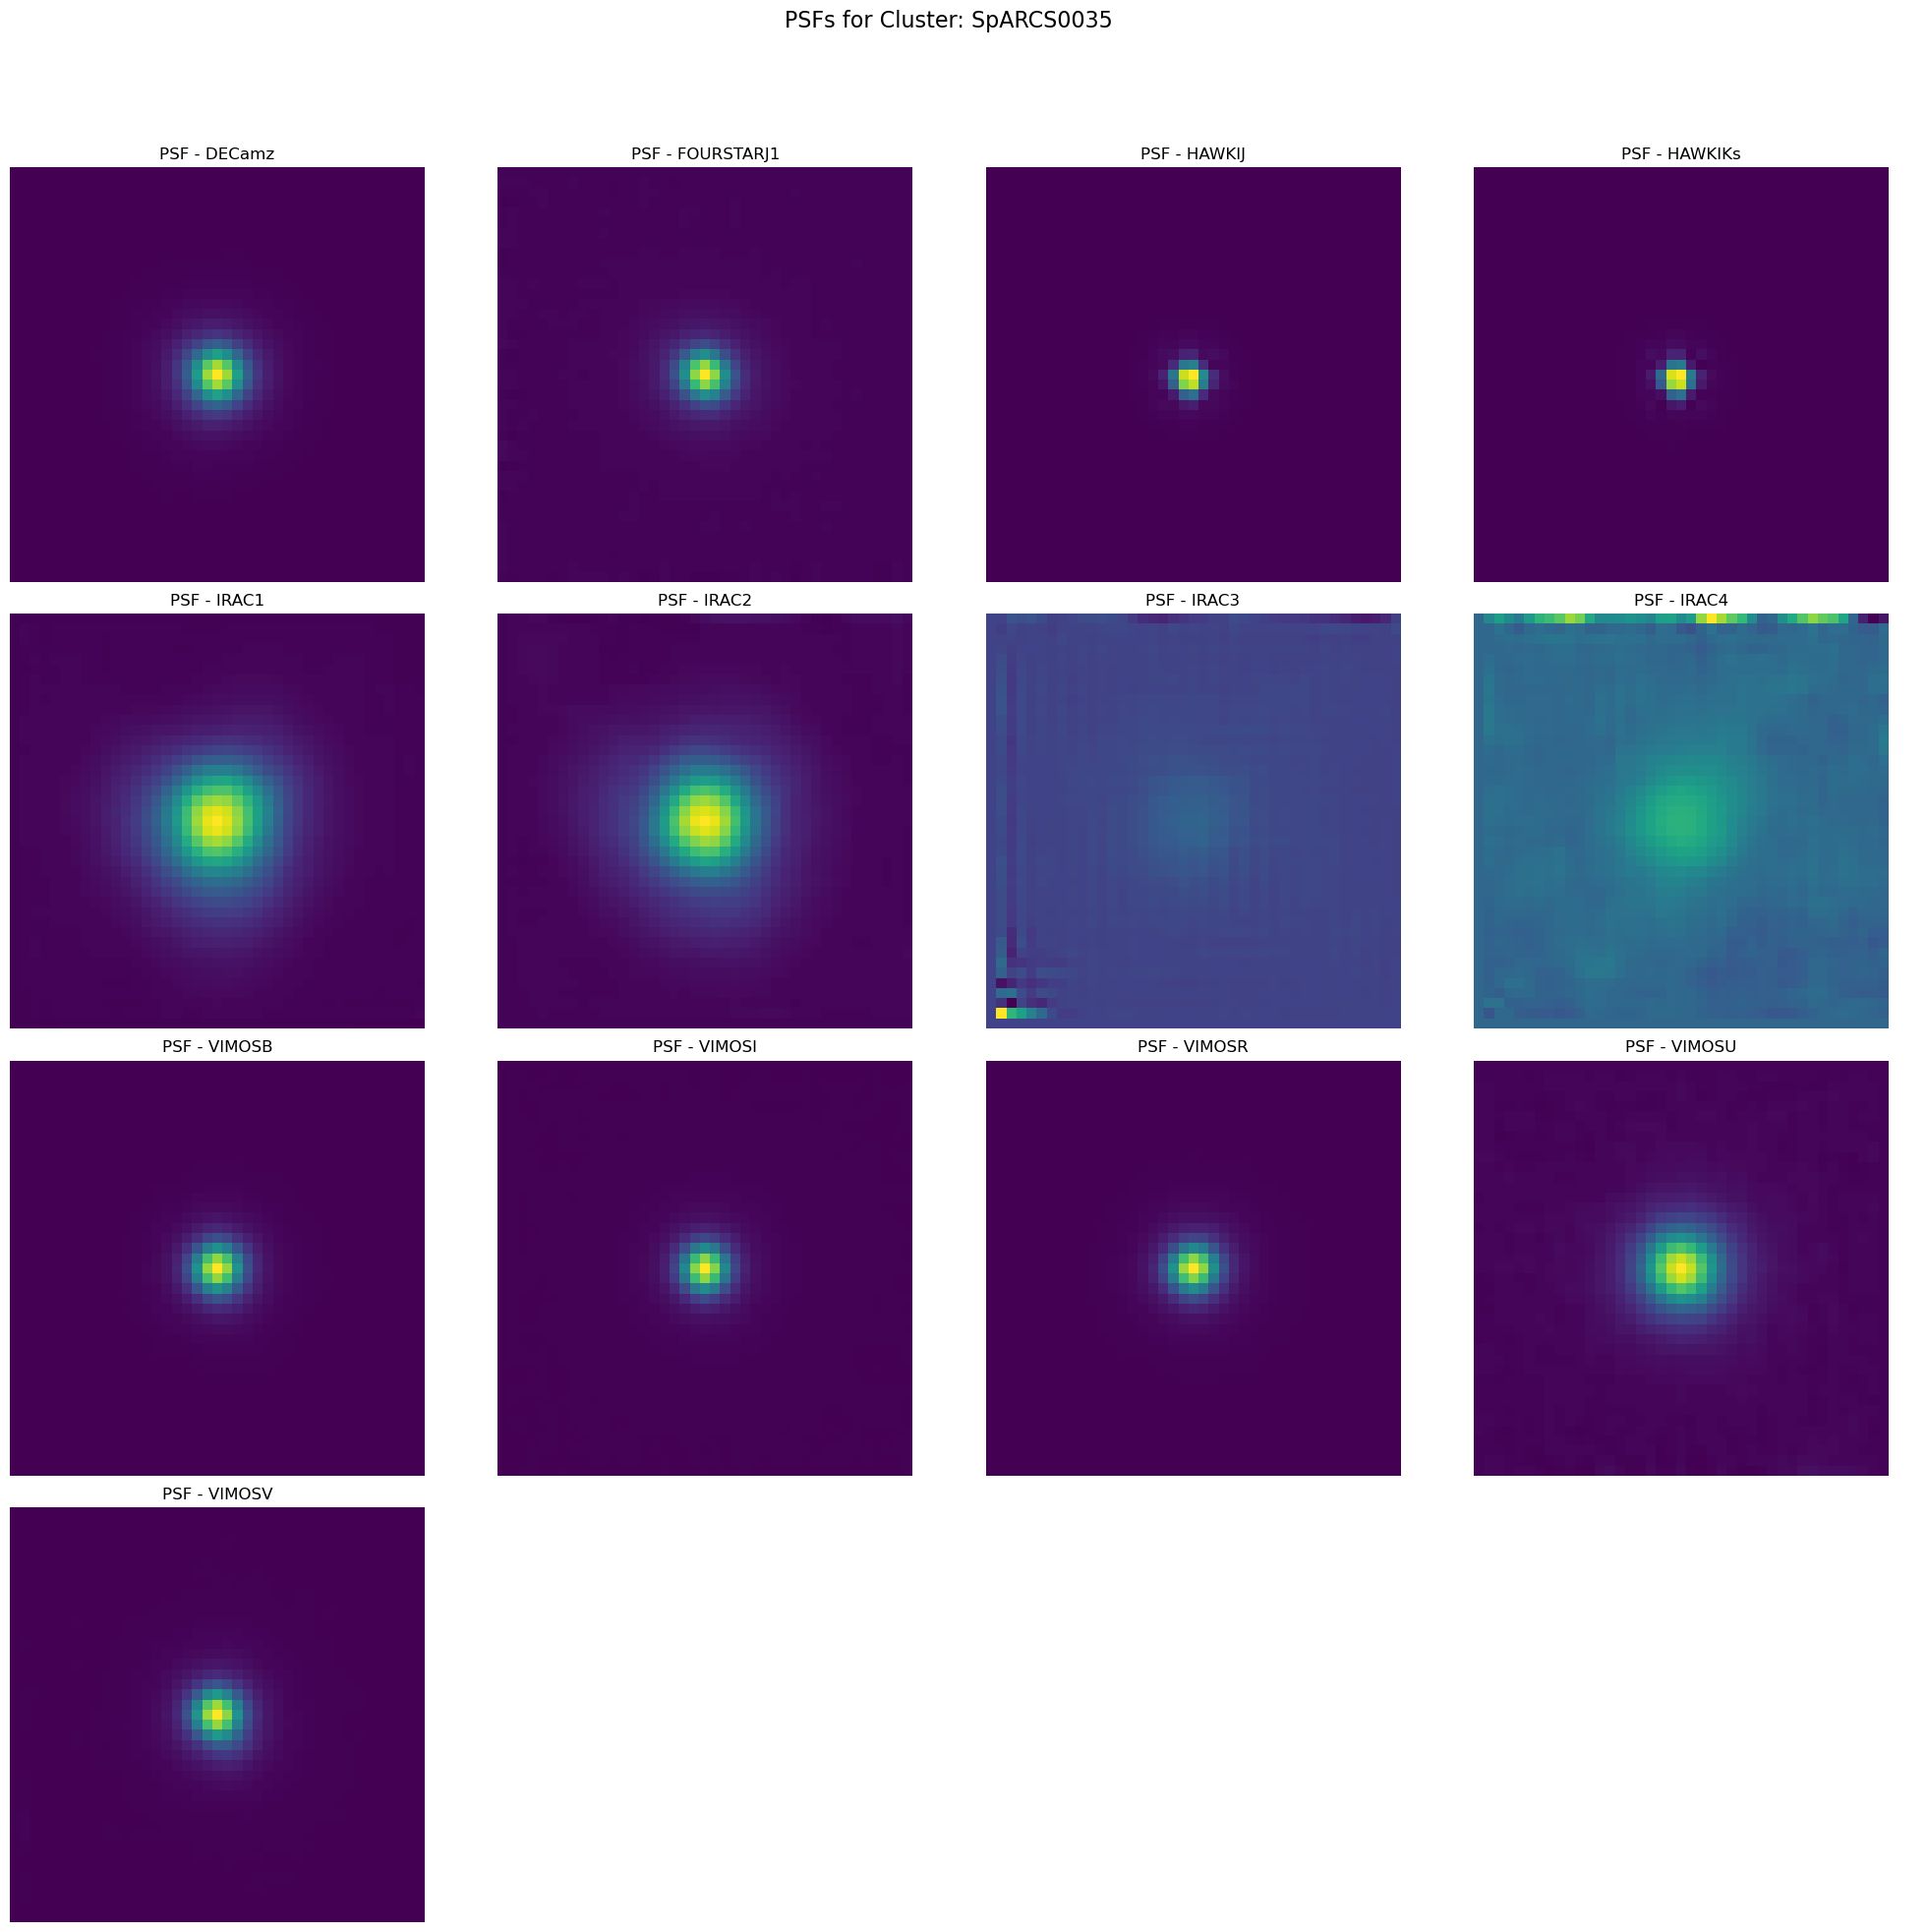

SpARCS0219 FOURSTARJ - Filtering out stars: [105000222, 105001747]


SpARCS0219 FOURSTARJ1 - Filtering out stars: [105001747]


SpARCS0219 FOURSTARKs - Filtering out stars: [105000800, 105001509, 105001747]
SpARCS0219 IRAC1 - No stars to filter
SpARCS0219 IRAC2 - No stars to filter
SpARCS0219 IRAC3 - No stars to filter


SpARCS0219 IRAC4 - No stars to filter


SpARCS0219 VIMOSB - Filtering out stars: [105001747]


SpARCS0219 VIMOSI - Filtering out stars: [105000222]


SpARCS0219 VIMOSR - No stars to filter


SpARCS0219 VIMOSU - Filtering out stars: [105001747]


SpARCS0219 VIMOSV - Filtering out stars: [105001747]


SpARCS0219 VIMOSz - Filtering out stars: [105000222, 105001747]


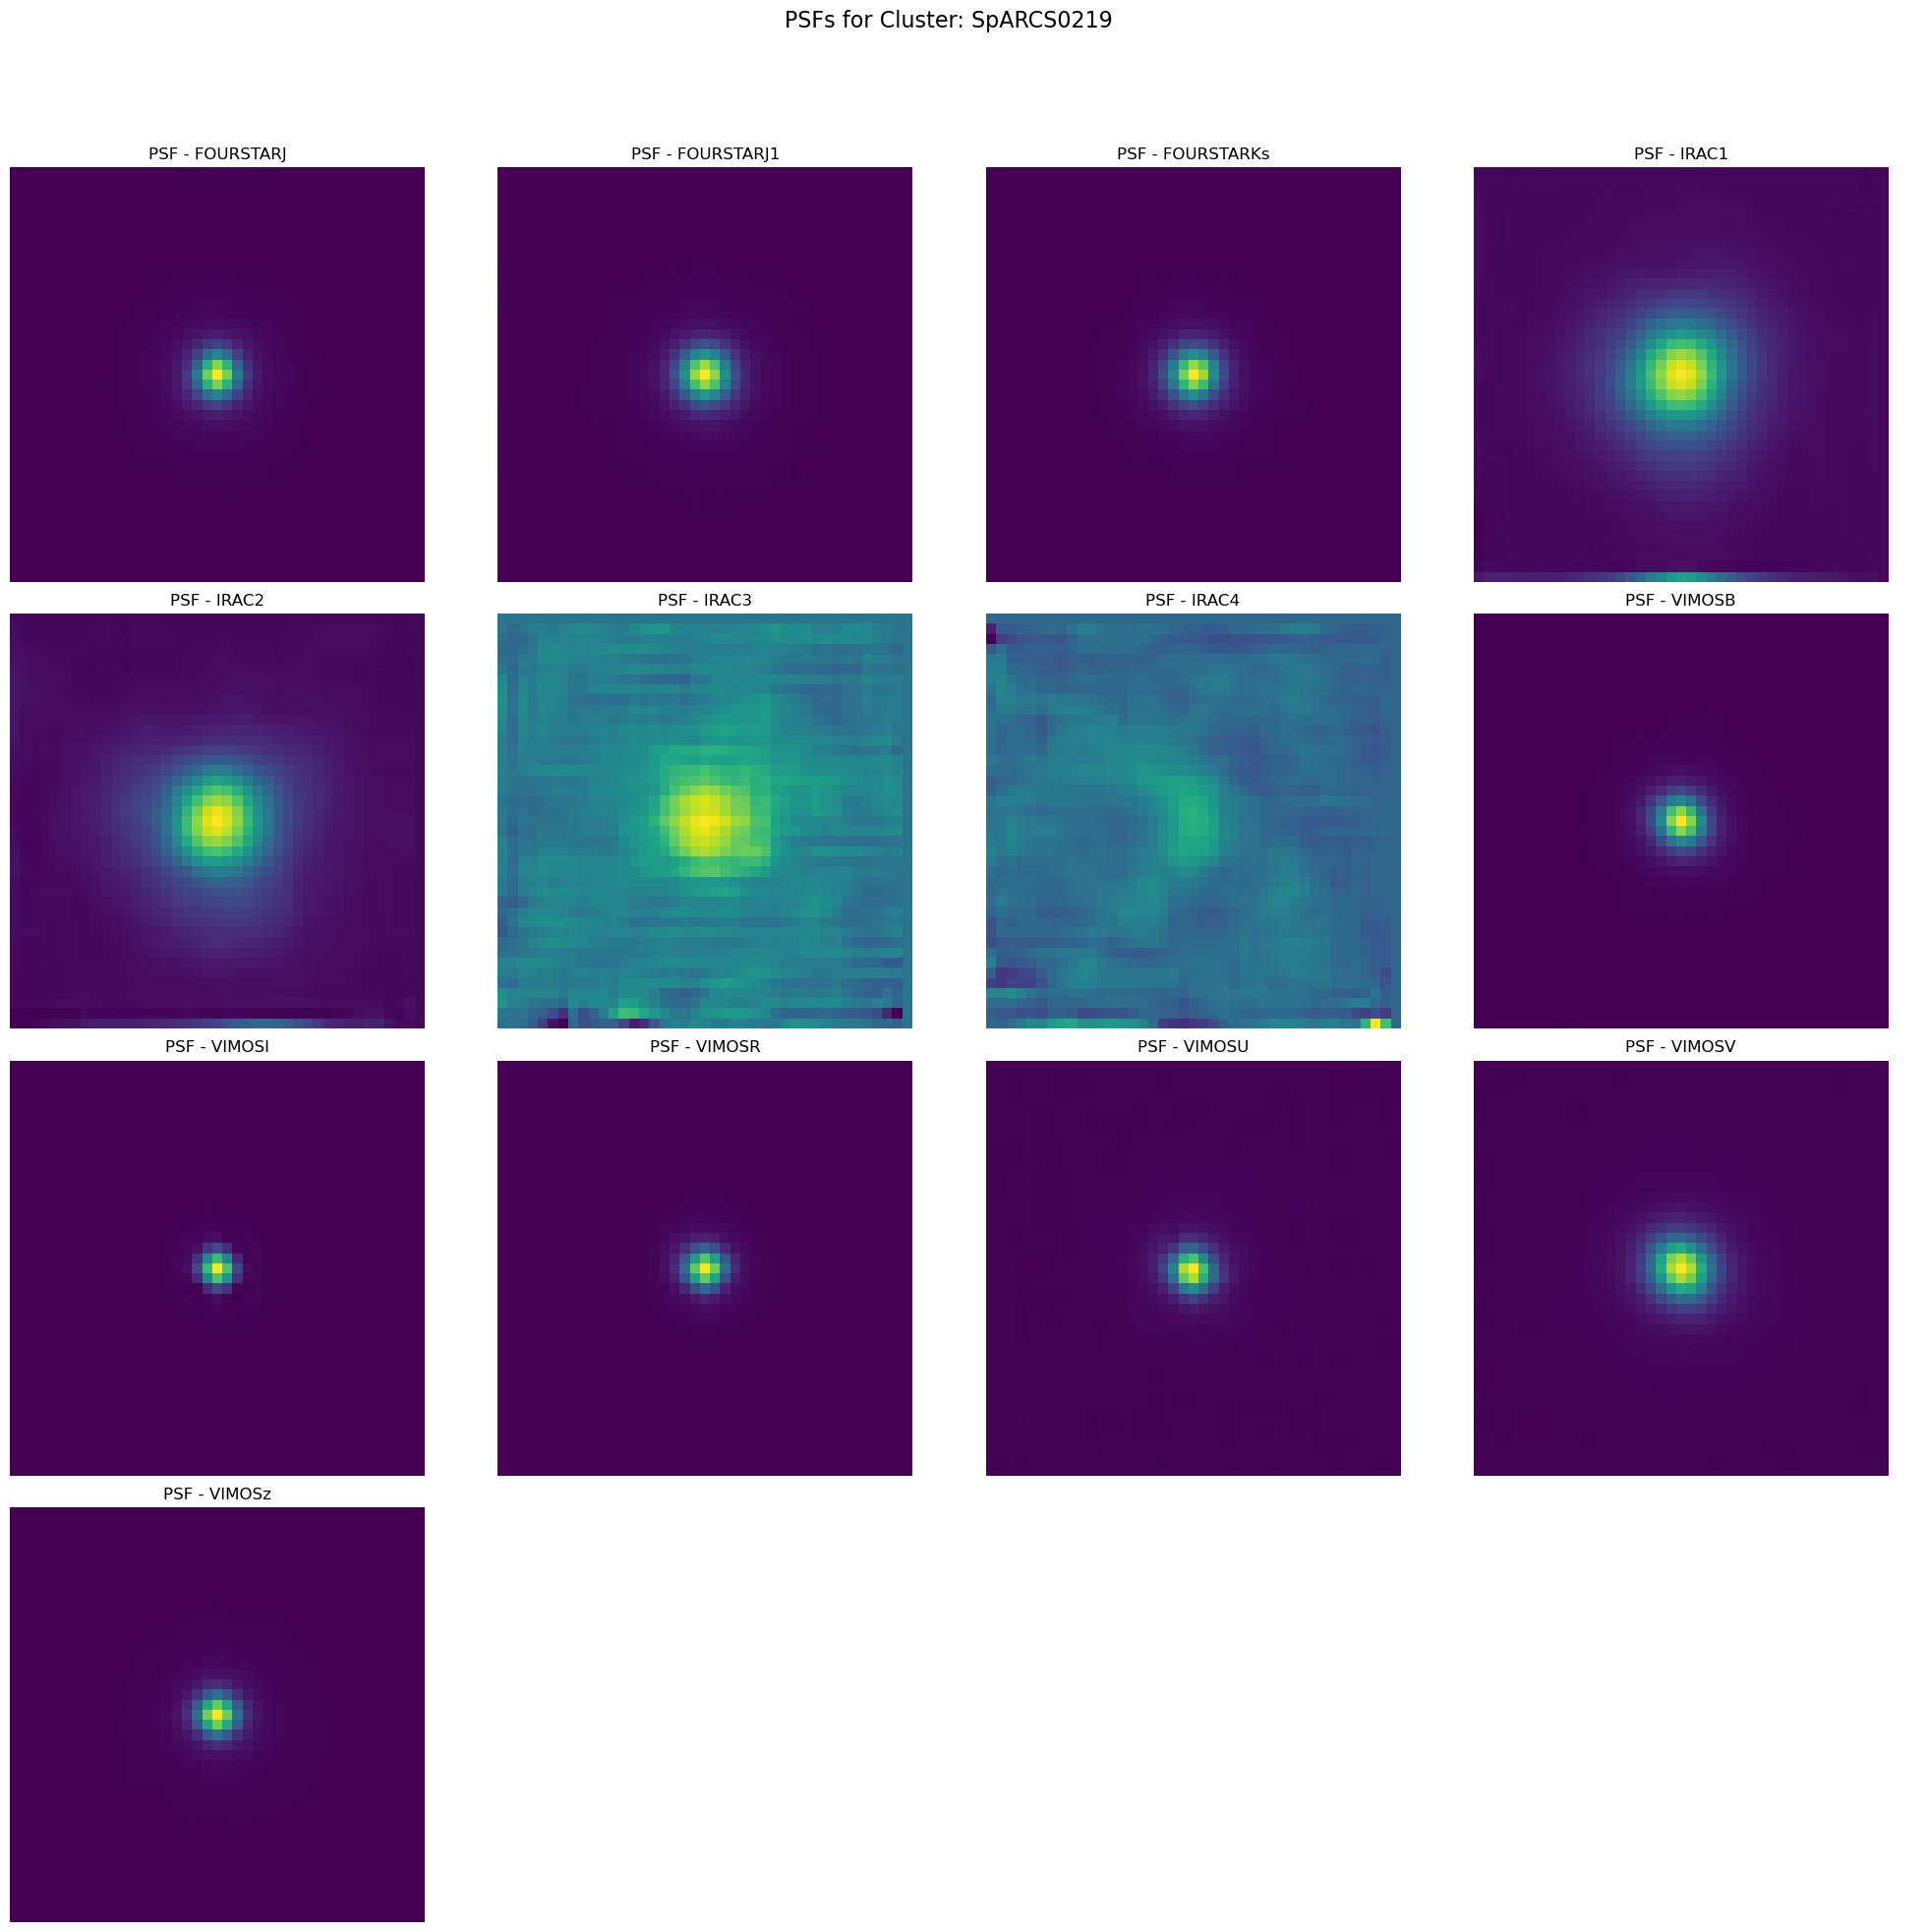

SpARCS0335 FOURSTARKs - No stars to filter
SpARCS0335 HAWKIY - No stars to filter
SpARCS0335 IRAC1 - No stars to filter
SpARCS0335 IRAC2 - No stars to filter
SpARCS0335 IRAC3 - No stars to filter


SpARCS0335 IRAC4 - No stars to filter


SpARCS0335 VIMOSB - No stars to filter


SpARCS0335 VIMOSI - Filtering out stars: [106000822]


SpARCS0335 VIMOSR - No stars to filter


SpARCS0335 VIMOSU - No stars to filter


SpARCS0335 VIMOSV - No stars to filter


SpARCS0335 VIMOSz - No stars to filter


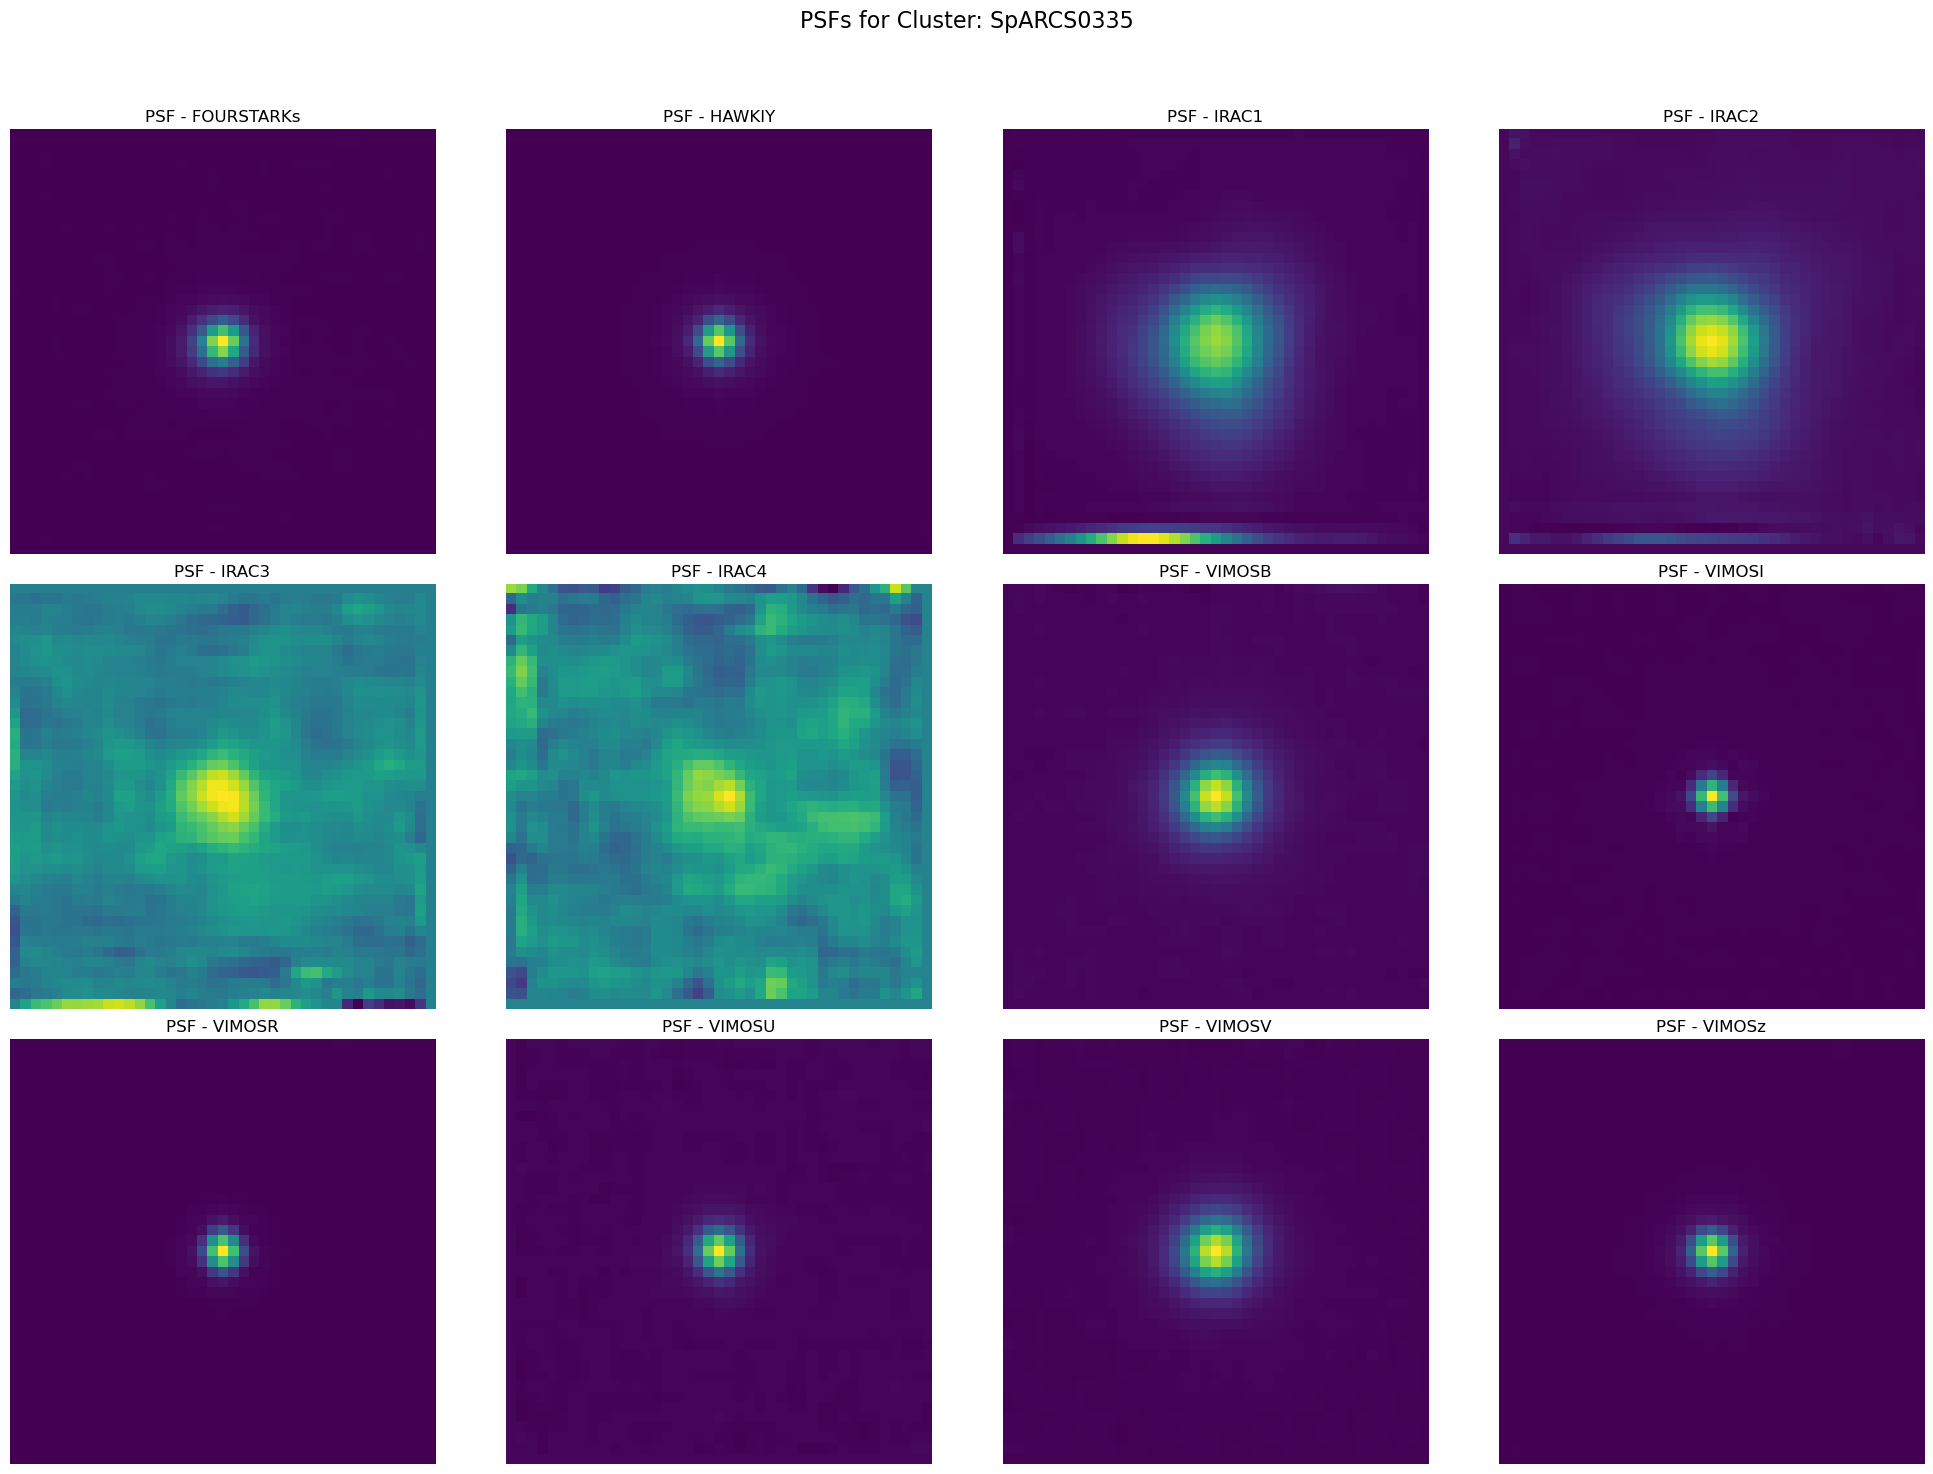

SpARCS1034 HSCy - Filtering out stars: [108003171, 108004662]
SpARCS1034 HSCz - Filtering out stars: [108004662]
SpARCS1034 IRAC1 - No stars to filter
SpARCS1034 IRAC2 - No stars to filter
SpARCS1034 IRAC3 - No stars to filter


SpARCS1034 IRAC4 - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1034 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1034 Suprimei - Filtering out stars: [108004065]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1034 Suprimer - No stars to filter


SpARCS1034 WIRCamJ - Filtering out stars: [108004662]


SpARCS1034 WIRCamK - Filtering out stars: [108001350, 108004064, 108004662, 108008541]


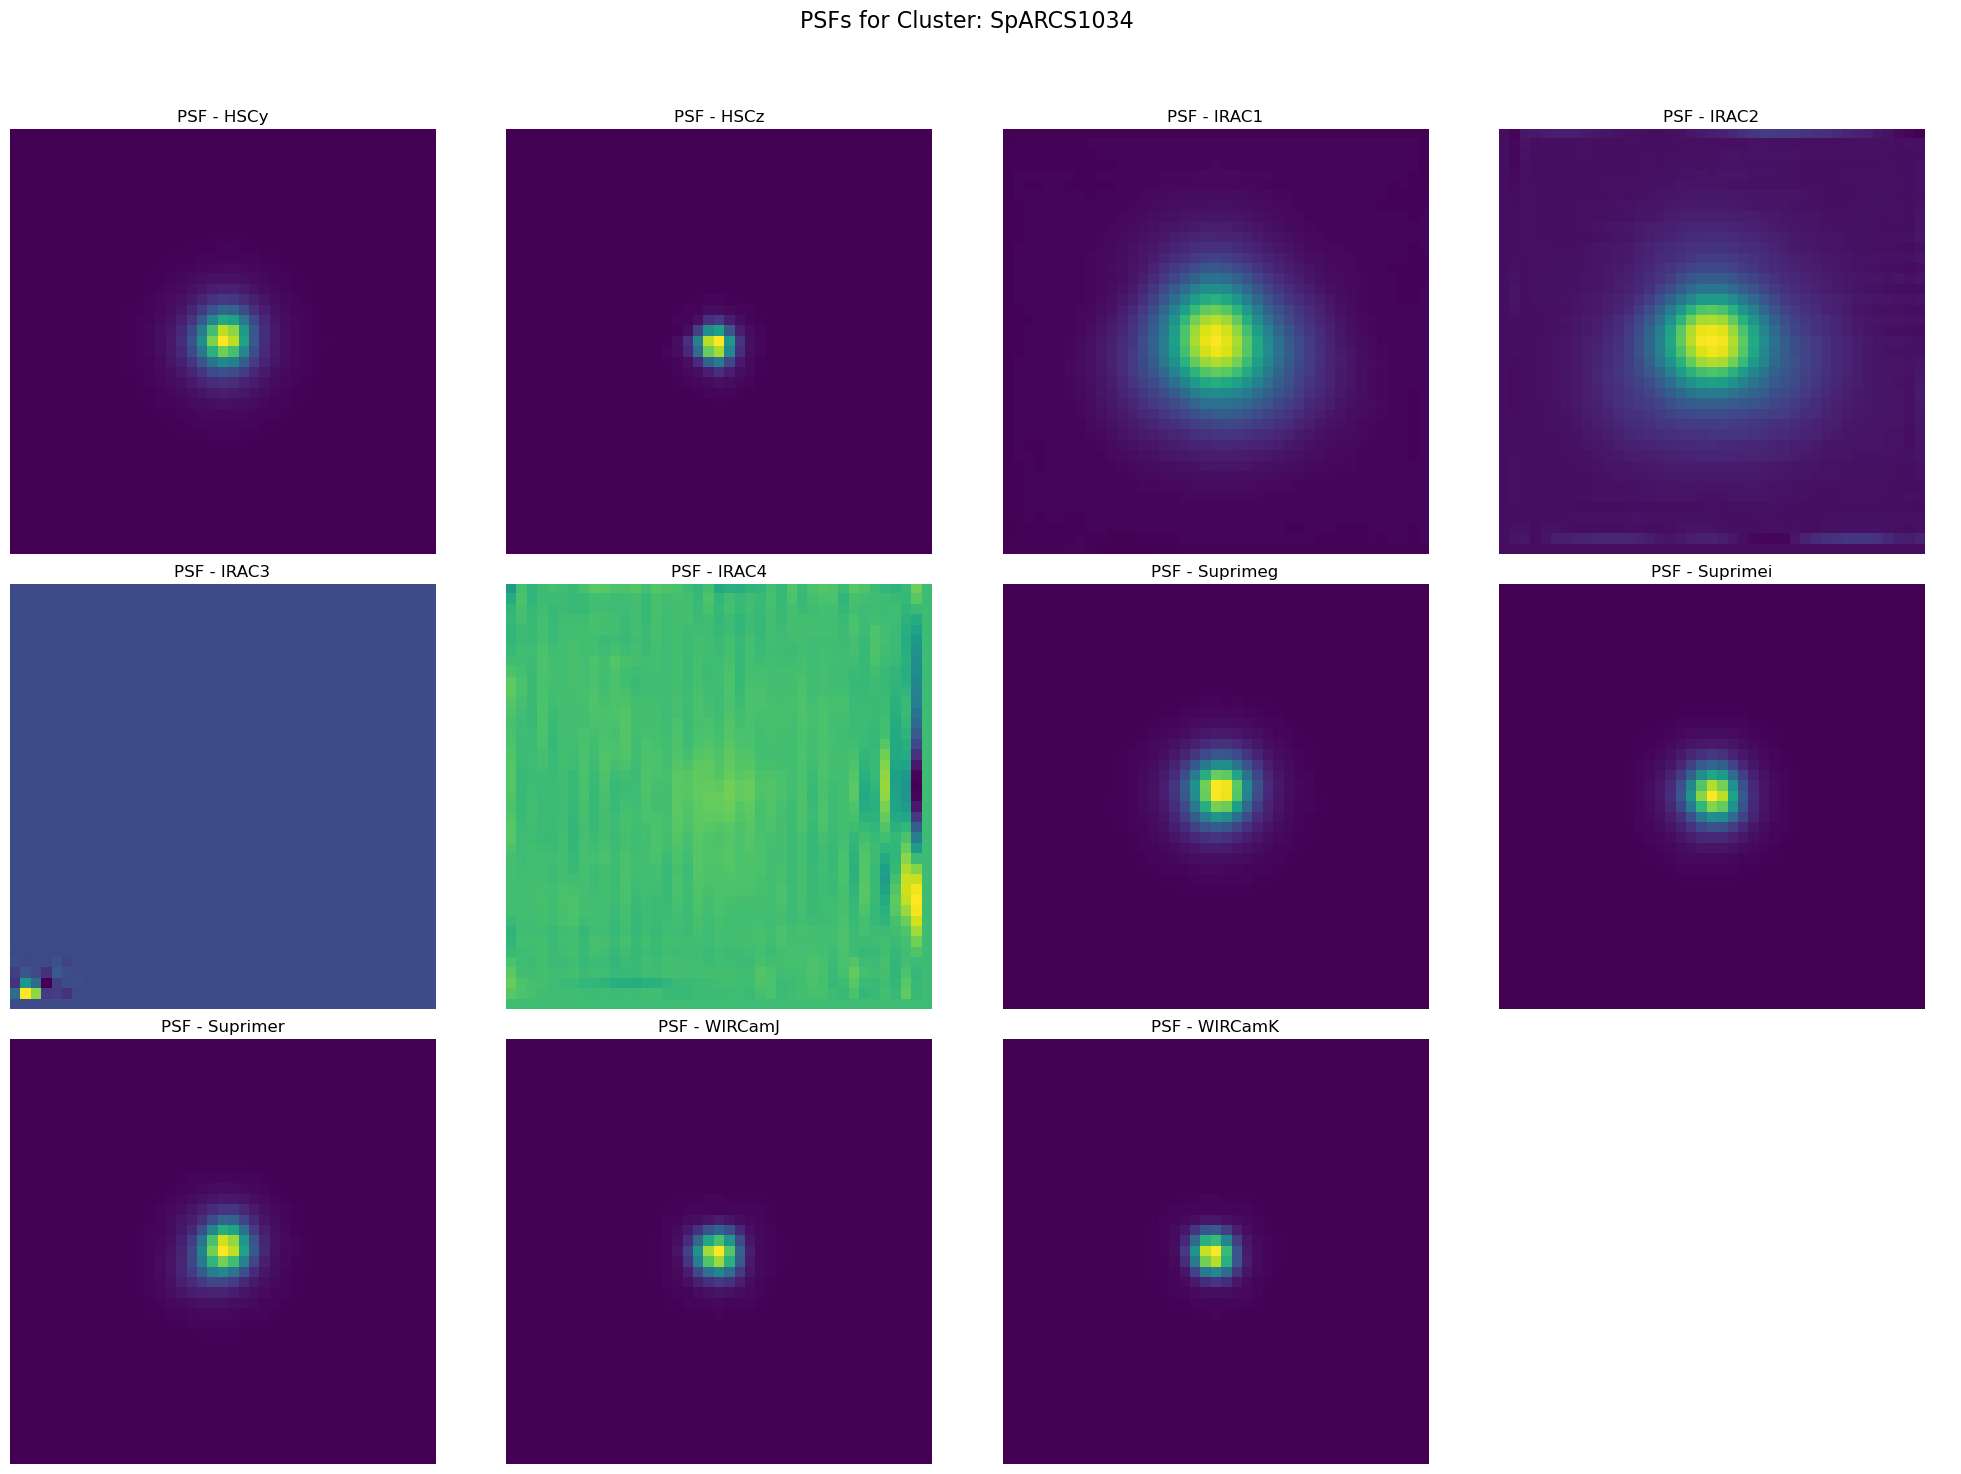

SpARCS1616 HSCy - No stars to filter


SpARCS1616 HSCz - No stars to filter
SpARCS1616 IRAC1 - No stars to filter
SpARCS1616 IRAC2 - No stars to filter
SpARCS1616 IRAC3 - No stars to filter
SpARCS1616 IRAC4 - No stars to filter


Error processing SpARCS1616, IRAC4: No points given
SpARCS1616 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1616 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1616 Suprimei - Filtering out stars: [110008997, 110009550]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1616 Suprimer - Filtering out stars: [110008997]
SpARCS1616 WIRCamJ - Filtering out stars: [110008997, 110009550]
SpARCS1616 WIRCamK - Filtering out stars: [110007491, 110008997, 110009550]


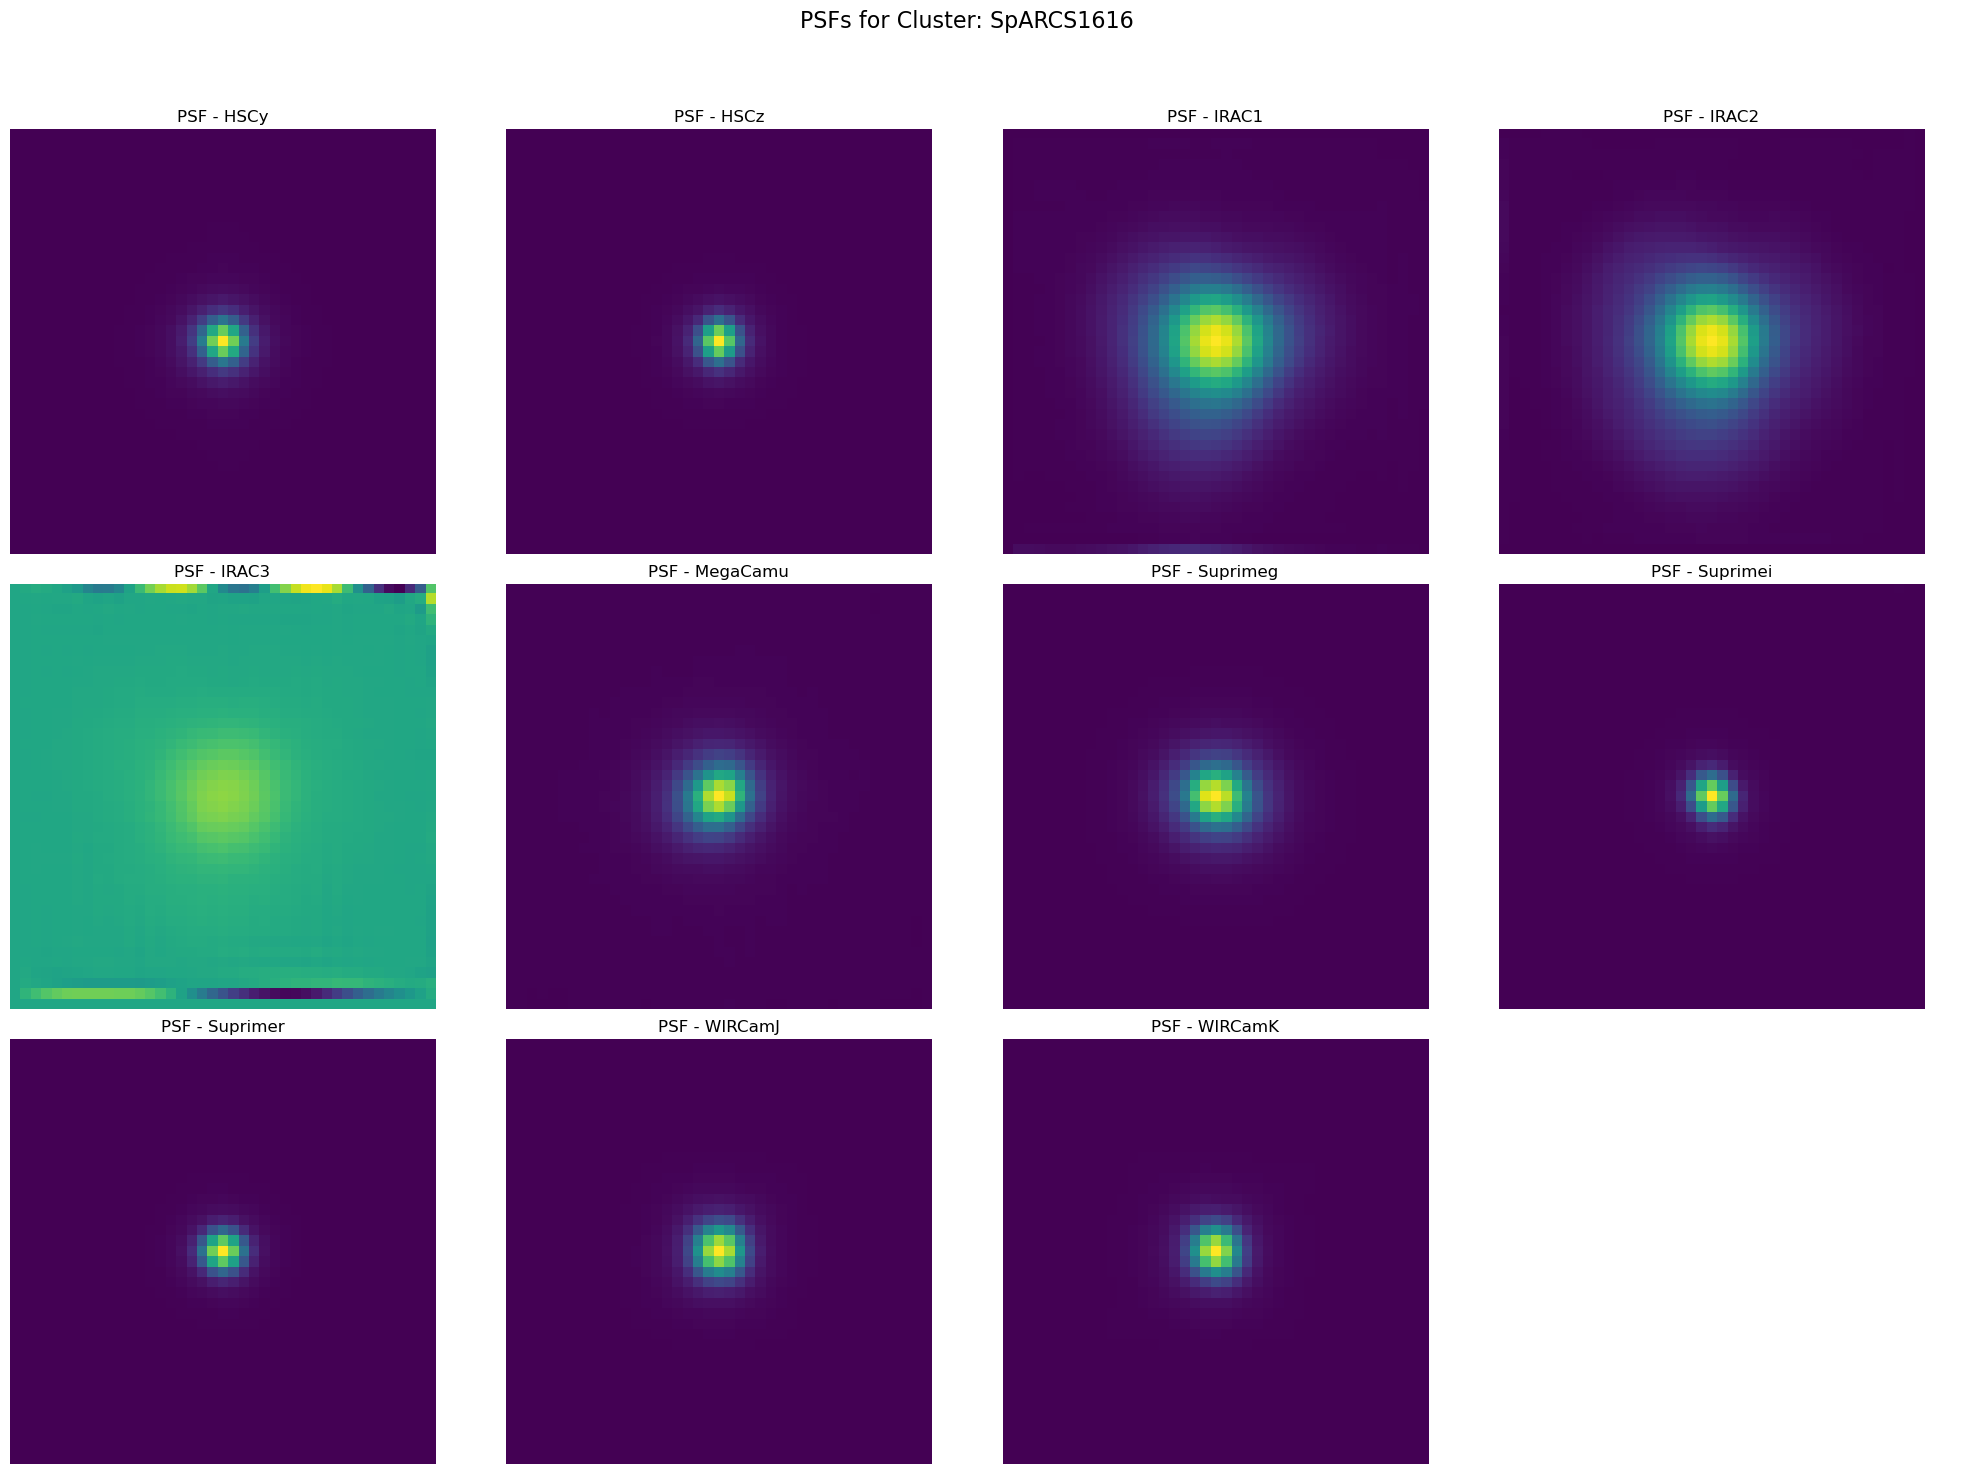

SpARCS1634 GMOSz - No stars to filter
SpARCS1634 IRAC1 - No stars to filter
SpARCS1634 IRAC2 - No stars to filter
SpARCS1634 IRAC3 - No stars to filter


SpARCS1634 IRAC4 - No stars to filter


SpARCS1634 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1634 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1634 Suprimei - Filtering out stars: [111003969, 111004522, 111005881, 111006317]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1634 Suprimer - Filtering out stars: [111004201, 111006317]


SpARCS1634 WIRCamJ - No stars to filter


SpARCS1634 WIRCamK - Filtering out stars: [111007767]


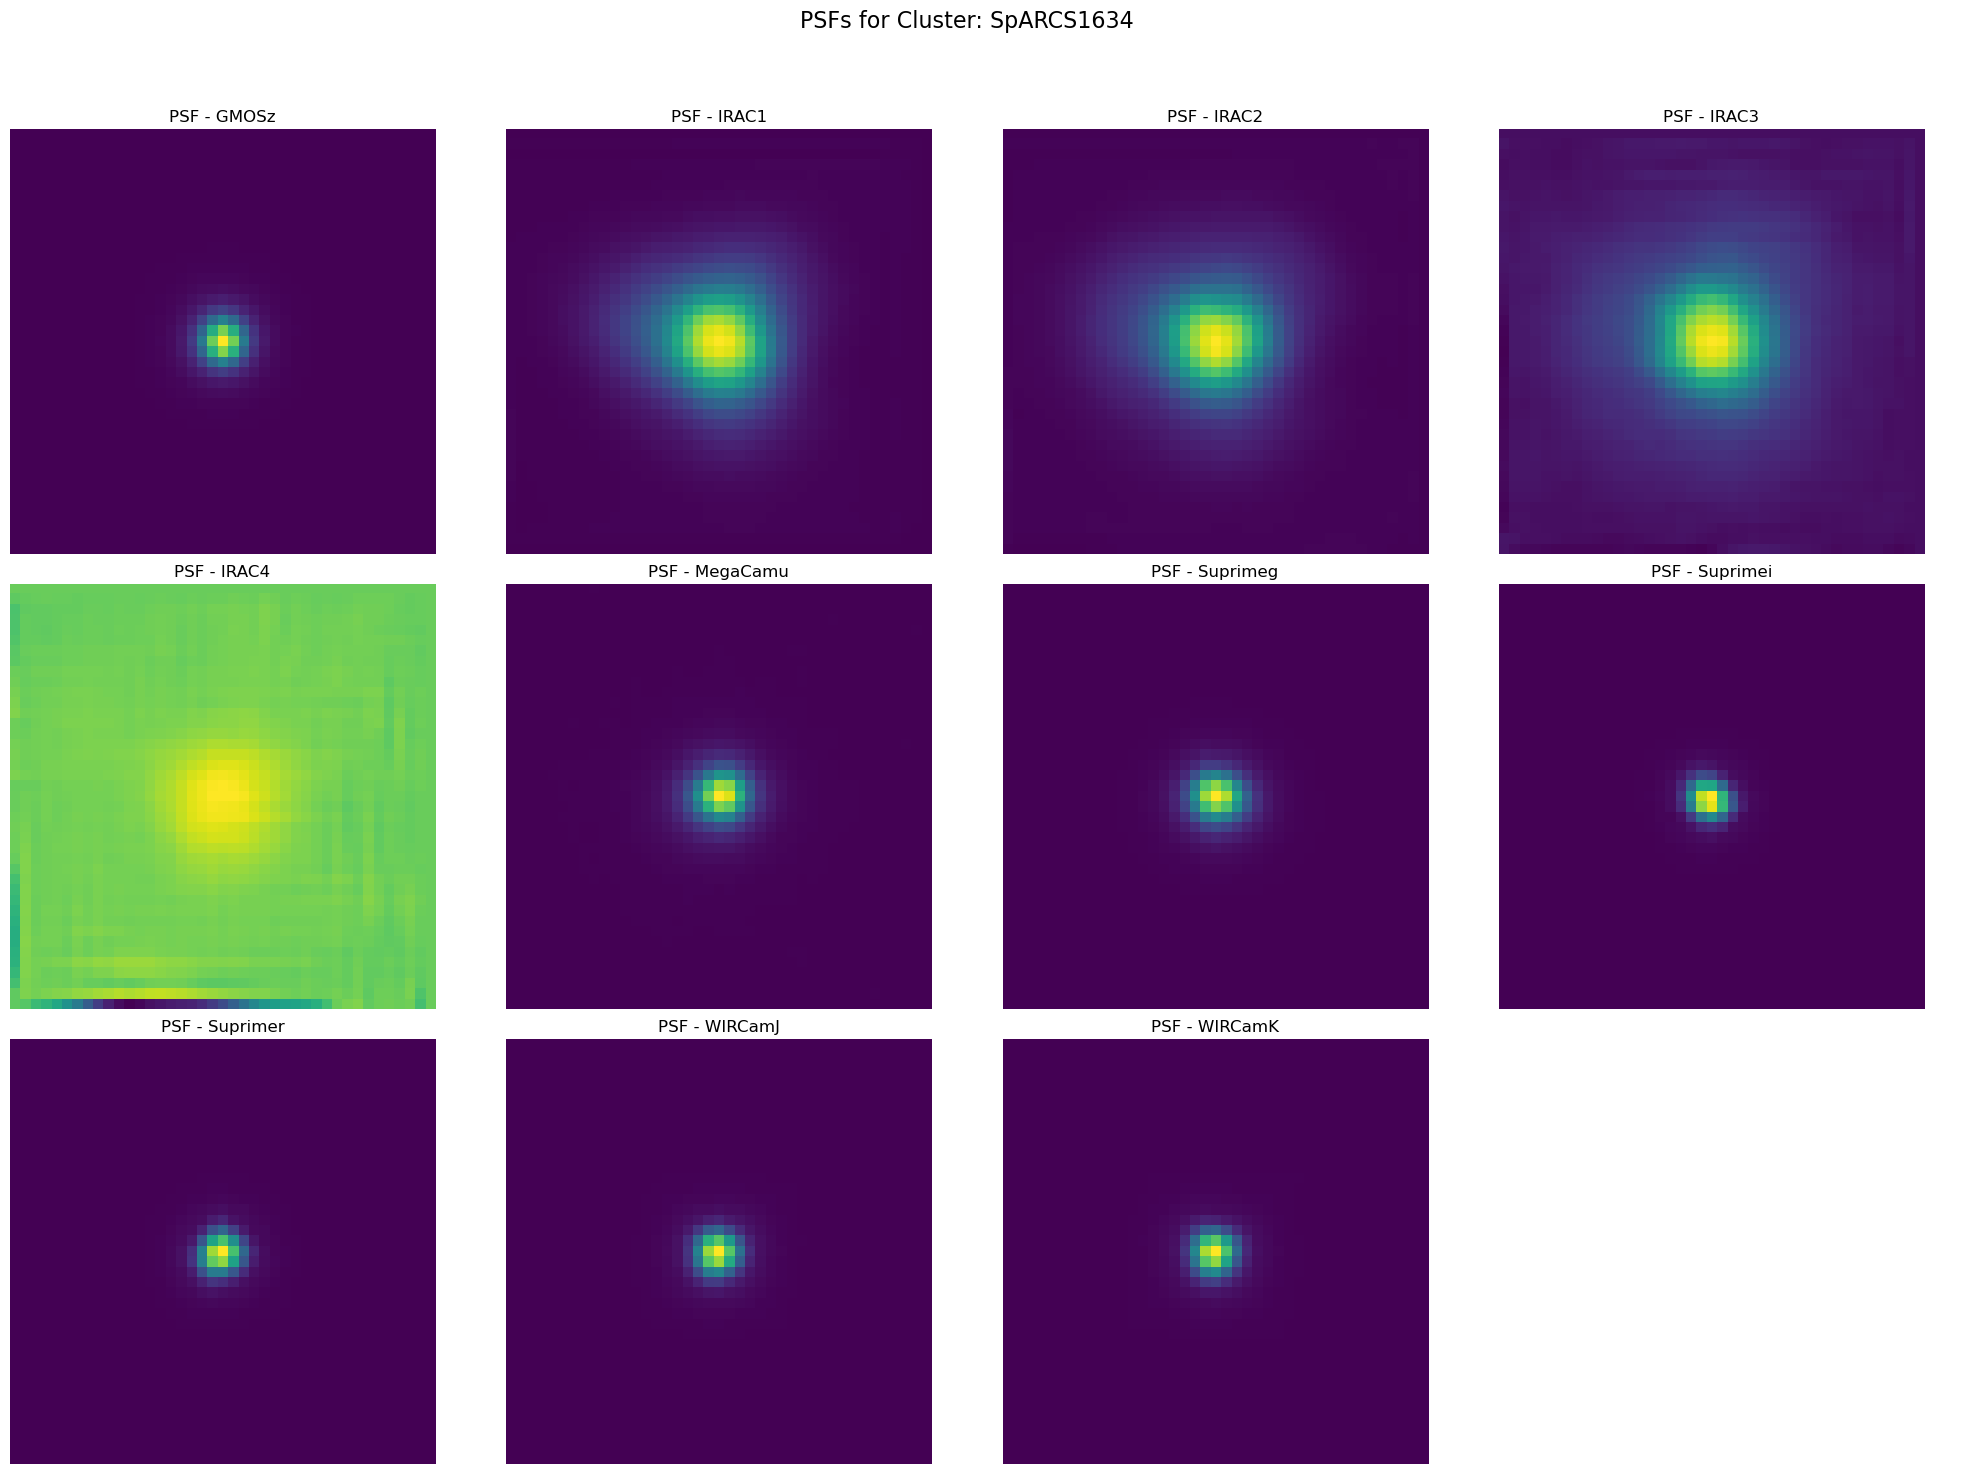

SpARCS1638 GMOSz - No stars to filter
SpARCS1638 IRAC1 - No stars to filter
SpARCS1638 IRAC2 - No stars to filter
SpARCS1638 IRAC3 - No stars to filter
SpARCS1638 IRAC4 - No stars to filter


SpARCS1638 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimei - Filtering out stars: [112008857]


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimer - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1638 Suprimey - No stars to filter
SpARCS1638 WIRCamJ - No stars to filter
SpARCS1638 WIRCamK - No stars to filter


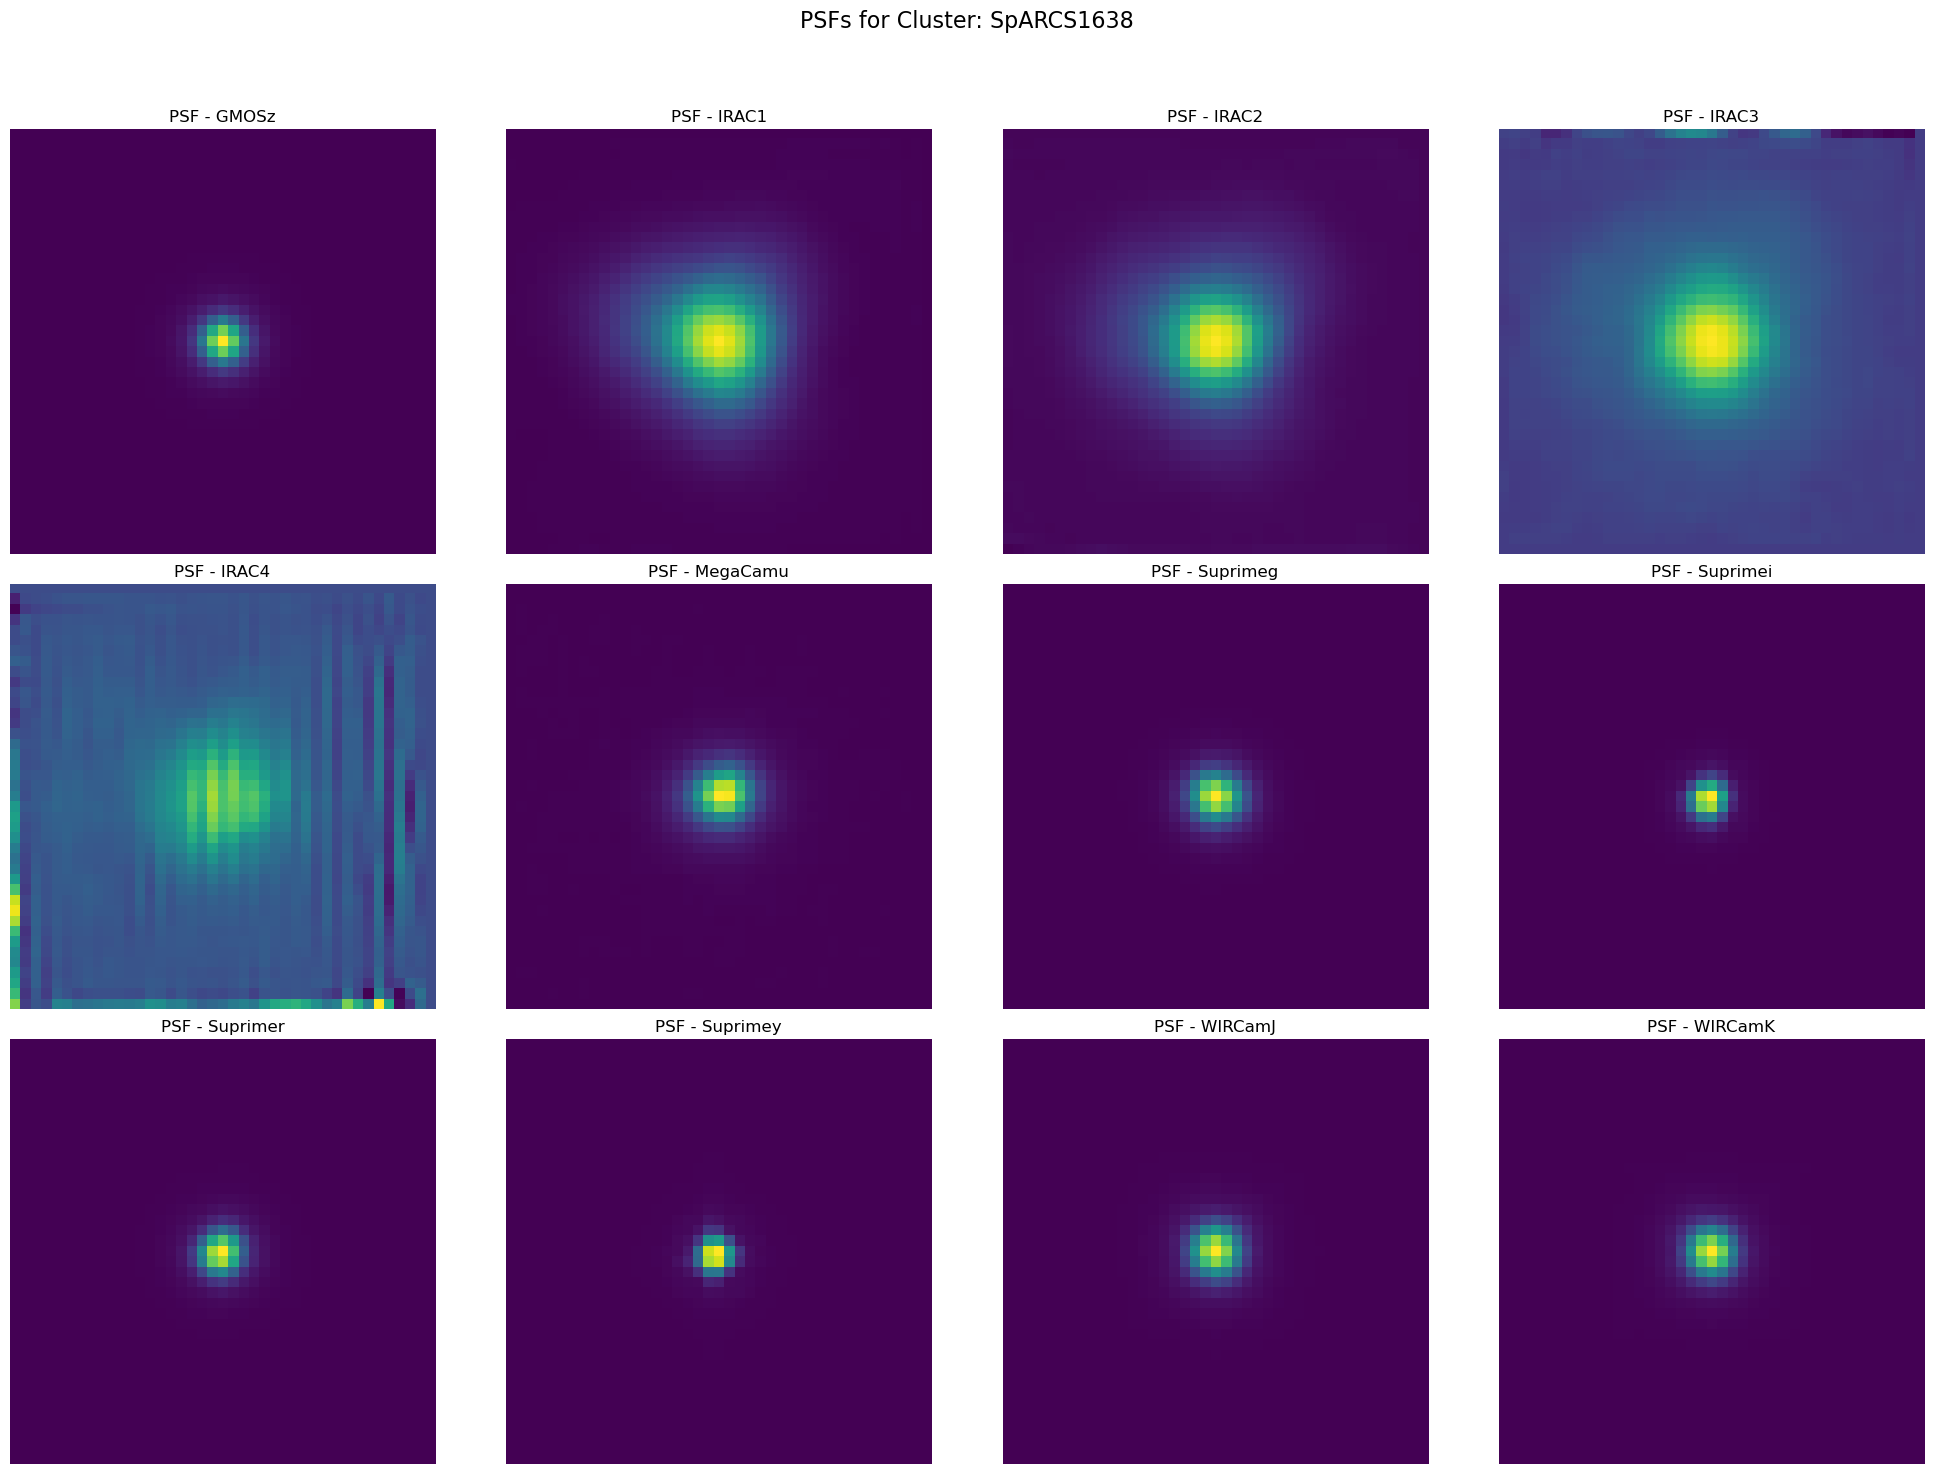

In [21]:
plot_psfs_per_cluster(clusters, root2)

SpARCS1051 HSCy - No stars to filter


SpARCS1051 HSCz - No stars to filter
SpARCS1051 IRAC1 - No stars to filter
SpARCS1051 IRAC2 - No stars to filter
SpARCS1051 IRAC3 - No stars to filter
SpARCS1051 IRAC4 - No stars to filter
Error processing SpARCS1051, IRAC4: 'NoneType' object has no attribute 'data'
SpARCS1051 MegaCamu - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1051 Suprimeg - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1051 Suprimei - No stars to filter


  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


SpARCS1051 Suprimer - No stars to filter
SpARCS1051 WIRCamJ - Filtering out stars: [109004554]
SpARCS1051 WIRCamK - Filtering out stars: [109004554]


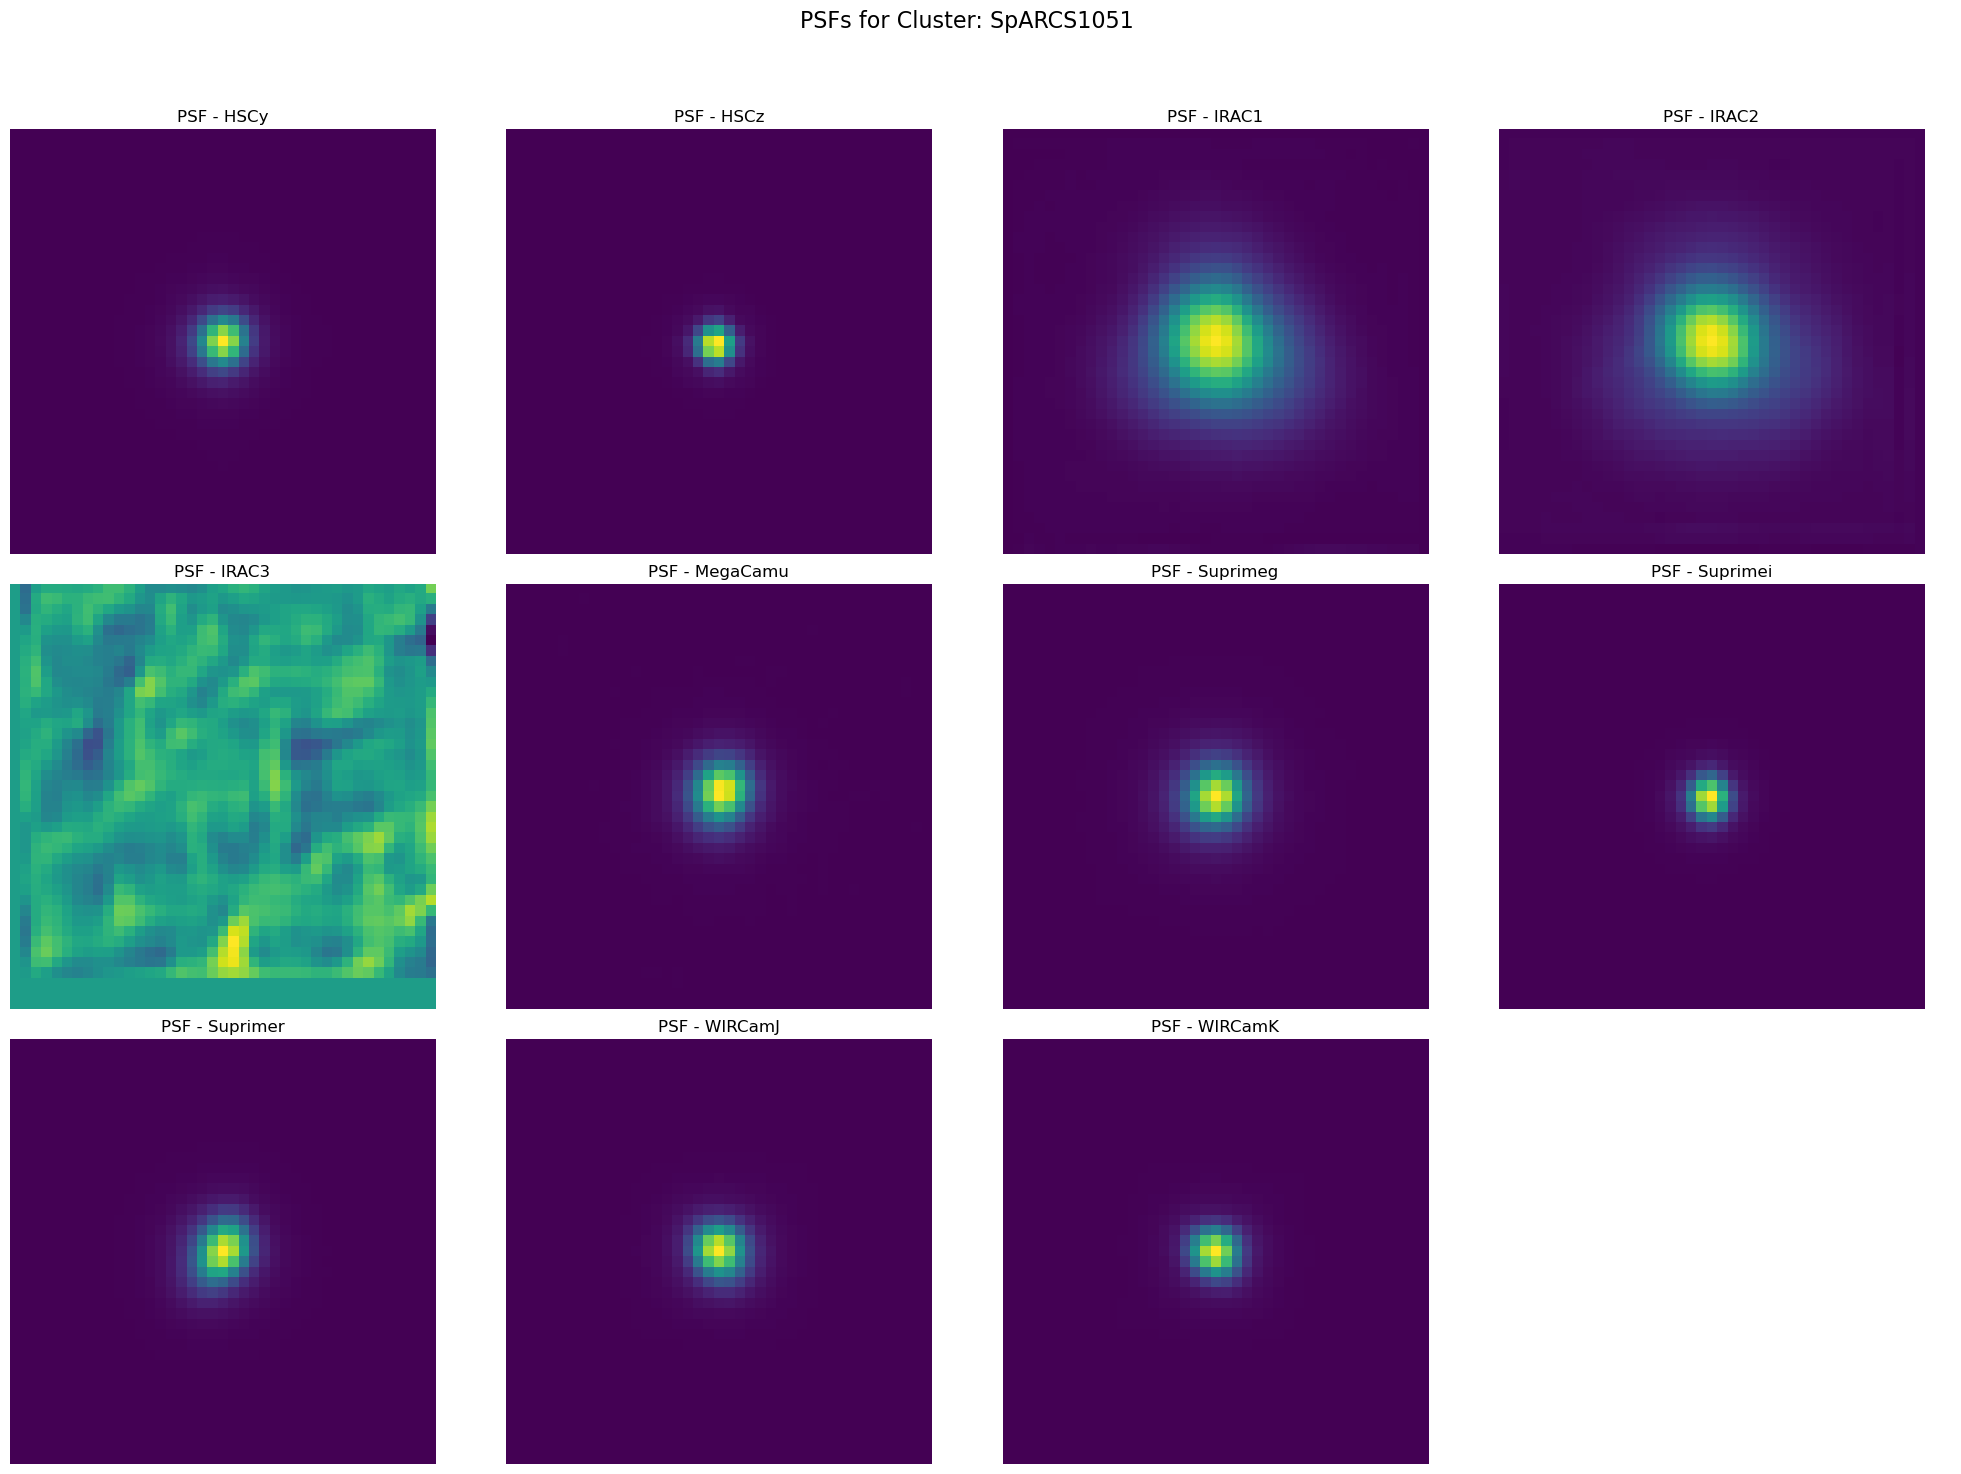

In [22]:
clusters = ['SpARCS1051']
plot_psfs_per_cluster(clusters, root2)

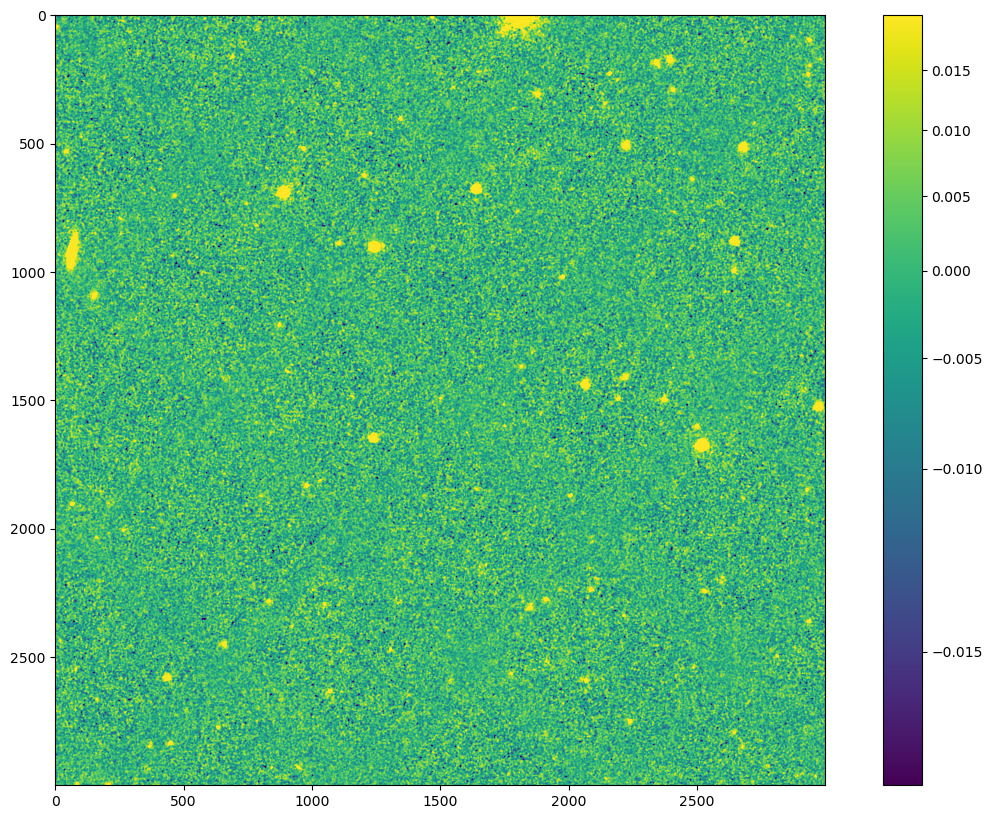

In [28]:

# Define the path to the FITS file
test_fits = f'{root2}/SpARCS1051/GOGREEN_IMAGES/native/images/mos_IRAC4_3.fits'

# Open the FITS file
test_open = fits.open(test_fits)

# Access the data from the primary HDU (the image is in the first HDU, index 0)
image_data = test_open[0].data

# Display the image data
plt.figure(figsize=(15, 10))
norm = simple_norm(image_data, 'sqrt', percent=99.0)
plt.imshow(image_data, norm=norm, cmap='viridis')
plt.colorbar()
plt.show()

# Close the FITS file to avoid any memory issues
test_open.close()